In [1]:
pip install pyspark

     |████████████████████████████████| 204.7 MB 23 kB/s 
     |████████████████████████████████| 198 kB 42.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=9c64fddccaae093372619973f39217cc74ee3e3adc6105460f5869ecc81d1fbc
  Stored in directory: /root/.cache/pip/wheels/4e/c5/36/aef1bb711963a619063119cc032176106827a129c0be20e301
Successfully built pyspark
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install chart_studio

     |████████████████████████████████| 64 kB 1.0 MB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [4]:
# Set your own project id here
PROJECT_ID = 'your-google-cloud-project'
from google.cloud import bigquery
bigquery_client = bigquery.Client(project=PROJECT_ID)

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import (StructField,StructType,StringType,IntegerType,FloatType,LongType,DateType)

spark = SparkSession.builder.master('local[*]').appName("Zomato").config("spark.some.config.option","kf").enableHiveSupport().config("spark.executor.memory","48g").config("spark.driver.memory", "48g").getOrCreate()
#spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
#spark.conf.set("spark.cores.max", "16")
#spark.conf.set("spark.driver.memory", "16g")
#spark.conf.set("spark.executor.memory", "16g")
spark.conf.set("spark.executor.memory_overhead", "32g")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import seaborn as sns
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
cf.go_offline()

init_notebook_mode(connected=True)

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zomato-bangalore-restaurants/zomato.csv


In [6]:
# Creating Schema for reading file in Pyspark
data_schema = [  
               StructField('address',StringType(),True),
               StructField('name',StringType(),True),
               StructField('onlineOrder',StringType(),True),
               StructField('bookTable',StringType(),True),
               StructField('ratingsBy5',StringType(),True),  
               StructField('votes',IntegerType(),True),
               StructField('phone',StringType(),True),
               StructField('location',StringType(),True),
               StructField('restType',StringType(),True),
               StructField('dishLiked',StringType(),True),
               StructField('cuisines',StringType(),True),
               StructField('approx_cost(for two people)',StringType(),True),
               StructField('reviewsList',StringType(),True),
               StructField('listedInType',StringType(),True),
               StructField('listedInCity',StringType(),True),  
              ]
final_struc = StructType(fields=data_schema)

#### Loading the Zomato.csv file

In [7]:
#Pandas 
p1 = time.time()
zomatoDataPandas = pd.read_csv('../input/zomato-bangalore-restaurants/zomato.csv',sep=',')
p2 = time.time()

print("Time taken by Pandas to read file is: {0} sec".format(np.round(p2-p1,2)))

Time taken by Pandas to read file is: 4.36 sec


#### Size of the File

In [8]:
#size of the file
start_mem_usg = zomatoDataPandas.memory_usage(deep=True,index=False).sum() / 1024**2 
print("Memory usage of properties dataframe is :",round(start_mem_usg,2)," MB")

Memory usage of properties dataframe is : 572.18  MB


#### Schema of the dataframe

In [9]:
p1 = time.time()
zomatoDataPandas.info()
p2 = time.time()

print("Time taken by Pandas to read file is: {0} sec".format(np.round(p2-p1,3)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

#### Total Rows and Columns in dataframe.

In [10]:
print("dataset contains {} rows and {} columns ".format(zomatoDataPandas.shape[0], zomatoDataPandas.shape[1]))

dataset contains 51717 rows and 17 columns 


#### Expressing Missing Values with Percentages for each column In Pandas Dataframe

In [11]:
for col in zomatoDataPandas.columns:
    count = zomatoDataPandas[col].isnull().sum()
    pct_missing=np.mean(zomatoDataPandas[col].isnull())
    print('Missing Values: {}  {}, {}%'.format(col,count,round(pct_missing*100,3)))

Missing Values: url  0, 0.0%
Missing Values: address  0, 0.0%
Missing Values: name  0, 0.0%
Missing Values: online_order  0, 0.0%
Missing Values: book_table  0, 0.0%
Missing Values: rate  7775, 15.034%
Missing Values: votes  0, 0.0%
Missing Values: phone  1208, 2.336%
Missing Values: location  21, 0.041%
Missing Values: rest_type  227, 0.439%
Missing Values: dish_liked  28078, 54.292%
Missing Values: cuisines  45, 0.087%
Missing Values: approx_cost(for two people)  346, 0.669%
Missing Values: reviews_list  0, 0.0%
Missing Values: menu_item  0, 0.0%
Missing Values: listed_in(type)  0, 0.0%
Missing Values: listed_in(city)  0, 0.0%


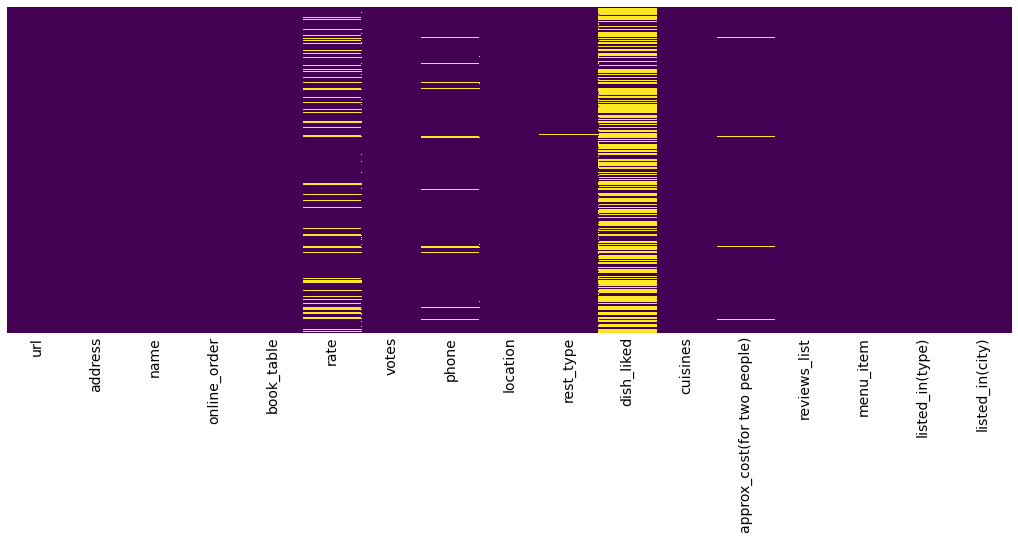

In [12]:
plt.figure(figsize=(18,6))
plt.style.use('fivethirtyeight')
sns.heatmap(zomatoDataPandas.isnull(),yticklabels=False, cbar=False, cmap= 'viridis');

## Feature Engineering ( For Pandas DataFrame )

### Feature Addition/Deletion,Feature Transformation,Feature Scaling

### Data Cleaning

#### Droping Unwanted Columns

In [13]:
# droping columns  URL,menu item
zomatoDataPandas.drop(['url','menu_item'],axis=1,inplace=True)

#### Fixing Phone Number Column and replacing the null values with Unknown

In [14]:
#fixing phone number column and changing datatype and fixing NULL values using Interpolate
zomatoDataPandas['phone'] = zomatoDataPandas['phone'].apply(lambda x:str(x).replace('+91','').replace(' ','').strip().split('\r\n')[0].strip() if '+91' or '080' in str(x) else str(x))
zomatoDataPandas['phone'] = zomatoDataPandas['phone'].replace({'nan':'Unknown'})

zomatoDataPandas['phone'] = zomatoDataPandas['phone'].apply(lambda x: '+91 ' + str(x) if (not str(x).startswith('0')) else str(x))

#### Creating Pyspark Dataframe

In [15]:
zomatoDataPyspark = spark.createDataFrame(zomatoDataPandas,final_struc)

#### Fixing Votes, Approx Cost and Rating columns

#### Using Interpolation Method to fill null Numeric Values

In [16]:
#fixing the datatypes of the columns
zomatoDataPandas['votes'] = pd.to_numeric(zomatoDataPandas['votes'])

zomatoDataPandas['approx_cost(for two people)'] = zomatoDataPandas['approx_cost(for two people)'].apply(lambda x:str(x).replace(',','') if ',' in str(x) else str(x))
zomatoDataPandas['approx_cost(for two people)'] = pd.to_numeric(zomatoDataPandas['approx_cost(for two people)'].replace({'nan':np.nan})).interpolate()
zomatoDataPandas['approx_cost(for two people)'] = zomatoDataPandas['approx_cost(for two people)'].apply(lambda x:np.round(x))

In [17]:
#creating ratings column and fixing datatype and fixing NULL values using Interpolate
zomatoDataPandas['ratingsBy5'] = zomatoDataPandas['rate'].apply(lambda x: str(x).split('/')[0])
zomatoDataPandas['ratingsBy5'] = pd.to_numeric(zomatoDataPandas['ratingsBy5'].replace('-',0).replace({'NEW': np.nan}).replace({'nan':np.nan}))
zomatoDataPandas['ratingsBy5'] = zomatoDataPandas['ratingsBy5'].interpolate()
zomatoDataPandas['ratingsBy5'] = zomatoDataPandas['ratingsBy5'].apply(lambda x: np.round(x,1))

# droping rate column
zomatoDataPandas.drop(['rate'],axis=1,inplace=True)

#data['approx_cost(for two people)'] = data['approx_cost(for two people)'].astype(int)

#### Since, missing values for Location,cuisines are less so can replace by mode and it wont make the column biased

In [18]:
zomatoDataPandas.fillna({'location':zomatoDataPandas['location'].mode().values[0]},inplace=True)

zomatoDataPandas.fillna({'cuisines':zomatoDataPandas['cuisines'].mode().values[0]},inplace=True)

#### Since, missing values are more dish_liked and rest_type so it can make column biased
#### Filling NaN values with Unknown making it a seperate category

In [19]:
zomatoDataPandas.fillna({'dish_liked':'Unknown'},inplace = True)

zomatoDataPandas.fillna({'rest_type':'Unknown'},inplace=True)

#### Checking Pandas Dataframe After performing complete Data cleaning

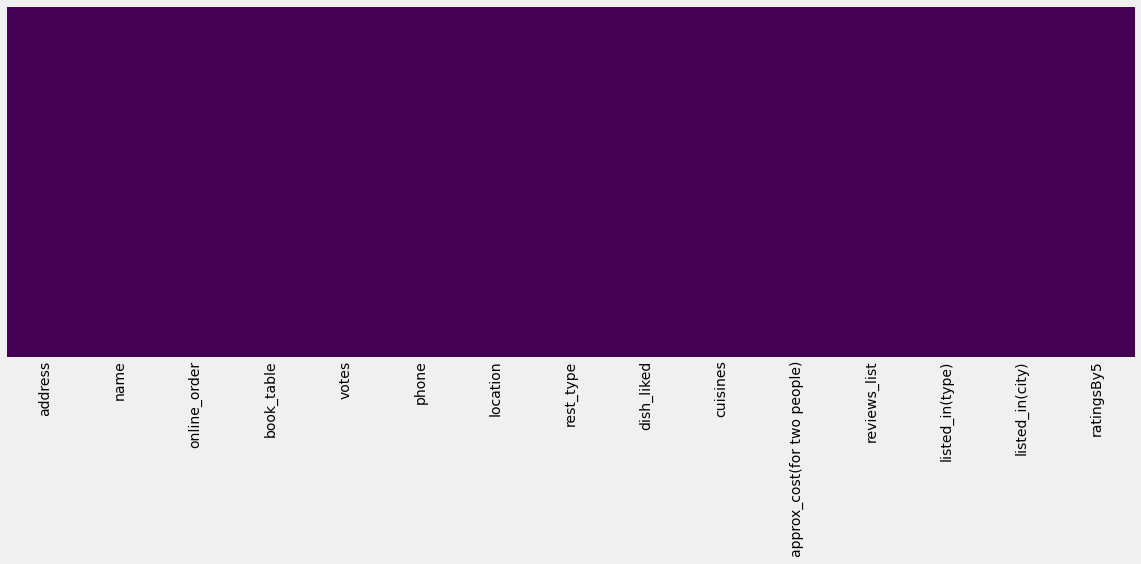

In [20]:
plt.figure(figsize=(18,6))
plt.style.use('fivethirtyeight')
sns.heatmap(zomatoDataPandas.isnull(),yticklabels=False, cbar=False, cmap= 'viridis');

## Feature Engineering ( For PySpark DataFrame )

### Feature Addition/Deletion,Feature Transformation,Feature Scaling

#### Expressing Missing Values with Percentages for each column In Pyspark Dataframe

In [21]:
# checking if any Null/Nan still exists
from pyspark.sql.functions import isnan,isnull, when, count, col

zomatoDataPyspark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in zomatoDataPyspark.columns]).toPandas()

address  name  onlineOrder  bookTable  ratingsBy5  votes  phone  location  \
0        0     0            0          0        7775      0      0        21   

   restType  dishLiked  cuisines  approx_cost(for two people)  reviewsList  \
0       227      28078        45                          346            0   

   listedInType  listedInCity  
0             0             0

### Data Cleaning

#### Fixing columns in PySpark Dataframe

In [22]:
zomatoDataPyspark = zomatoDataPyspark.withColumn('votes',zomatoDataPyspark['votes'].cast('integer'))

zomatoDataPyspark = zomatoDataPyspark.withColumn('approx_cost(for two people)',F.regexp_replace('approx_cost(for two people)',',','').cast('integer'))

zomatoDataPyspark = zomatoDataPyspark.withColumn('approx_cost(for two people)', F.round('approx_cost(for two people)'))

zomatoDataPyspark= zomatoDataPyspark.withColumn('ratingsBy5',F.trim(F.split(zomatoDataPyspark['ratingsBy5'],'/')[0]).cast('float'))

#### Replacing Numerical column Null values with mean and Categorical columns with Unknown for PySpark Dataframe.

In [23]:
zomatoDataPandas['ratingsBy5'].mean()

3.6520737861824277

In [24]:
# replacing Null values with Mean
zomatoDataPyspark = zomatoDataPyspark.fillna({'ratingsBy5':3.65})
zomatoDataPyspark = zomatoDataPyspark.withColumn('ratingsBy5', F.round('ratingsBy5',1))

In [25]:
zomatoDataPyspark.select(F.mean(zomatoDataPyspark['approx_cost(for two people)']).alias('meanCost')).show()

+-----------------+
|         meanCost|
+-----------------+
|555.4315664479959|
+-----------------+



In [26]:
zomatoDataPyspark.select(F.mean(zomatoDataPyspark['votes']).alias('meanVotes')).show()

+------------------+
|         meanVotes|
+------------------+
|283.69752692538236|
+------------------+



In [27]:
zomatoDataPyspark = zomatoDataPyspark.fillna({'approx_cost(for two people)':554.4,'votes':283.7,'location':'Unknown',\
                                              'restType':'Unknown','cuisines':'Unknown','reviewsList':'Unknown',\
                                              'listedInType':'Unknown','listedInCity':'Unknown','dishLiked':'Unknown'})

In [28]:
zomatoDataPyspark = zomatoDataPyspark.withColumn('restType',F.regexp_replace('restType','NaN','Unknown'))
zomatoDataPyspark = zomatoDataPyspark.withColumn('location',F.regexp_replace('location','NaN','Unknown'))
zomatoDataPyspark = zomatoDataPyspark.withColumn('cuisines',F.regexp_replace('cuisines','NaN','Unknown'))
zomatoDataPyspark = zomatoDataPyspark.withColumn('dishLiked',F.regexp_replace('dishLiked','NaN','Unknown'))

#### Printing Final Schema of PySpark Dataframe after data cleaning

In [29]:
zomatoDataPyspark.printSchema()

root
 |-- address: string (nullable = true)
 |-- name: string (nullable = true)
 |-- onlineOrder: string (nullable = true)
 |-- bookTable: string (nullable = true)
 |-- ratingsBy5: float (nullable = true)
 |-- votes: integer (nullable = true)
 |-- phone: string (nullable = true)
 |-- location: string (nullable = false)
 |-- restType: string (nullable = false)
 |-- dishLiked: string (nullable = false)
 |-- cuisines: string (nullable = false)
 |-- approx_cost(for two people): integer (nullable = true)
 |-- reviewsList: string (nullable = false)
 |-- listedInType: string (nullable = false)
 |-- listedInCity: string (nullable = false)



#### Checking PySpark Dataframe After performing complete Data cleaning

In [30]:
# checking if any Null/Nan still exists
from pyspark.sql.functions import isnan,isnull, when, count, col
zomatoDataPyspark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in zomatoDataPyspark.columns]).toPandas().head()

address  name  onlineOrder  bookTable  ratingsBy5  votes  phone  location  \
0        0     0            0          0           0      0      0         0   

   restType  dishLiked  cuisines  approx_cost(for two people)  reviewsList  \
0         0          0         0                            0            0   

   listedInType  listedInCity  
0             0             0

#### Dropping Duplicates in both Dataframes

In [31]:
# Droping Duplicate rows
s1= time.time()
zomatoDataPandas = zomatoDataPandas.drop_duplicates()
s2 = time.time()

p1 = time.time()
zomatoDataPyspark = zomatoDataPyspark.drop_duplicates()
p2 = time.time()

print("Time taken by Pandas to drop duplicates is: {0} sec".format(np.round(p2-p1,3)))
print("Time taken by PySpark to drop duplicates is: {0} sec".format(np.round(s2-s1,3)))

zomatoDataPandas.shape

Time taken by Pandas to drop duplicates is: 0.023 sec
Time taken by PySpark to drop duplicates is: 1.218 sec


(51686, 15)

#### Renaming Column names for better readability 

In [32]:
zomatoDataPandas.columns =['address', 'name', 'onlineOrder', 'bookTable', 'votes', 'phone',
       'location', 'restType', 'dishLiked', 'cuisines',
       'approxCost(2 people)', 'reviewsList', 'listedInType',
       'listedInCity', 'ratingsBy5']


# Fixing column order in better way
zomatoDataPandas = zomatoDataPandas[['name','address','location','phone','onlineOrder', 'bookTable', 'votes',
       'restType', 'dishLiked', 'cuisines',
       'approxCost(2 people)', 'reviewsList', 'listedInType',
       'listedInCity', 'ratingsBy5']]

In [33]:
zomatoDataPyspark = zomatoDataPyspark.withColumnRenamed('approx_cost(for two people)','approxCost(2 people)')

# Fixing column order in better way
zomatoDataPyspark = zomatoDataPyspark.select(['name','address','location','phone','onlineOrder', 'bookTable', 'votes',
       'restType', 'dishLiked', 'cuisines',
       'approxCost(2 people)', 'reviewsList', 'listedInType',
       'listedInCity', 'ratingsBy5'])

* ##### *Persisting zomatoDataPyspark Dataframe in memory for performing performance in furture operations*

In [34]:
zomatoDataPyspark = zomatoDataPyspark.persist()

In [35]:
zomatoDataPandas.head(5)

name                                            address  \
0                  Jalsa  942, 21st Main Road, 2nd Stage, Banashankari, ...   
1         Spice Elephant  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...   
2        San Churro Cafe  1112, Next to KIMS Medical College, 17th Cross...   
3  Addhuri Udupi Bhojana  1st Floor, Annakuteera, 3rd Stage, Banashankar...   
4          Grand Village  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...   

       location           phone onlineOrder bookTable  votes  \
0  Banashankari     08042297555         Yes       Yes    775   
1  Banashankari     08041714161         Yes        No    787   
2  Banashankari  +91 9663487993         Yes        No    918   
3  Banashankari  +91 9620009302          No        No     88   
4  Basavanagudi  +91 8026612447          No        No    166   

              restType                                          dishLiked  \
0        Casual Dining  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1        Casual Dining  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Cafe, Casual Dining  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3          Quick Bites                                        Masala Dosa   
4        Casual Dining                                Panipuri, Gol Gappe   

                         cuisines  approxCost(2 people)  \
0  North Indian, Mughlai, Chinese                 800.0   
1     Chinese, North Indian, Thai                 800.0   
2          Cafe, Mexican, Italian                 800.0   
3      South Indian, North Indian                 300.0   
4        North Indian, Rajasthani                 600.0   

                                         reviewsList listedInType  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...       Buffet   
1  [('Rated 4.0', 'RATED\n  Had been here for din...       Buffet   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...       Buffet   
3  [('Rated 4.0', "RATED\n  Great food and proper...       Buffet   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...       Buffet   

   listedInCity  ratingsBy5  
0  Banashankari         4.1  
1  Banashankari         4.1  
2  Banashankari         3.8  
3  Banashankari         3.7  
4  Banashankari         3.8

In [36]:
zomatoDataPandas.describe()
zomatoDataPyspark.describe(['location','votes','approxCost(2 people)','ratingsBy5','restType','listedInType','cuisines']).show()

votes  approxCost(2 people)    ratingsBy5
count  51686.000000          51686.000000  51686.000000
mean     283.759567            555.650853      3.652076
std      804.038709            438.847308      0.447455
min        0.000000             40.000000      0.000000
25%        7.000000            300.000000      3.400000
50%       41.000000            400.000000      3.700000
75%      198.000000            650.000000      4.000000
max    16832.000000           6000.000000      4.900000

+-------+-----------+-----------------+--------------------+-------------------+--------+-------------+--------------------+
|summary|   location|            votes|approxCost(2 people)|         ratingsBy5|restType| listedInType|            cuisines|
+-------+-----------+-----------------+--------------------+-------------------+--------+-------------+--------------------+
|  count|      51667|            51667|               51667|              51667|   51667|        51667|               51667|
|   mean|       null|283.8503687072987|   555.4542551338378| 3.7003754879771344|    null|         null|                null|
| stddev|       null|804.1670052025419|   437.4373964340692|0.39548101308668593|    null|         null|                null|
|    min|        BTM|                0|                  40|                1.8|  Bakery|       Buffet|     African, Burger|
|    max|Yeshwantpur|            16832|                6000|                4.9| Unknown|Pubs and bars|Vietnamese, Thai,...|


#### We can see from the mean and standard deviation of votes and cost that the variation of both these are very highly distributed away from the mean.

#### possiblity of outliers are there.

## Removing Ouliers

* #### Using Normalization Method for Pandas Dataframe.

In [37]:
zomatoDataPandas_withoutOutliers = zomatoDataPandas.copy()

In [38]:
zomatoDataPyspark_withoutOutliers = zomatoDataPyspark

In [39]:
print("Skewness of votes",zomatoDataPandas_withoutOutliers['votes'].skew())
print("Skewness of ratings",zomatoDataPandas_withoutOutliers['ratingsBy5'].skew())
print("Skeness of cost",zomatoDataPandas_withoutOutliers['approxCost(2 people)'].skew())

Skewness of votes 7.546416795038646
Skewness of ratings -0.825910963933893
Skeness of cost 2.5991511583676954


In [40]:
zomatoDataPyspark_withoutOutliers.agg(F.skewness(zomatoDataPyspark_withoutOutliers['votes']).alias("Skewness of Votes"),\
                                      F.skewness(zomatoDataPyspark_withoutOutliers['ratingsBy5']).alias("Skewness of Ratings"),\
                                      F.skewness(zomatoDataPyspark_withoutOutliers['approxCost(2 people)']).alias("Skewness of Cost")\
                                     ).show()

+-----------------+-------------------+------------------+
|Skewness of Votes|Skewness of Ratings|  Skewness of Cost|
+-----------------+-------------------+------------------+
|7.545034291660275|-0.3655811721466426|2.6110341830530435|
+-----------------+-------------------+------------------+



### 1) ratingsBy5

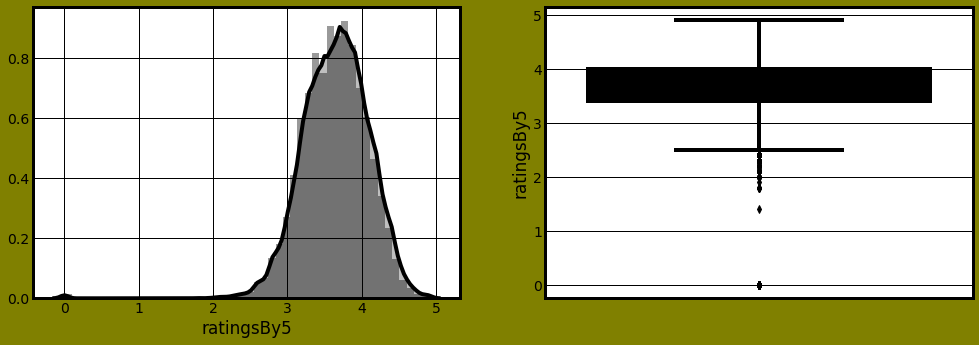

In [41]:
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('olive')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatoDataPandas_withoutOutliers['ratingsBy5'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatoDataPandas_withoutOutliers['ratingsBy5']);

The Histogram is nearly right skewed.
We can see there are some Outliers in Ratings so, we have to fix that using 

### ***Using Normalization Techniques***

Using Inter Quantile Range Method / Standard Devaition method to fix outliers

In [42]:
IQR = zomatoDataPandas_withoutOutliers['ratingsBy5'].quantile(0.75) - zomatoDataPandas_withoutOutliers['ratingsBy5'].quantile(0.25)

Lower_fence = zomatoDataPandas_withoutOutliers['ratingsBy5'].quantile(0.25) - (IQR * 1.5)
Upper_fence = zomatoDataPandas_withoutOutliers['ratingsBy5'].quantile(0.75) + (IQR * 1.5)

print("Upper Bound:- {0} ,Lower Bound:- {1} , IQR:- {2} ".format(round(Upper_fence,2),round(Lower_fence,2), round(IQR,2)))
# lets look at the actual number of passengers on the upper Fare ranges

print('total rating: {}'.format(zomatoDataPandas_withoutOutliers['ratingsBy5'].shape[0]))

print('ratings more than 5.05: {}'.format(
    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['ratingsBy5'] > 5].shape[0]))

print('ratings less that 2.25: {}'.format(
    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['ratingsBy5'] < 2.25].shape[0]))

Upper Bound:- 4.9 ,Lower Bound:- 2.5 , IQR:- 0.6 
total rating: 51686
ratings more than 5.05: 0
ratings less that 2.25: 137


In [43]:
# Let's calculate the boundaries outside which sit the outliers
# assuming Age follows a Gaussian distribution

Upper_boundary = zomatoDataPandas_withoutOutliers['ratingsBy5'].mean() + 3* zomatoDataPandas_withoutOutliers['ratingsBy5'].std()
Lower_boundary = zomatoDataPandas_withoutOutliers['ratingsBy5'].mean() - 3* zomatoDataPandas_withoutOutliers['ratingsBy5'].std()

Upper_boundary, Lower_boundary
print("Upper_boundary:- {0} , Lower_boundary:- {1}".format(round(Upper_boundary,2),round(Lower_boundary,2)))
print('total rating: {}'.format(zomatoDataPandas_withoutOutliers['ratingsBy5'].shape[0]))

print('ratings more than 5.02: {}'.format(
    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['ratingsBy5'] > 5].shape[0]))

print('ratings less that 2.27: {}'.format(
    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['ratingsBy5'] < 2.27].shape[0]))

(4.994440314583212, 2.309711680154107)

Upper_boundary:- 4.99 , Lower_boundary:- 2.31
total rating: 51686
ratings more than 5.02: 0
ratings less that 2.27: 137


#### We can see there are no values greater than Upper Bound but many values are less than Lower Bound

In [44]:
# total rows where outliers are there
len(zomatoDataPandas_withoutOutliers.loc[~(zomatoDataPandas_withoutOutliers['ratingsBy5']>Lower_boundary) & (zomatoDataPandas_withoutOutliers['ratingsBy5']<Upper_boundary)])

190

In [45]:
# replacing outliers values (values less than lower bound i.e 2.27) with median
zomatoDataPandas_withoutOutliers['ratingsBy5'] = np.where(zomatoDataPandas_withoutOutliers['ratingsBy5'] < Lower_boundary,zomatoDataPandas_withoutOutliers['ratingsBy5'].median(),zomatoDataPandas_withoutOutliers['ratingsBy5'])

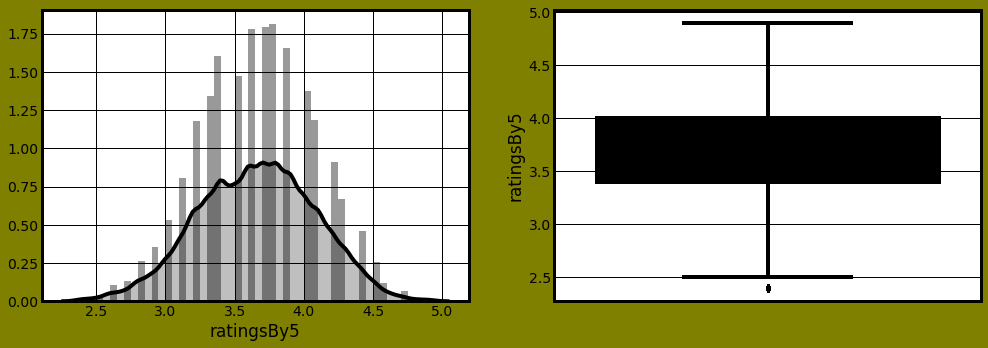

In [46]:
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('olive')
plt.style.use('grayscale')

plt.subplot(121)
sns.distplot(zomatoDataPandas_withoutOutliers['ratingsBy5'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatoDataPandas_withoutOutliers['ratingsBy5']);

### We can see the distribution is normal now and all outliers are removed.

### 2) approxCost(2 people)

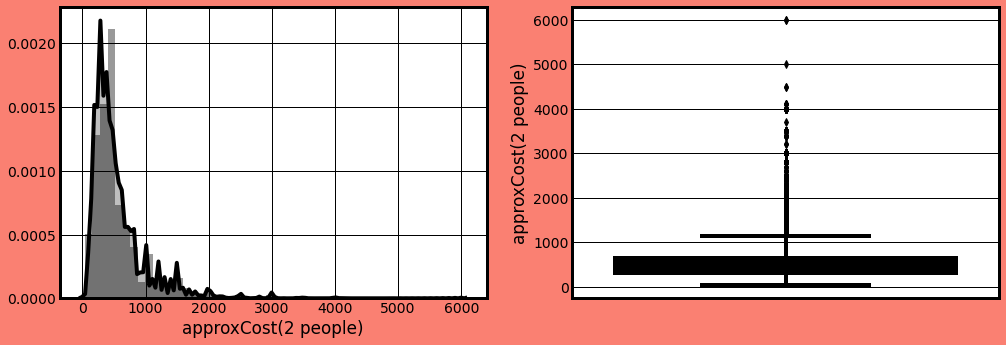

In [47]:
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('salmon')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatoDataPandas_withoutOutliers['approxCost(2 people)'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatoDataPandas_withoutOutliers['approxCost(2 people)']);

### We can see there are lot of outliers and 

In [48]:
IQR = zomatoDataPandas_withoutOutliers['approxCost(2 people)'].quantile(0.75) - zomatoDataPandas_withoutOutliers['approxCost(2 people)'].quantile(0.25)

Lower_fence = zomatoDataPandas_withoutOutliers['approxCost(2 people)'].quantile(0.25) - (IQR * 1.5)
Upper_fence = zomatoDataPandas_withoutOutliers['approxCost(2 people)'].quantile(0.75) + (IQR * 1.5)

print("Upper Bound:- {0} ,Lower Bound:- {1} , IQR:- {2} ".format(round(Upper_fence,2),round(Lower_fence,2), round(IQR,2)))
# lets look at the actual number of passengers on the upper Fare ranges

print('total people paying: {}'.format(zomatoDataPandas_withoutOutliers['approxCost(2 people)'].shape[0]))

print('cost more than {0}: {1}'.format(round(Upper_fence,2),
    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['approxCost(2 people)'] > Upper_fence].shape[0]))

print('cost more that {0}: {1}'.format(round(Lower_fence,2),
    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['approxCost(2 people)'] < Lower_fence].shape[0]))

Upper Bound:- 1175.0 ,Lower Bound:- -225.0 , IQR:- 350.0 
total people paying: 51686
cost more than 1175.0: 4795
cost more that -225.0: 0


The lower boundary is meaningless because there can't be a negative price for food

In [49]:
len(zomatoDataPandas_withoutOutliers.loc[~((zomatoDataPandas_withoutOutliers['approxCost(2 people)']>Lower_fence) & (zomatoDataPandas_withoutOutliers['approxCost(2 people)'] <Upper_fence))])

4795

In [50]:
# replacing outliers values (values more than upper bound i.e 1873) with median
zomatoDataPandas_withoutOutliers['approxCost(2 people)'] = np.where(zomatoDataPandas_withoutOutliers['approxCost(2 people)'] > Upper_fence,zomatoDataPandas_withoutOutliers['approxCost(2 people)'].median(),zomatoDataPandas_withoutOutliers['approxCost(2 people)'])

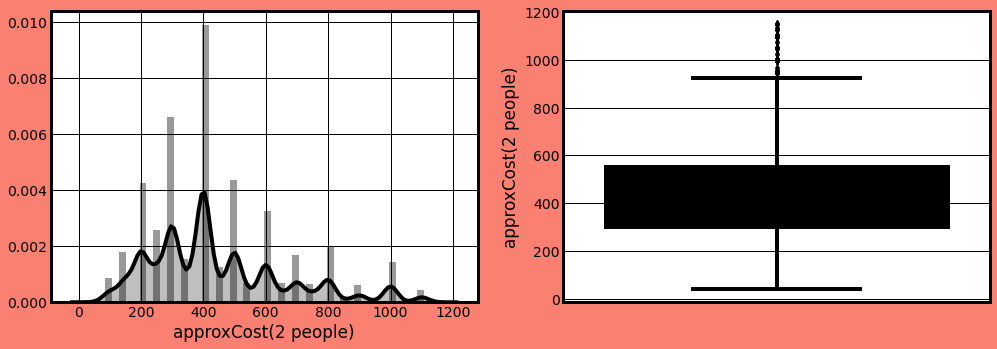

In [51]:
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('salmon')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatoDataPandas_withoutOutliers['approxCost(2 people)'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatoDataPandas_withoutOutliers['approxCost(2 people)']);

### 3)votes

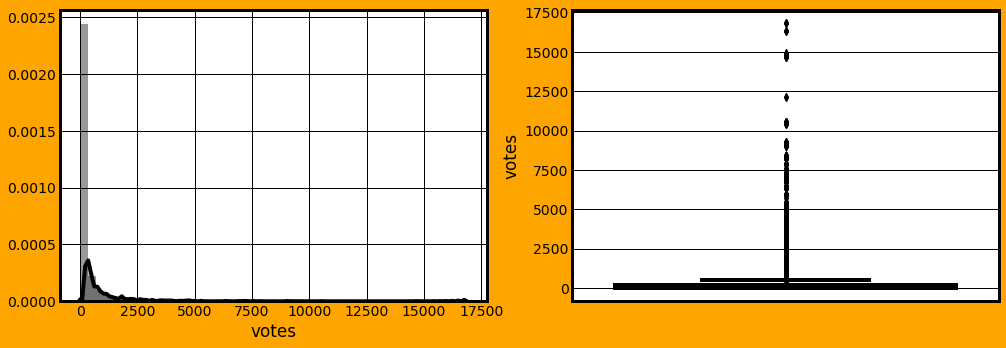

In [52]:
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('orange')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatoDataPandas_withoutOutliers['votes'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatoDataPandas_withoutOutliers['votes']);

In [53]:
IQR = zomatoDataPandas_withoutOutliers['votes'].quantile(0.75) - zomatoDataPandas_withoutOutliers['votes'].quantile(0.25)

Lower_fence = zomatoDataPandas_withoutOutliers['votes'].quantile(0.25) - (IQR * 3)
Upper_fence = zomatoDataPandas_withoutOutliers['votes'].quantile(0.75) + (IQR * 3)

print("Upper Bound:- {0} ,Lower Bound:- {1} , IQR:- {2} ".format(round(Upper_fence,2),round(Lower_fence,2), round(IQR,2)))
# lets look at the actual number of passengers on the upper Fare ranges

print('total people voted: {}'.format(zomatoDataPandas_withoutOutliers['votes'].shape[0]))

print('vote count more than {0}: {1}'.format(round(Upper_fence,2),
    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['votes'] > Upper_fence].shape[0]))

print('vote count more that {0}: {1}'.format(round(Lower_fence,2),
    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['votes'] < Lower_fence].shape[0]))

Upper Bound:- 771.0 ,Lower Bound:- -566.0 , IQR:- 191.0 
total people voted: 51686
vote count more than 771.0: 4745
vote count more that -566.0: 0


In [54]:
# Let's calculate the boundaries outside which sit the outliers
# assuming Age follows a Gaussian distribution

Upper_boundary = zomatoDataPandas_withoutOutliers['votes'].mean() + 3* zomatoDataPandas_withoutOutliers['votes'].std()
Lower_boundary = zomatoDataPandas_withoutOutliers['votes'].mean() - 3* zomatoDataPandas_withoutOutliers['votes'].std()

Upper_boundary, Lower_boundary
print("Upper_boundary:- {0} , Lower_boundary:- {1}".format(round(Upper_boundary,2),round(Lower_boundary,2)))
print('total rating: {}'.format(zomatoDataPandas_withoutOutliers['votes'].shape[0]))

#print('ratings more than 5.02: {}'.format(
#    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['votes'] > 5].shape[0]))

#print('ratings less that 2.27: {}'.format(
#    zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['votes'] < 2.27].shape[0]))

(2695.8756951399428, -2128.3565603645684)

Upper_boundary:- 2695.88 , Lower_boundary:- -2128.36
total rating: 51686


In [55]:
zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['votes'] >936.84].shape[0]

3899

In [56]:
len(zomatoDataPandas_withoutOutliers.loc[~((zomatoDataPandas_withoutOutliers['votes'] <Upper_fence))])

4755

In [57]:
# replacing outliers values (values more than upper bound i.e 1873) with median
zomatoDataPandas_withoutOutliers['votes'] = np.where(zomatoDataPandas_withoutOutliers['votes'] > Upper_fence,zomatoDataPandas_withoutOutliers['votes'].median(),zomatoDataPandas_withoutOutliers['votes'])
#zomatoDataPandas_withoutOutliers.loc[zomatoDataPandas_withoutOutliers['votes'] > 500,'votes'] = Upper_fence

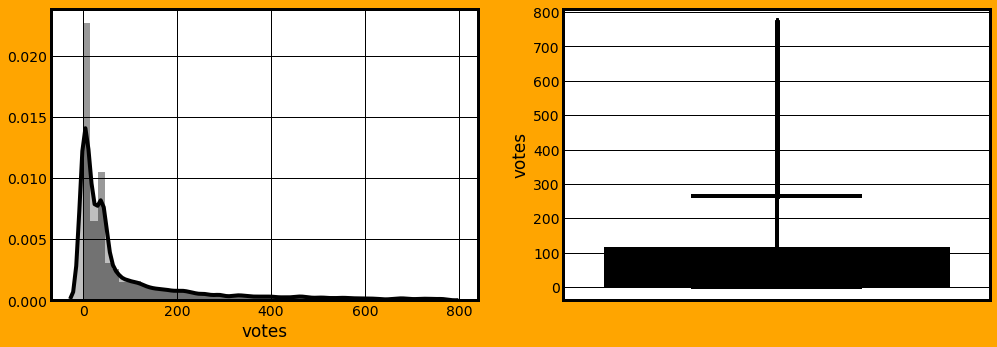

In [58]:
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('orange')
plt.style.use('grayscale')
plt.subplot(121)
sns.distplot(zomatoDataPandas_withoutOutliers['votes'],kde_kws={"shade": True})
plt.subplot(122)
sns.boxplot(y=zomatoDataPandas_withoutOutliers['votes']);

In [59]:
print("Skewness of votes",zomatoDataPandas_withoutOutliers['votes'].skew())
print("Skewness of ratings",zomatoDataPandas_withoutOutliers['ratingsBy5'].skew())
print("Skeness of cost",zomatoDataPandas_withoutOutliers['approxCost(2 people)'].skew())

Skewness of votes 2.3140598654342517
Skewness of ratings -0.07731057172120843
Skeness of cost 0.941990437198608


### Feature Scaling

* #### Using Standardization for PySpark DataFrame

In [60]:
zomatoDataPyspark_withoutOutliers = zomatoDataPyspark_withoutOutliers.withColumn('votes',F.sqrt(F.cbrt(zomatoDataPyspark_withoutOutliers['votes'])))

zomatoDataPyspark_withoutOutliers = zomatoDataPyspark_withoutOutliers.withColumn('approxCost(2 people)',F.cbrt(F.cbrt(F.cbrt(F.cbrt(zomatoDataPyspark_withoutOutliers['approxCost(2 people)'])))))

In [61]:
zomatoDataPyspark_withoutOutliers.agg(F.skewness(zomatoDataPyspark_withoutOutliers['votes']).alias("Skewness of Votes"),\
                                      F.skewness(zomatoDataPyspark_withoutOutliers['ratingsBy5']).alias("Skewness of Ratings"),\
                                      F.skewness(zomatoDataPyspark_withoutOutliers['approxCost(2 people)']).alias("Skewness of Cost")\
                                     ).show()

+------------------+-------------------+------------------+
| Skewness of Votes|Skewness of Ratings|  Skewness of Cost|
+------------------+-------------------+------------------+
|-0.313947811712294|-0.3655811721466426|0.2937976541953225|
+------------------+-------------------+------------------+



In [62]:
zomatoDataPyspark_withoutOutliers = zomatoDataPyspark_withoutOutliers.withColumn('approxCost(2 people)', F.round('approxCost(2 people)',2))
zomatoDataPyspark_withoutOutliers = zomatoDataPyspark_withoutOutliers.withColumn('votes', F.round('votes',1))

In [63]:
zomatoDataPyspark_withoutOutliers = zomatoDataPyspark_withoutOutliers.persist()

In [64]:
# Creating Dataset for ML model
# Performing 1 hot encoding for onlineOrder and bookTable
zomatoDataForMLModel = zomatoDataPandas_withoutOutliers.copy()

zomatoDataForMLModel['onlineOrder'] = zomatoDataForMLModel['onlineOrder'].replace({'Yes':1,'No':0})
zomatoDataForMLModel['bookTable'] = zomatoDataForMLModel['bookTable'].replace({'Yes':1,'No':0})


In [65]:
zomatoDataForMLModel.head(2)

name                                            address  \
0           Jalsa  942, 21st Main Road, 2nd Stage, Banashankari, ...   
1  Spice Elephant  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...   

       location        phone  onlineOrder  bookTable  votes       restType  \
0  Banashankari  08042297555            1          1   41.0  Casual Dining   
1  Banashankari  08041714161            1          0   41.0  Casual Dining   

                                           dishLiked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   

                         cuisines  approxCost(2 people)  \
0  North Indian, Mughlai, Chinese                 800.0   
1     Chinese, North Indian, Thai                 800.0   

                                         reviewsList listedInType  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...       Buffet   
1  [('Rated 4.0', 'RATED\n  Had been here for din...       Buffet   

   listedInCity  ratingsBy5  
0  Banashankari         4.1  
1  Banashankari         4.1

In [66]:
#Encode the input Variables
def Encode(zomato):
    for column in zomato.columns[zomato.columns.isin(['listedInType','listedInCity', 'location'])]:
        zomato[column] = zomato[column].factorize()[0]
    return zomato

zomatoDataForMLModel = Encode(zomatoDataForMLModel)

In [67]:
# Standardizing votes and approxCost(2 people) values
zomatoDataForMLModel['votes'] = np.sqrt(zomatoDataForMLModel['votes']);
zomatoDataForMLModel['approxCost(2 people)'] =np.sqrt(np.sqrt(np.sqrt(zomatoDataForMLModel['approxCost(2 people)'])))

In [68]:
zomatoDataForMLModel.head(1)

name                                            address  location  \
0  Jalsa  942, 21st Main Road, 2nd Stage, Banashankari, ...         0   

         phone  onlineOrder  bookTable     votes       restType  \
0  08042297555            1          1  6.403124  Casual Dining   

                                           dishLiked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   

                         cuisines  approxCost(2 people)  \
0  North Indian, Mughlai, Chinese              2.306143   

                                         reviewsList  listedInType  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...             0   

   listedInCity  ratingsBy5  
0             0         4.1

In [69]:
def Encode(zomato):
    for column in zomato.columns[zomato.columns.isin(['name', 'address', 'restType','dishLiked','cuisines','reviewsList'])]:
        zomato[column] = zomato[column].factorize()[0]
    return zomato

zomatoDataForMLModel = Encode(zomatoDataForMLModel)

In [70]:
# droping Phone column as it is of no use
zomatoDataForMLModel = zomatoDataForMLModel.drop('phone',axis=1)

In [71]:
#formatting the votes and approxCost values
zomatoDataForMLModel['votes'] = zomatoDataForMLModel['votes'].apply(lambda x: np.round(x,1))
zomatoDataForMLModel['approxCost(2 people)'] = zomatoDataForMLModel['approxCost(2 people)'].apply(lambda x: np.round(x,1))

In [72]:
# looking at the dataset after transformation
zomatoDataForMLModel.head(5)

name  address  location  onlineOrder  bookTable  votes  restType  \
0     0        0         0            1          1    6.4         0   
1     1        1         0            1          0    6.4         0   
2     2        2         0            1          0    6.4         1   
3     3        3         0            0          0    9.4         2   
4     4        4         1            0          0   12.9         0   

   dishLiked  cuisines  approxCost(2 people)  reviewsList  listedInType  \
0          0         0                   2.3            0             0   
1          1         1                   2.3            1             0   
2          2         2                   2.3            2             0   
3          3         3                   2.0            3             0   
4          4         4                   2.2            4             0   

   listedInCity  ratingsBy5  
0             0         4.1  
1             0         4.1  
2             0         3.8  
3             0         3.7  
4             0         3.8

In [73]:
#zomatoDataForMLModel['name'] = np.sqrt(zomatoDataForMLModel['name'])
#zomatoDataForMLModel['address'] = np.sqrt(zomatoDataForMLModel['address'])
zomatoDataForMLModel['location'] = np.sqrt(zomatoDataForMLModel['location'])
#zomatoDataForMLModel['restType'] = np.sqrt(np.sqrt(zomatoDataForMLModel['restType']))
zomatoDataForMLModel['dishLiked'] = np.cbrt(np.cbrt(np.sqrt(np.sqrt(zomatoDataForMLModel['dishLiked']))))
#zomatoDataForMLModel['cuisines'] = np.sqrt(np.cbrt(zomatoDataForMLModel['cuisines']))
#zomatoDataForMLModel['reviewsList'] = np.sqrt(zomatoDataForMLModel['reviewsList'])

In [74]:
# looking at the correlation after transformation
zomatoDataForMLModel.corr()

name   address  location  onlineOrder  bookTable  \
name                  1.000000  0.695848  0.432851    -0.265681   0.015746   
address               0.695848  1.000000  0.568690    -0.189662  -0.029411   
location              0.432851  0.568690  1.000000    -0.056066   0.045248   
onlineOrder          -0.265681 -0.189662 -0.056066     1.000000   0.001010   
bookTable             0.015746 -0.029411  0.045248     0.001010   1.000000   
votes                -0.139936 -0.070803  0.032624     0.257010   0.277744   
restType              0.013080  0.017258  0.065625    -0.100435   0.221420   
dishLiked            -0.049732  0.049325  0.139937     0.172707   0.377652   
cuisines              0.257835  0.200384  0.185664    -0.016530   0.234520   
approxCost(2 people) -0.050688 -0.030775  0.052914     0.093093   0.263416   
reviewsList           0.233101  0.397227  0.357370     0.074867   0.179188   
listedInType          0.119599  0.091486  0.043995    -0.226293   0.105177   
listedInCity          0.301048  0.414221  0.383866    -0.053450   0.025084   
ratingsBy5           -0.070303 -0.053647  0.039561     0.139112   0.431817   

                         votes  restType  dishLiked  cuisines  \
name                 -0.139936  0.013080  -0.049732  0.257835   
address              -0.070803  0.017258   0.049325  0.200384   
location              0.032624  0.065625   0.139937  0.185664   
onlineOrder           0.257010 -0.100435   0.172707 -0.016530   
bookTable             0.277744  0.221420   0.377652  0.234520   
votes                 1.000000  0.034276   0.687526  0.147961   
restType              0.034276  1.000000   0.127034  0.156411   
dishLiked             0.687526  0.127034   1.000000  0.245484   
cuisines              0.147961  0.156411   0.245484  1.000000   
approxCost(2 people)  0.331628  0.003004   0.356524  0.192765   
reviewsList           0.293978  0.088366   0.372542  0.202183   
listedInType          0.009388  0.123597   0.050041  0.075266   
listedInCity          0.006359  0.042068   0.091284  0.121428   
ratingsBy5            0.419149  0.184884   0.542127  0.199426   

                      approxCost(2 people)  reviewsList  listedInType  \
name                             -0.050688     0.233101      0.119599   
address                          -0.030775     0.397227      0.091486   
location                          0.052914     0.357370      0.043995   
onlineOrder                       0.093093     0.074867     -0.226293   
bookTable                         0.263416     0.179188      0.105177   
votes                             0.331628     0.293978      0.009388   
restType                          0.003004     0.088366      0.123597   
dishLiked                         0.356524     0.372542      0.050041   
cuisines                          0.192765     0.202183      0.075266   
approxCost(2 people)              1.000000     0.179394      0.005566   
reviewsList                       0.179394     1.000000      0.062296   
listedInType                      0.005566     0.062296      1.000000   
listedInCity                      0.017455     0.613104      0.030836   
ratingsBy5                        0.208990     0.226826      0.015731   

                      listedInCity  ratingsBy5  
name                      0.301048   -0.070303  
address                   0.414221   -0.053647  
location                  0.383866    0.039561  
onlineOrder              -0.053450    0.139112  
bookTable                 0.025084    0.431817  
votes                     0.006359    0.419149  
restType                  0.042068    0.184884  
dishLiked                 0.091284    0.542127  
cuisines                  0.121428    0.199426  
approxCost(2 people)      0.017455    0.208990  
reviewsList               0.613104    0.226826  
listedInType              0.030836    0.015731  
listedInCity              1.000000    0.019697  
ratingsBy5                0.019697    1.000000

<Figure size 1080x576 with 0 Axes>

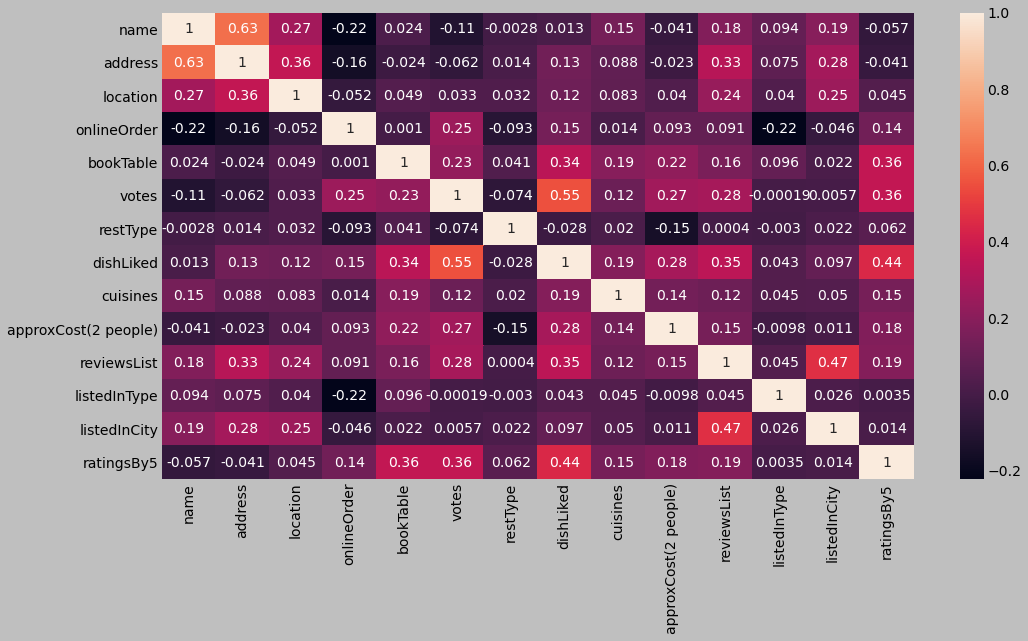

In [75]:
fig = plt.figure(figsize=(15,8))
fig.patch.set_facecolor('plum')

corr = zomatoDataForMLModel.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
zomatoDataForMLModel.columns;

In [76]:
zomatoDataForMLModel.columns.to_flat_index()

Index(['name', 'address', 'location', 'onlineOrder', 'bookTable', 'votes',
       'restType', 'dishLiked', 'cuisines', 'approxCost(2 people)',
       'reviewsList', 'listedInType', 'listedInCity', 'ratingsBy5'],
      dtype='object')

In [77]:
#Defining the independent variables and dependent variables
x = zomatoDataForMLModel.iloc[:,[2,3,4,5,6,8,9]]
y = zomatoDataForMLModel['ratingsBy5']

#Getting Test and Training Set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=353)
x_train.head()

location  onlineOrder  bookTable  votes  restType  cuisines  \
34021  4.795832            1          1   22.0         0       233   
25060  8.485281            1          0    4.4         2        33   
38675  6.082763            0          1   13.9        14      1200   
2714   1.732051            1          0    0.0        12        26   
24728  8.717798            0          0    8.4         0      1976   

       approxCost(2 people)  
34021                   2.3  
25060                   2.1  
38675                   2.1  
2714                    2.1  
24728                   2.2

In [78]:
#Prepare a Linear Regression Model
reg=LinearRegression()
reg.fit(x_train,y_train)
y_pred=reg.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

0.3113736421261024

In [79]:
#Prepairng a Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=105)
DTree=DecisionTreeRegressor(min_samples_leaf=.0001)
DTree.fit(x_train,y_train)
y_predict=DTree.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test,y_predict)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.0001, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

0.7619823019625624

In [80]:
#Preparing Random Forest REgression
from sklearn.ensemble import RandomForestRegressor
RForest=RandomForestRegressor(n_estimators=500,random_state=329,min_samples_leaf=.0001)
RForest.fit(x_train,y_train)
y_predict=RForest.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test,y_predict)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.0001,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=329, verbose=0, warm_start=False)

0.8023956431422005

In [81]:
#Preparing Extra Tree Regression
from sklearn.ensemble import  ExtraTreesRegressor
ETree=ExtraTreesRegressor(n_estimators = 100)
ETree.fit(x_train,y_train)
y_predict=ETree.predict(x_test)


from sklearn.metrics import r2_score
r2_score(y_test,y_predict)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

0.8652152675506356

* **As per the dataset Size, so we can reduce the number of write partition from default 200 to 10 to speed up the processing**

In [82]:
zomatoDataPyspark_withoutOutliers = zomatoDataPyspark_withoutOutliers.persist()
spark.conf.set("spark.sql.shuffle.partitions",10)

### 1. Top 10 Popular Location from where the customer often order/visit for food.

#### Using Pandas

In [83]:
# location
s1= time.time()

top_10_location = zomatoDataPandas_withoutOutliers['location'].value_counts().reset_index().head(10)
top_10_location.index = np.arange(1, len(top_10_location)+1)
top_10_location.columns =['location','count']
top_10_location

s2 = time.time()
print("Time taken by Pandas to run Query: {0} sec".format(np.round(s2-s1,3)))

location  count
1                     BTM   5139
2                     HSR   2523
3   Koramangala 5th Block   2503
4                JP Nagar   2235
5              Whitefield   2144
6             Indiranagar   2083
7               Jayanagar   1926
8            Marathahalli   1846
9       Bannerghatta Road   1630
10              Bellandur   1286

Time taken by Pandas to run Query: 0.033 sec


In [84]:
#Creating a temporary table to write Sql Queries on it
zomatoDataPyspark_withoutOutliers.createOrReplaceTempView("zomatoData")

#### Using PySpark

In [85]:
s1= time.time()
Top10Location = zomatoDataPyspark_withoutOutliers.groupBy('location').count().orderBy('count',ascending=False)
Top10Location = Top10Location.persist()

Top10Location.show(10)
s2 = time.time()

print("Time taken by PySpark to to run Query: {0} sec".format(np.round(s2-s1,3)))

+--------------------+-----+
|            location|count|
+--------------------+-----+
|                 BTM| 5114|
|                 HSR| 2522|
|Koramangala 5th B...| 2503|
|            JP Nagar| 2234|
|          Whitefield| 2142|
|         Indiranagar| 2081|
|           Jayanagar| 1926|
|        Marathahalli| 1846|
|   Bannerghatta Road| 1630|
|           Bellandur| 1286|
+--------------------+-----+
only showing top 10 rows

Time taken by PySpark to to run Query: 8.931 sec


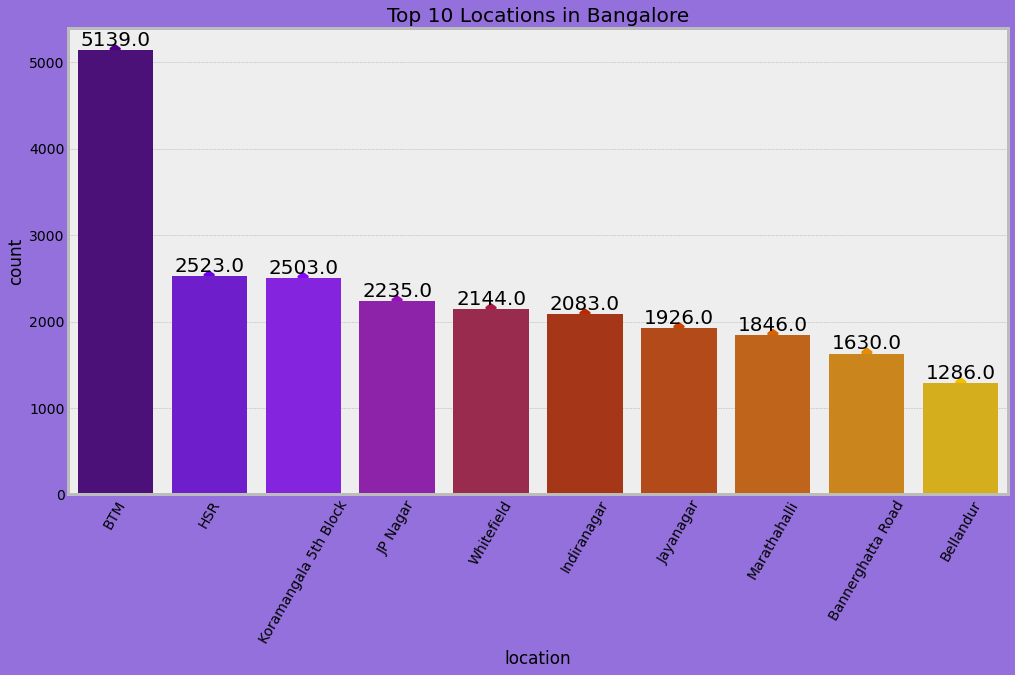

In [86]:
fig = plt.figure(figsize=(15,8))
fig.patch.set_facecolor('mediumpurple')
plt.style.use('bmh')

ax = sns.barplot(data=top_10_location,x='location',y='count', palette='gnuplot')
sns.pointplot(data=top_10_location,x='location',y='count', palette='gnuplot',alpha=0.8,markers='p',linestyles='dashed')
sns.set_context(rc = {'patch.linewidth': 0.9})

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=20);
plt.title("Top 10 Locations in Bangalore");
plt.xticks(rotation=60);

WE OBSERVE THE FOLLOWING:

-----
1. If you are trying to open a new foodchain then locations with most number of unique restaurants can be helpful. It looks like people prefer to open new restaurants in these locations before moving to locations like Kormangala.

2. Whitefield tops the chart and it maked sense also. It's a newly established locality filled with working professionals. As it's little bit far away from central bangalore, you might not need to pay hefty amount to start a business.

### 2) How many brands are there in the business?

In [87]:
unique_brands = zomatoDataPandas_withoutOutliers.name.unique()
print(f'{len(unique_brands)} brands are in the business.')

8792 brands are in the business.


In [88]:
zomatoDataPyspark_withoutOutliers.select(F.countDistinct(zomatoDataPyspark_withoutOutliers['name']).alias("Distinct Brands in business")).show()

+---------------------------+
|Distinct Brands in business|
+---------------------------+
|                       8792|
+---------------------------+



WE OBSERVE THE FOLLOWING:

----
#### We can observe that there are total of 8792 restaurants that have tie up with Zomato. 

### 3) Distribution of Online Order and Table Bookings

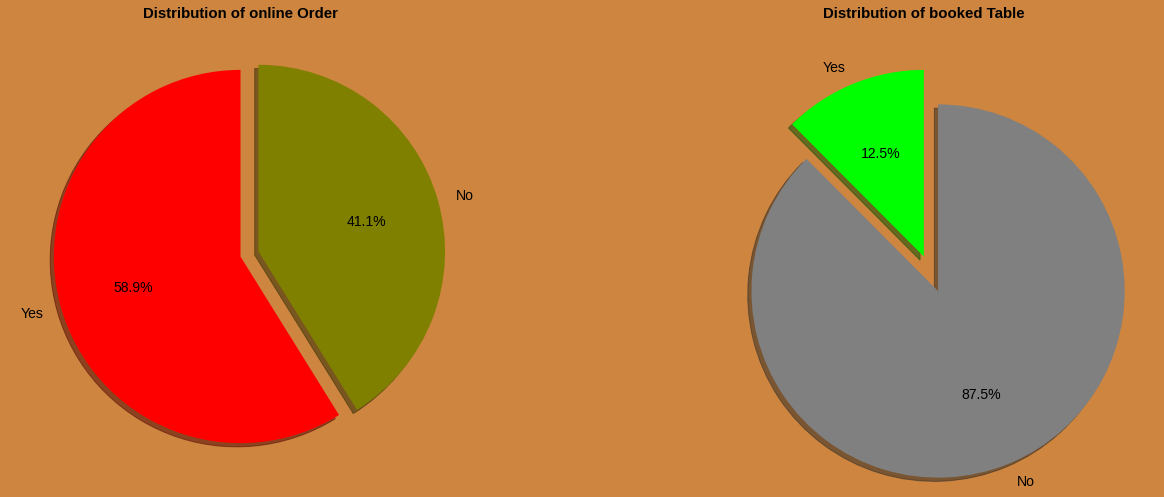

In [89]:
fig = plt.figure(figsize=(20,8))
fig.patch.set_facecolor('peru')
plt.style.use('seaborn-whitegrid')
# Change color of text
plt.rcParams['text.color'] = 'black'

plt.subplot(121)
labels = zomatoDataPandas_withoutOutliers['onlineOrder'].unique() 
sizes = [len(zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['onlineOrder'] == "Yes"]), len(zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['onlineOrder'] == "No"])]
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=["red","olive"]);
plt.title("Distribution of online Order",fontweight='bold',fontsize=15);


plt.subplot(122)
labels = zomatoDataPandas_withoutOutliers['bookTable'].unique() 
sizes = [len(zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['bookTable'] == "Yes"]), len(zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['bookTable'] == "No"])]
explode = (0, 0.2)

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=["Lime","grey"]);
plt.title("Distribution of booked Table",fontweight='bold',fontsize=15);


In [90]:
zomatoDataPandas_withoutOutliers.head(1)

name                                            address      location  \
0  Jalsa  942, 21st Main Road, 2nd Stage, Banashankari, ...  Banashankari   

         phone onlineOrder bookTable  votes       restType  \
0  08042297555         Yes       Yes   41.0  Casual Dining   

                                           dishLiked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   

                         cuisines  approxCost(2 people)  \
0  North Indian, Mughlai, Chinese                 800.0   

                                         reviewsList listedInType  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...       Buffet   

   listedInCity  ratingsBy5  
0  Banashankari         4.1

WE OBSERVE THE FOLLOWING:

---------
1. As clearly indicated,almost 60 per cent of restaurants in Banglore accepts online orders.Nearly 40 per cent of the restaurants do not accept online orders.

2. This might be because of the fact that these restaurants cannot afford to pay commission to zomoto for giving them orders online. zomato may want to consider giving them some more benefits if they want to increse the number of restaurants serving their customers online.

3. Almost 90 percent of restaurants in Banglore do not provide table booking facility.In India you cannot find table booking facility in any average restaurants,usually only five star restaurants provides table booking.

### 4) Distribution of Top 10 RestType in Bangalore.

In [91]:
spark.sql("select restType,total,concat(round(total / (select sum(total) from (select restType,count(*) as total \
from zomatoData group by restType order by total desc limit 10)) * 100,1),'%') as distribution from \
(select restType,count(*) as total from zomatoData group by restType) order by total desc limit 10 ").show()

+------------------+-----+------------+
|          restType|total|distribution|
+------------------+-----+------------+
|       Quick Bites|19113|       43.5%|
|     Casual Dining|10320|       23.5%|
|              Cafe| 3730|        8.5%|
|          Delivery| 2600|        5.9%|
|    Dessert Parlor| 2261|        5.1%|
|Takeaway, Delivery| 2032|        4.6%|
|Casual Dining, Bar| 1154|        2.6%|
|            Bakery| 1140|        2.6%|
|     Beverage Shop|  866|        2.0%|
|               Bar|  697|        1.6%|
+------------------+-----+------------+



In [92]:
import plotly.graph_objs as go

restTypeData = zomatoDataPandas_withoutOutliers.restType.value_counts().head(10)
colors=['#57167E','#9B3192','#EA5F89','#F7B7A3','#FFF1C9','#E6F69D','#AADEA7','#64C2A6','#2D87BB','#3700FF']
fig=go.Figure(data=[go.Pie(labels=restTypeData.index,values=restTypeData.values,marker=dict(colors=colors))],layout=go.Layout(title='Top 10 Types of Restaurants'))
fig.show()
plt.show()

### 5) Distribution of Top 6 Restaurant Types in Bangalore.

In [93]:
top6RestTypes =zomatoDataPandas_withoutOutliers.groupby('restType')['name'].count().sort_values(ascending= False).head(6)

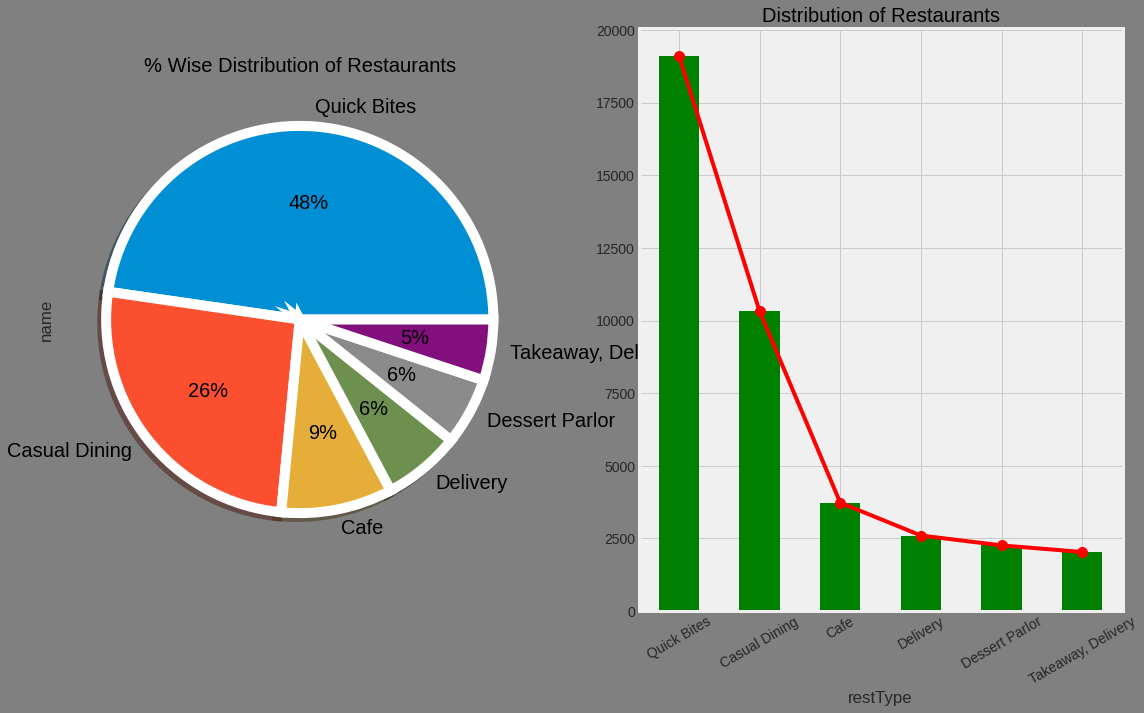

In [94]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('grey')
plt.style.use('fivethirtyeight')

plt.subplot(121)
top6RestTypes.plot.pie(autopct='%1.f%%',wedgeprops={'linewidth':10,'edgecolor':'white'},shadow=True,fontsize=20)
plt.xticks(rotation=30)
plt.title("% Wise Distribution of Restaurants")

plt.subplot(122)
top6RestTypes.plot(kind='bar',color='green')
top6RestTypes.plot(marker='o',markersize=10,color='red')
plt.xticks(rotation=30)
plt.title("Distribution of Restaurants");


### 6) Distribution of Ratings of restaurants in Bengalore.

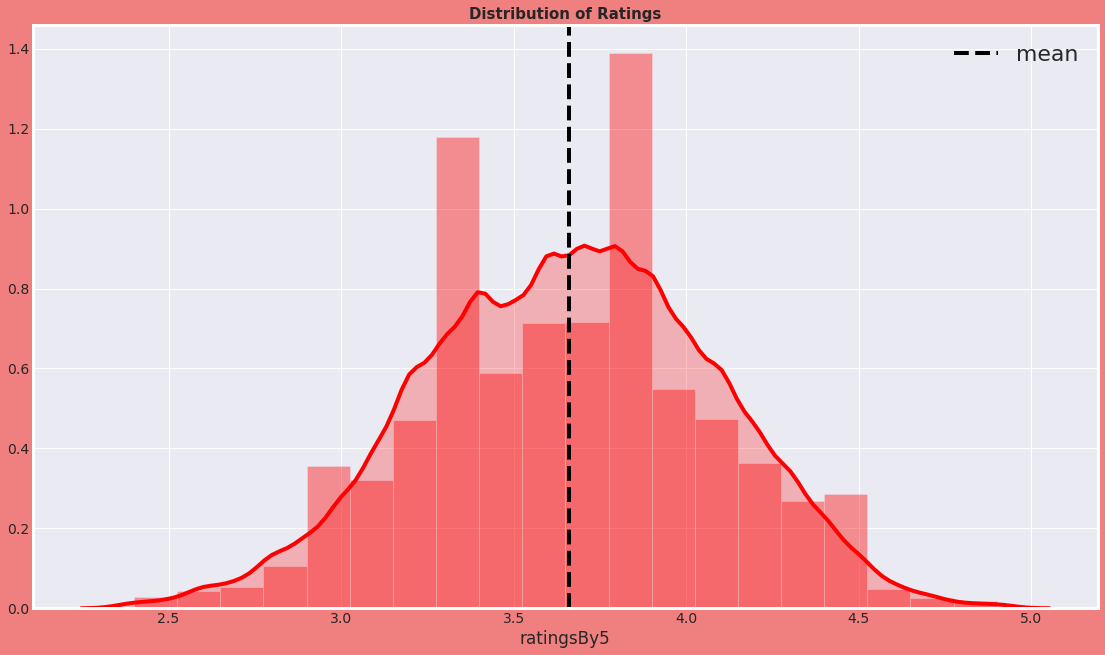

In [95]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('lightcoral')

sns.set_style('darkgrid')
sns.distplot(zomatoDataPandas_withoutOutliers['ratingsBy5'], bins = 20,  color= 'red',kde_kws={"shade": True});
plt.axvline(x= zomatoDataPandas_withoutOutliers.ratingsBy5.mean(),ls='--',color='black',linewidth=4,label="mean")
plt.title("Distribution of Ratings",fontweight='bold',fontsize=15);
plt.legend(["mean"],prop={"size":22});

In [96]:
print('First Quantile of rate distribution is {} '.format(np.quantile(zomatoDataPandas_withoutOutliers['ratingsBy5'], 0.25)))
print('Second Quantile of rate distribution is {} '.format(np.quantile(zomatoDataPandas_withoutOutliers['ratingsBy5'], 0.50)))
print('Third Quantile of rate distribution is {} '.format(np.quantile(zomatoDataPandas_withoutOutliers['ratingsBy5'], 0.75)))
print('Forth Quantile of rate distribution is {} '.format(np.quantile(zomatoDataPandas_withoutOutliers['ratingsBy5'], 1)))
print('Average Rating is {} '.format(np.round(zomatoDataPandas_withoutOutliers['ratingsBy5'].mean(),1)))

First Quantile of rate distribution is 3.4 
Second Quantile of rate distribution is 3.7 
Third Quantile of rate distribution is 4.0 
Forth Quantile of rate distribution is 4.9 
Average Rating is 3.7 


WE OBSERVE THE FOLLOWING:

---------
1. 50% of the rate distribution lies between 3.4 and 4.0 with an average rating of 3.7. 

2. Rating of a restaurant play major role in success. Nearly everyone checks out the rating before even planing to go out. 

3. To run a successful restaurant business above avaerage zomato rating is a must.

### 7) Distribution of Cost Vs Rating and Cost Vs Votes wrt Online Orders

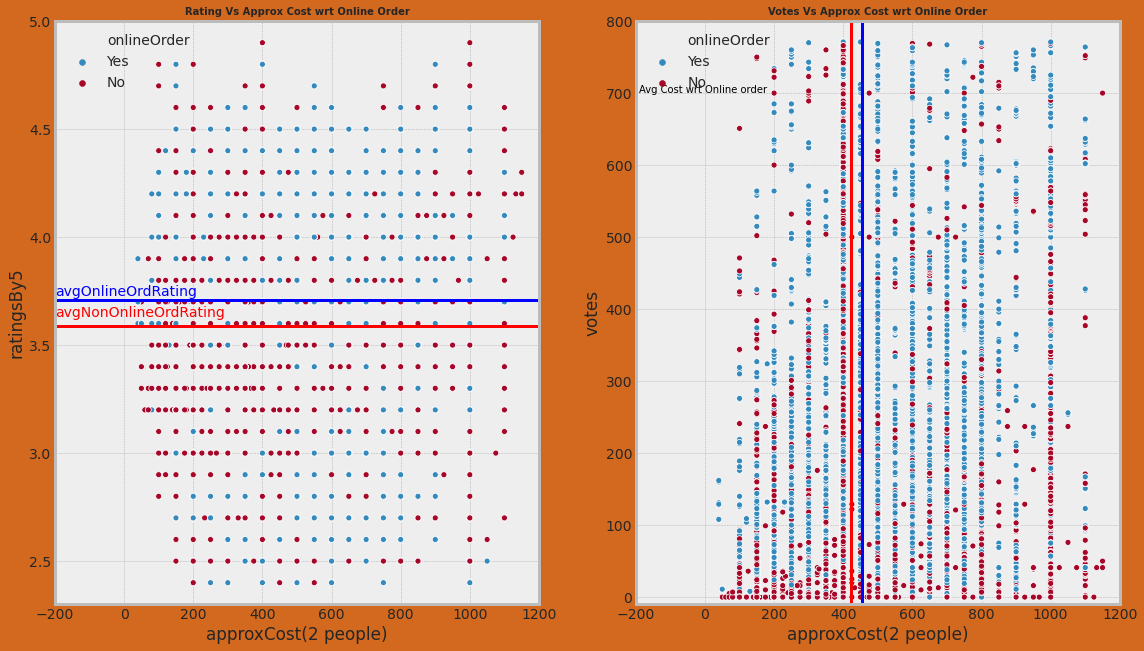

In [97]:
#Cost vs rating
onlineOrder = zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['onlineOrder']=='Yes']
notOnlineOrder = zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['onlineOrder']=='No']

fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('chocolate')
plt.style.use('bmh')

plt.subplot(121)
sns.scatterplot(zomatoDataPandas_withoutOutliers['approxCost(2 people)'],zomatoDataPandas_withoutOutliers.ratingsBy5,hue=zomatoDataPandas_withoutOutliers['onlineOrder']);
plt.axhline(y= onlineOrder.ratingsBy5.mean(),ls='-',color='blue',linewidth=3)
plt.axhline(y= notOnlineOrder.ratingsBy5.mean(),ls='-',color='red',linewidth=3)
plt.text(x=-200,y=3.73,s="avgOnlineOrdRating",color='blue')
plt.text(x=-200,y=3.63,s="avgNonOnlineOrdRating",color='red')
plt.ylim(2.3,5);
plt.xlim(-200,1200)
plt.legend(loc = 'upper left');

plt.title("Rating Vs Approx Cost wrt Online Order",fontweight='bold',fontsize=10)

plt.subplot(122)
sns.scatterplot(zomatoDataPandas_withoutOutliers['approxCost(2 people)'],zomatoDataPandas_withoutOutliers.votes,hue=zomatoDataPandas_withoutOutliers['onlineOrder']);
plt.title("Votes Vs Approx Cost wrt Online Order",fontweight='bold',fontsize=10);
plt.axvline(x= onlineOrder['approxCost(2 people)'].mean(),ls='-',color='blue',linewidth=3)
plt.axvline(x= notOnlineOrder['approxCost(2 people)'].mean(),ls='-',color='red',linewidth=3)
plt.text(x=-190,y=700,s="Avg Cost wrt Online order",color='black',size=10)
plt.ylim(-10,800);
plt.xlim(-200,1200);
plt.legend(loc = 'upper left');

WE OBSERVE THE FOLLOWING:

-------
1. Almost more than 50 percent of restaurants has rating between 3 and 4.
2. Restaurants having rating more than 4.5 are less.

3. We can observer from Scatter Plot 1 that restaurants which got rating between 3 and 4 haven't taken online order that means people went these the restaurants and the cost range is between 0 to 800 mostly.

4. From Scatter Plot 2 we can observe restaurants which are actively providing online orders get relatively more votes than which don't provide online order.

5. Restaurants not providing online orders are heavily gets votes between 0-100. 

6. 400 is the cost where both Online orders and and non-online orders votes are distributed 50-50% 

* #### **Checking Correlations of numeric columns**

In [98]:
zomatoDataPyspark_withoutOutliers.agg(F.round(F.corr('votes','approxCost(2 people)'),2).alias("corr b/w votes n Cost") \
                                     ,F.round(F.corr('ratingsBy5','approxCost(2 people)'),2).alias('corr b/w ratingsBy5 n Cost')\
                                     ,F.round(F.corr('votes','ratingsBy5'),2).alias('corr b/w votes n Cost')
                                     ).show()

+---------------------+--------------------------+---------------------+
|corr b/w votes n Cost|corr b/w ratingsBy5 n Cost|corr b/w votes n Cost|
+---------------------+--------------------------+---------------------+
|                 0.48|                      0.31|                 0.36|
+---------------------+--------------------------+---------------------+



WE OBSERVE THE FOLLOWING:

----
### We can see the Correlations are not very stong, but correlation between votes and cost are better than others

### 8) Distribution of Votes Vs Ratings wrt Online Order and Table Booked.

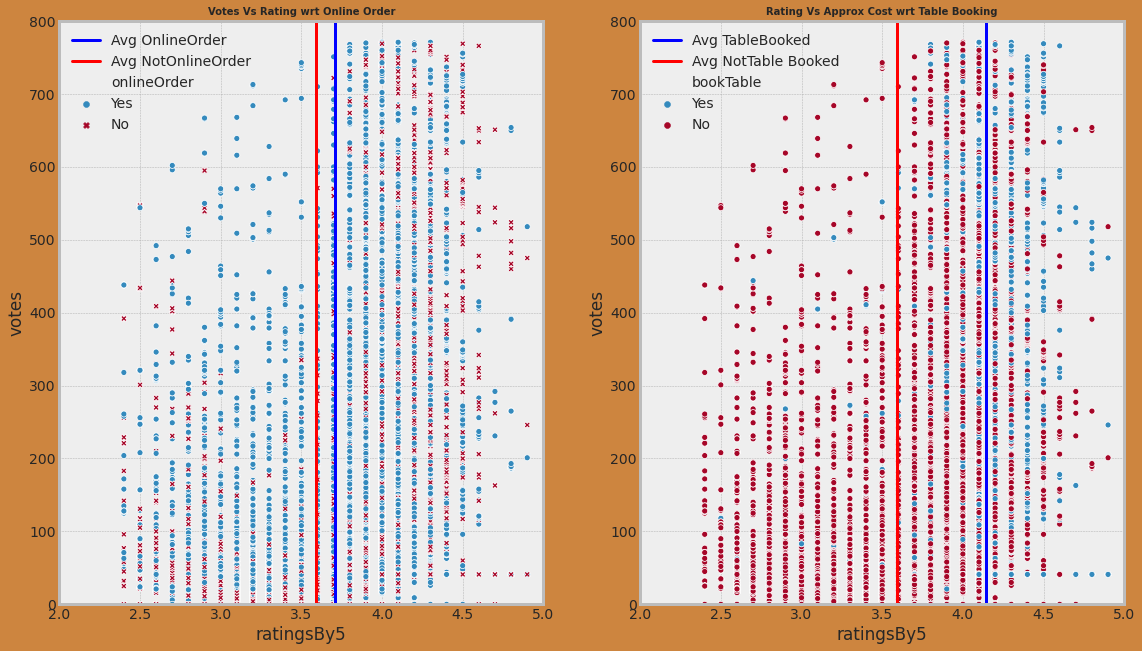

In [99]:
tableBooked = zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['bookTable']=='Yes']
notTableBooked = zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['bookTable']=='No']

fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('peru')
plt.style.use('bmh')


plt.subplot(121)
sns.scatterplot(zomatoDataPandas_withoutOutliers.ratingsBy5,zomatoDataPandas_withoutOutliers.votes,hue=zomatoDataPandas_withoutOutliers['onlineOrder'],markers= True,style=zomatoDataPandas_withoutOutliers['onlineOrder']);
plt.title("Votes Vs Rating wrt Online Order",fontweight='bold',fontsize=10)
plt.axvline(x= onlineOrder.ratingsBy5.mean(),ls='-',color='blue',linewidth=3,label="Avg OnlineOrder")
plt.axvline(x= notOnlineOrder.ratingsBy5.mean(),ls='-',color='red',linewidth=3,label="Avg NotOnlineOrder")
plt.xlim(2,5)
plt.ylim(0,800)
plt.legend(loc='upper left')

plt.subplot(122)
sns.scatterplot(zomatoDataPandas_withoutOutliers.ratingsBy5,zomatoDataPandas_withoutOutliers.votes,hue=zomatoDataPandas_withoutOutliers['bookTable']);
plt.title("Rating Vs Approx Cost wrt Table Booking",fontweight='bold',fontsize=10);
plt.axvline(x= tableBooked.ratingsBy5.mean(),ls='-',color='blue',linewidth=3,label="Avg TableBooked")
plt.axvline(x= notTableBooked.ratingsBy5.mean(),ls='-',color='red',linewidth=3,label="Avg NotTable Booked")
plt.xlim(2,5)
plt.ylim(0,800)
plt.legend(loc='upper left');

WE OBSERVE THE FOLLOWING:

----------
1. From Scatter Plot 1 we can observe that for Online orders ratings are high between 3 and 4.2 and votes are also high between 3.7 and 4.5 ratings and Avg Online Order Ratings is better that  Non Online Order.

2. Even though for for non online orders the the votes are less except between 4.2 and above but the rating are pretty high for 4.3 and above ratings.

3. From Scatter Plot 2 we can observe restaurants which dont provide Table Bookings gets bad ratings even thought they get good amount of votes. That's why there avg ratings is pretty low around 3.6 than the restaurants providing booking with avg rating of around 4.2.

4. Restaurants providing Table Bookings get pretty pretty high ratings and high votes and have better avg ratings.


### 9) Distribution of Ratings Vs Cost and Votes Vs Cost wrt Table Booked.

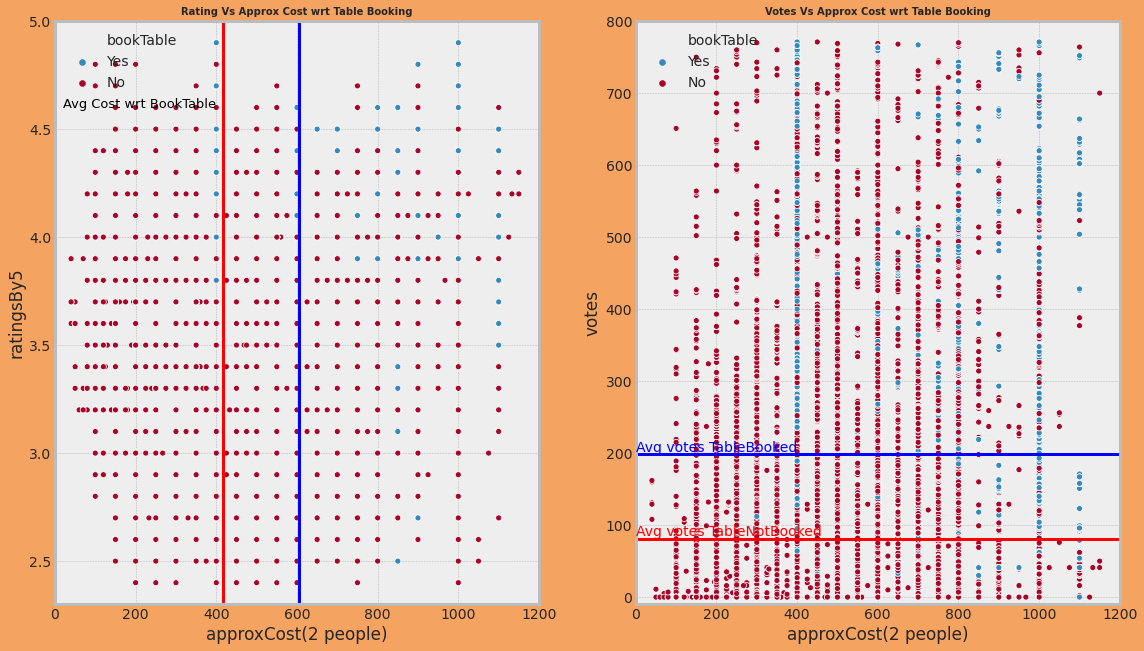

In [100]:
#Cost vs rating
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('sandybrown')
plt.style.use('bmh')


plt.subplot(121)
sns.scatterplot(zomatoDataPandas_withoutOutliers['approxCost(2 people)'],zomatoDataPandas_withoutOutliers.ratingsBy5,hue=zomatoDataPandas_withoutOutliers['bookTable'],);
plt.axvline(x= tableBooked['approxCost(2 people)'].mean(),ls='-',color='blue',linewidth=3)
plt.axvline(x= notTableBooked['approxCost(2 people)'].mean(),ls='-',color='red',linewidth=3)
plt.title("Rating Vs Approx Cost wrt Table Booking",fontweight='bold',fontsize=10)
plt.text(x= 20,y=4.6,s="Avg Cost wrt BookTable",color='Black',size=13)
plt.ylim(2.3,5)
plt.xlim(0,1200)
plt.legend(loc='upper left')

plt.subplot(122)
sns.scatterplot(zomatoDataPandas_withoutOutliers['approxCost(2 people)'],zomatoDataPandas_withoutOutliers.votes,hue=zomatoDataPandas_withoutOutliers['bookTable']);
plt.axhline(y= tableBooked.votes.mean(),ls='-',color='blue',linewidth=3)
plt.axhline(y= notTableBooked.votes.mean(),ls='-',color='red',linewidth=3)
plt.title("Votes Vs Approx Cost wrt Table Booking",fontweight='bold',fontsize=10);
plt.text(x= 0,y=202,s="Avg votes TableBooked",color='Blue',size=14);
plt.text(x= 0,y=85,s="Avg votes TableNotBooked",color='Red',size=14);
plt.ylim(-10,800)
plt.xlim(0,1200)
plt.legend(loc='upper left');

### **Feature Creation**

* #### Creating 4 bins for dividing Price.

Using Pandas

In [101]:
#Feature Creation
bins = [0.0,2.0,3.0,4.0,5.0]
labels =["Bad","Average","Good","Excellent"]
zomatoDataPandas_withoutOutliers['RateLabel'] = pd.cut(zomatoDataPandas_withoutOutliers['ratingsBy5'],bins=bins, labels=labels)

Using Pyspark , Creating UDF

In [102]:
def label(ratingsBy5):
  if ratingsBy5 <=2.0:
    return "Bad"
  elif ratingsBy5 >2 and ratingsBy5 <=3:
    return "Average"
  elif ratingsBy5 >3 and ratingsBy5 <=4:
    return "Good"
  else: 
    return "Excellent"

In [103]:
from pyspark.sql.functions import udf

bucket_udf = udf(label, StringType())

zomatoDataPyspark_withoutOutliers = zomatoDataPyspark_withoutOutliers.withColumn('RateLabel',bucket_udf('ratingsBy5'))

### 10) Top 10 Rated Restaurant Type wrt RateLabels

In [104]:
zomatoDataPyspark_withoutOutliers.crosstab('restType','RateLabel').orderBy(['Excellent','Good','Bad'],ascending=[False,False,True]).show(10)

+-------------------+-------+---+---------+-----+
| restType_RateLabel|Average|Bad|Excellent| Good|
+-------------------+-------+---+---------+-----+
|      Casual Dining|    949|  7|     2466| 6898|
|               Cafe|    237|  0|     1353| 2140|
|        Quick Bites|   1197|  0|      980|16936|
| Casual Dining, Bar|     30|  0|      705|  419|
|     Dessert Parlor|     55|  0|      605| 1601|
| Bar, Casual Dining|     12|  0|      265|  147|
|Casual Dining, Cafe|      0|  0|      263|   56|
|        Fine Dining|      4|  0|      244|   97|
|                Pub|     28|  0|      220|  108|
|           Delivery|    173|  0|      175| 2252|
+-------------------+-------+---+---------+-----+
only showing top 10 rows



WE OBSERVE THE FOLLOWING:

---------
#### We can observe that Casual Dining , Cafe, Quick Bites and Bar are the top Rated Restaurant types with highest Positive Ratings.

### 11) RestType wrt Ratings

<Figure size 1224x720 with 0 Axes>

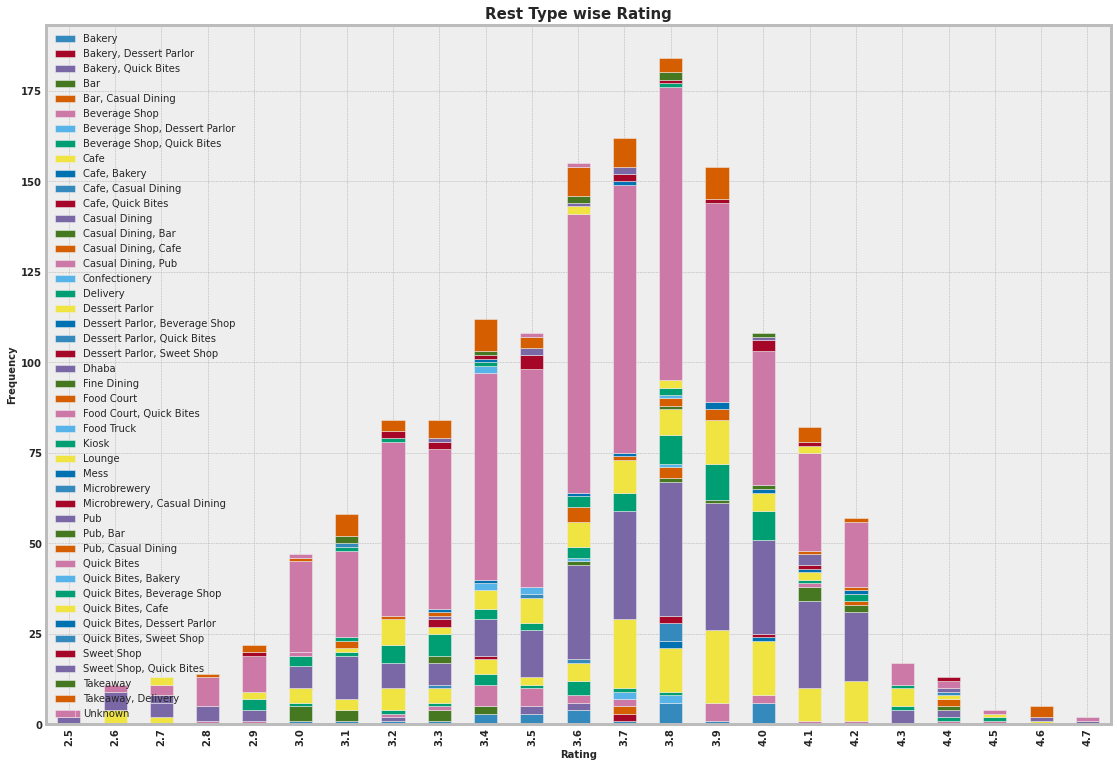

In [105]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('forestgreen')
plt.style.use('bmh')

pd.crosstab(zomatoDataPandas_withoutOutliers.ratingsBy5.head(1500),zomatoDataPandas_withoutOutliers.restType.head(1500)).plot(kind='bar',stacked=True,figsize= (17,12));
plt.title('Rest Type wise Rating',fontsize=15,fontweight='bold')
plt.ylabel('Frequency',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
plt.legend(loc = 'upper left',prop={"size":10});

WE OBSERVE THE FOLLOWING:

---------
1. We can see Restaurant Type marked with Pink Color are highly distributed for both good and bad reviews.

2. Restaurants Marked with Purple Color are 2nd largest distibuted with ratings 3.6 - 4.2

### 12) Location wrt Ratings

<Figure size 1224x720 with 0 Axes>

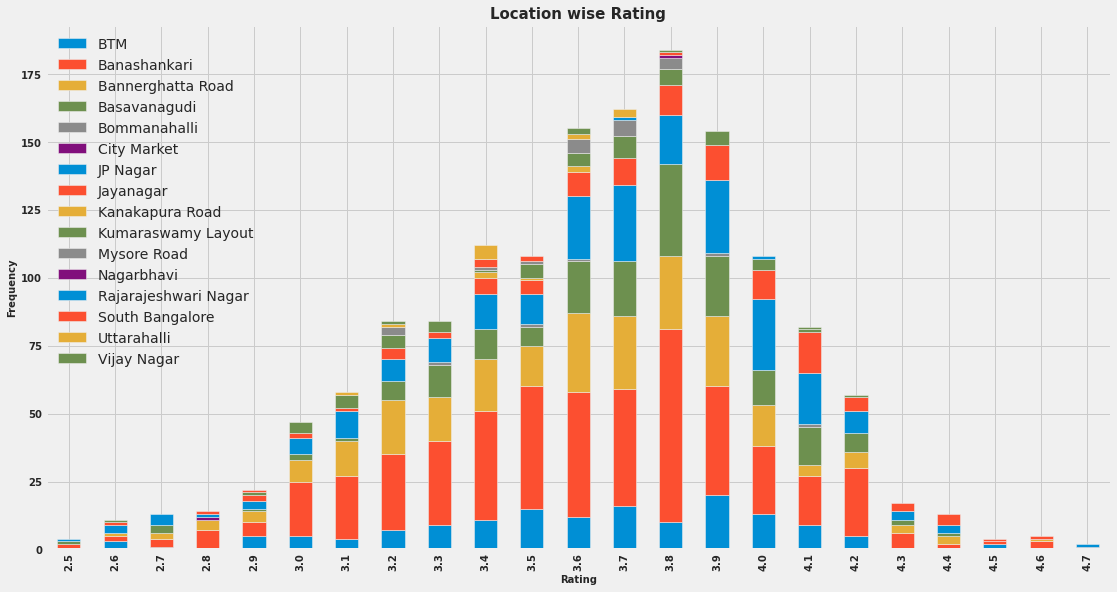

In [106]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('forestgreen')
plt.style.use('fivethirtyeight')

pd.crosstab(zomatoDataPandas_withoutOutliers.ratingsBy5.head(1500),zomatoDataPandas_withoutOutliers.location.head(1500)).plot(kind='bar',stacked=True,figsize= (17,9));
plt.title('Location wise Rating',fontsize=15,fontweight='bold')
plt.ylabel('Frequency',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
plt.legend(loc = 'upper left');

WE OBSERVE THE FOLLOWING:

--------
We can see Location with Orange color mark are most popular location thus have highly distributed ratings with lowest to highest.

### 13) Label wise Rating wrt ListedInType

<Figure size 1224x720 with 0 Axes>

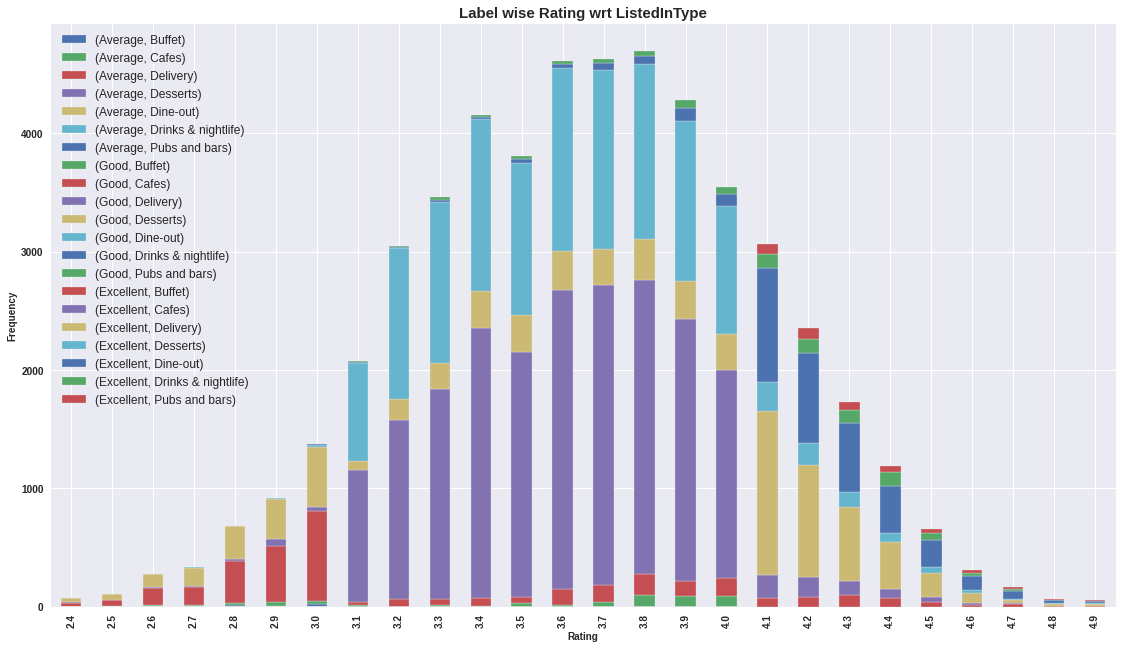

In [107]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('forestgreen')
plt.style.use('seaborn')
pd.crosstab(zomatoDataPandas_withoutOutliers.ratingsBy5,[zomatoDataPandas_withoutOutliers.RateLabel,zomatoDataPandas_withoutOutliers.listedInType]).plot(kind='bar',stacked=True,figsize= (17,10));
plt.title('Label wise Rating wrt ListedInType',fontsize=15,fontweight='bold')
plt.ylabel('Frequency',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
plt.legend(loc = 'upper left',prop={"size":12});

WE OBSERVE THE FOLLOWING:

---------
1. We can see that ListedIntype marked with Purple and Blue color are very highly distributed with positive ratings between ratings 3 - 4.
2. ListedIntype marked with Dark Blue and Olive color are very highly distributed with positive ratings between ratings 4.1 - 4.9 .

### 14) RestType wrt Ratings

<Figure size 1224x720 with 0 Axes>

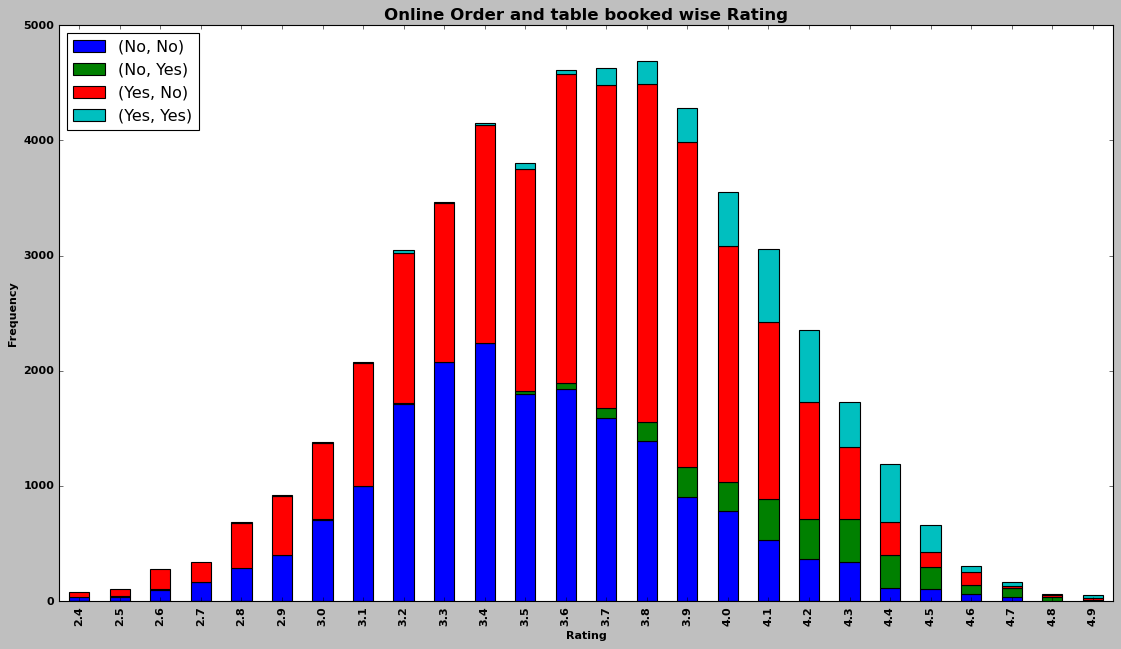

In [108]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('forestgreen')
plt.style.use('classic')

pd.crosstab(zomatoDataPandas_withoutOutliers.ratingsBy5,[zomatoDataPandas_withoutOutliers.onlineOrder,zomatoDataPandas_withoutOutliers.bookTable]).plot(kind='bar',stacked=True,figsize= (17,9));
plt.title('Online Order and table booked wise Rating',fontsize=15,fontweight='bold')
plt.ylabel('Frequency',fontsize=10,fontweight='bold')
plt.xlabel('Rating',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
plt.legend(loc = 'upper left');

WE OBSERVE THE FOLLOWING:

-------
1. We can see if customer hasn't done online order and table booking then their ratings are highly distributed between ratings 3.2- 3.6 then decreases.

2. If customer has Online ordered and have't booked table then their ratings are better than above case and are highly distributed between ratings 3.2- 4.1 then decreases.

3. If customer has Online ordered and booked table enen though their percent is less still they have rated above average between 3.7 and 4.5

### 15) Which are the top restaurant chains in Bangaluru?

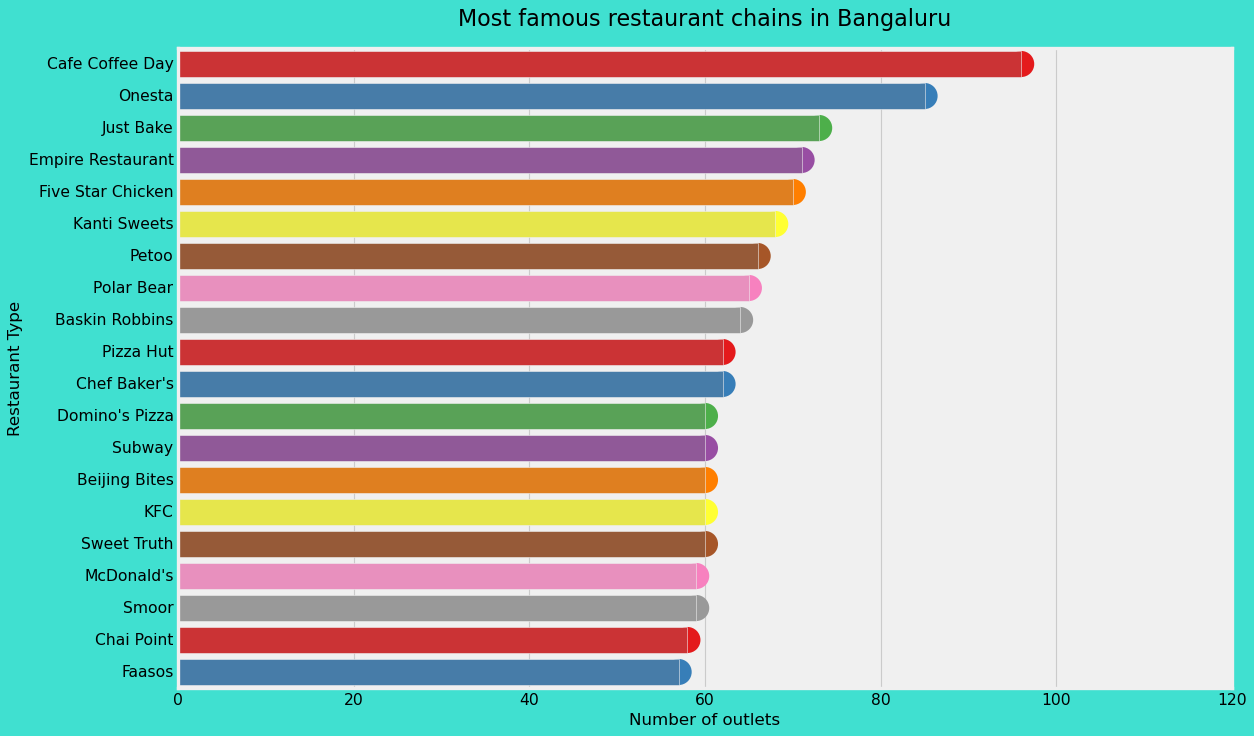

In [109]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('turquoise')
plt.style.use('fivethirtyeight')

chains=zomatoDataPandas_withoutOutliers['name'].value_counts()[:20]
sns.pointplot(x=chains.values,y=chains.index,palette='Set1')
ax = sns.barplot(x=chains.values,y=chains.index,palette='Set1')

plt.title("Most famous restaurant chains in Bangaluru",size=20,pad=20)
plt.xlabel("Number of outlets",size=15)
plt.ylabel("Restaurant Type",size=15);

In [110]:
zomatoDataPyspark_withoutOutliers.groupBy('name').count().orderBy('count',ascending=False).show(20)

+-----------------+-----+
|             name|count|
+-----------------+-----+
|  Cafe Coffee Day|   96|
|           Onesta|   85|
|        Just Bake|   73|
|Empire Restaurant|   71|
|Five Star Chicken|   70|
|     Kanti Sweets|   68|
|            Petoo|   66|
|       Polar Bear|   65|
|   Baskin Robbins|   64|
|     Chef Baker's|   62|
|        Pizza Hut|   62|
|    Beijing Bites|   60|
|              KFC|   60|
|   Domino's Pizza|   60|
|      Sweet Truth|   60|
|           Subway|   60|
|            Smoor|   59|
|       McDonald's|   59|
|       Chai Point|   58|
|           Faasos|   57|
+-----------------+-----+
only showing top 20 rows



WE OBSERVE THE FOLLOWING:

--------
1. Cafee Cofee Day has the most number of outlets in the city of bangalore followed by Onesta, Just Bake and Empire Restaurant.
2. McDonald's is on the 18th number according to number of outlets.

### 16)Table booked wrt Cost

In [111]:
zomatoDataPyspark.crosstab('approxCost(2 people)','bookTable').orderBy(['Yes','No'],ascending=[False,True]).show()

+------------------------------+----+---+
|approxCost(2 people)_bookTable|  No|Yes|
+------------------------------+----+---+
|                          1000| 879|757|
|                           800|1592|692|
|                          1200| 319|672|
|                          1500| 313|658|
|                          1300| 111|404|
|                          1400| 108|364|
|                          1100| 175|336|
|                           600|3414|297|
|                           900| 429|271|
|                           700|1705|241|
|                          1600|  38|228|
|                          1700|  54|193|
|                          2000| 177|185|
|                          1800|  56|147|
|                          2500|  30|116|
|                          3000|  48|114|
|                           750| 653|104|
|                           650| 703| 73|
|                           500|4910| 64|
|                          2100|   6| 61|
+------------------------------+--

WE OBSERVE THE FOLLOWING:

---------
1. If the cost of food is more than 1000 than  majority of people have booked the table. These restaurants are more expensive also.
2. If the cost of food is less than 1000 than  majority of people haven't booked the table.

<Figure size 1360x960 with 0 Axes>

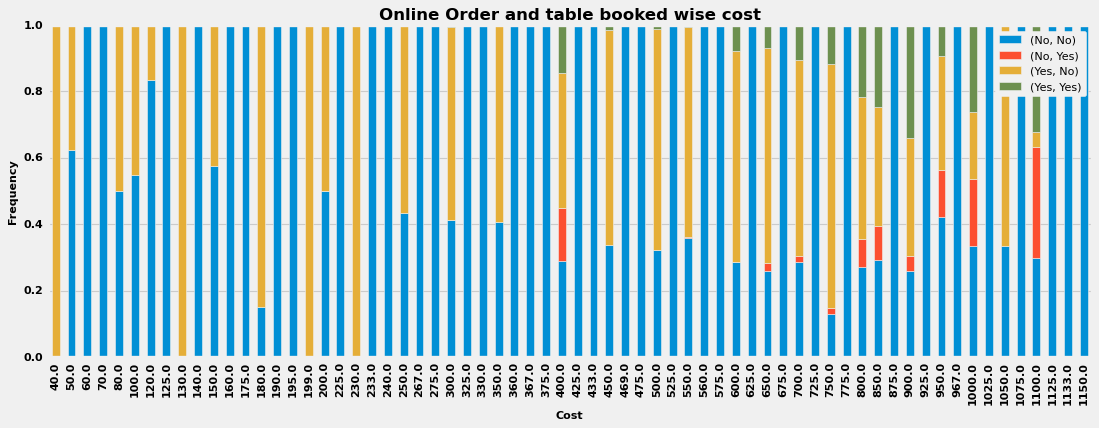

In [112]:
plt.figure(figsize=(17,12))
plt.style.use('fivethirtyeight')
y = pd.crosstab(zomatoDataPandas_withoutOutliers['approxCost(2 people)'],[zomatoDataPandas_withoutOutliers.onlineOrder,zomatoDataPandas_withoutOutliers.bookTable]);
y.div(y.sum(1).astype(float), axis = 0).plot(kind='bar',stacked=True,figsize= (15,5));
plt.title('Online Order and table booked wise cost',fontsize=15,fontweight='bold')
plt.ylabel('Frequency',fontsize=10,fontweight='bold')
plt.xlabel('Cost',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold');
plt.legend(loc = 'best',prop={"size":10});

### 17)Online Order wrt Cost

In [113]:
zomatoDataPyspark.crosstab('approxCost(2 people)','onlineOrder').orderBy(['Yes','No'],ascending=[False,True]).show()

+--------------------------------+----+----+
|approxCost(2 people)_onlineOrder|  No| Yes|
+--------------------------------+----+----+
|                             300|3102|4463|
|                             400|2296|4258|
|                             500|1591|3383|
|                             600|1056|2655|
|                             200|2428|2425|
|                             250|1271|1686|
|                             800| 807|1477|
|                             700| 584|1362|
|                             350| 701|1061|
|                             450| 462| 955|
|                             150|1185| 878|
|                            1000| 876| 760|
|                             750| 106| 651|
|                             650| 216| 560|
|                            1200| 492| 499|
|                             550| 266| 495|
|                             900| 210| 490|
|                            1500| 503| 468|
|                             100| 544| 449|
|         

WE OBSERVE THE FOLLOWING:

----------
1. If the cost of food is more than 1000 than majority of people have not ordered Online, thus they might have booked and went to restaurant.
2. If the cost of food is less than 1000 than majority of people have ordered Online.

<Figure size 1360x800 with 0 Axes>

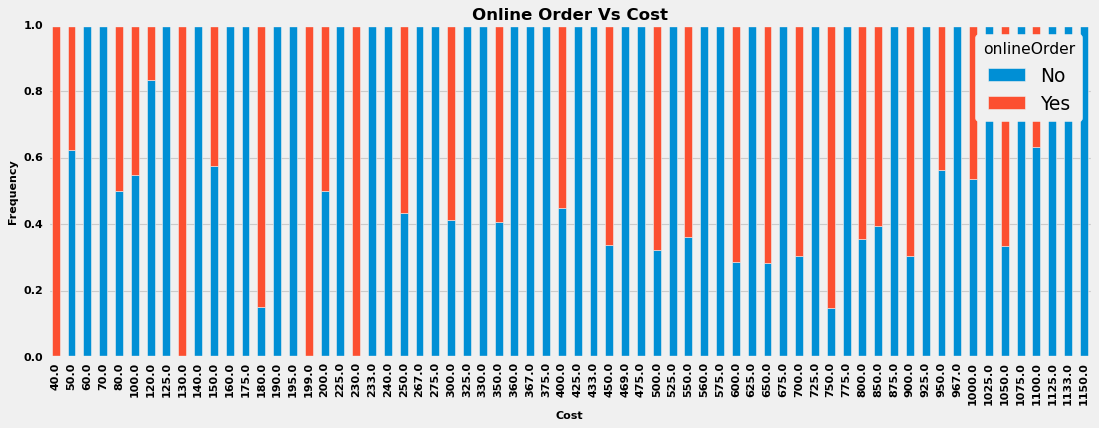

In [114]:
#plt.figure(figsize=(17,12))
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(17,10))

y = pd.crosstab(zomatoDataPandas_withoutOutliers['approxCost(2 people)'],zomatoDataPandas_withoutOutliers.onlineOrder)
y.div(y.sum(1).astype(float), axis = 0).plot(kind='bar',stacked=True,figsize= (15,5));
plt.title('Online Order Vs Cost',fontsize=15,fontweight='bold')
plt.ylabel('Frequency',fontsize=10,fontweight='bold')
plt.xlabel('Cost',fontsize=10,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold');
plt.yticks(fontsize=10,fontweight='bold');

### 18)OnlineOrder Vs Votes and OnlineOrder Vs ApproxCost wrt book Table

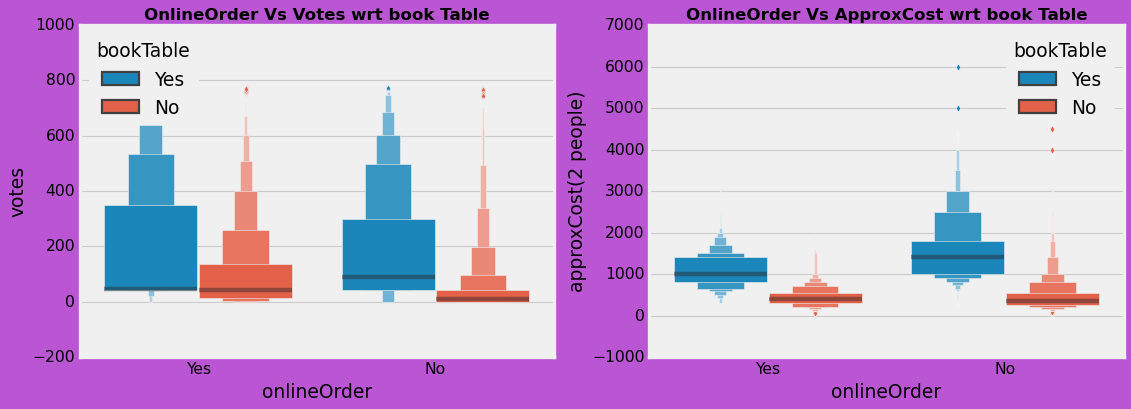

In [115]:
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('mediumorchid')
plt.style.use('fivethirtyeight')

plt.subplot(121)
sns.boxenplot(data=zomatoDataPandas_withoutOutliers,x='onlineOrder',y='votes',hue='bookTable');
plt.title("OnlineOrder Vs Votes wrt book Table",fontweight='bold',fontsize=15);

plt.subplot(122)
sns.boxenplot(data=zomatoDataPandas,x='onlineOrder',y='approxCost(2 people)',hue='bookTable');
plt.title("OnlineOrder Vs ApproxCost wrt book Table",fontweight='bold',fontsize=15);

WE OBSERVE THE FOLLOWING:

--------
1. Restaurants accepting online orders get more umber of votes.
2. Median number of votes are different in both categoies.
3. The cost is significantly less when restaurants accept orders online.

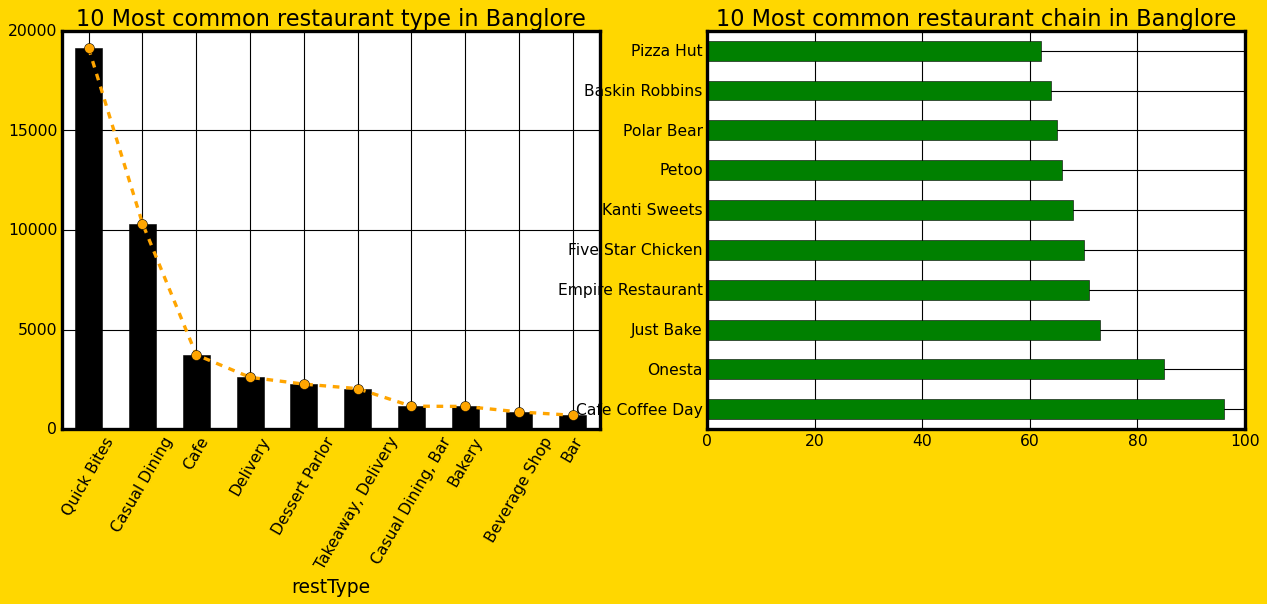

In [116]:
fig = plt.figure(figsize=(17,6))
fig.patch.set_facecolor('gold')
plt.style.use('grayscale')

plt.subplot(121)
#Which are the most common restaurant type in Banglore?
zomatoDataPandas_withoutOutliers.groupby('restType')['restType'].count().sort_values(ascending=False).head(10).plot(kind='bar',figsize= (17,6));
zomatoDataPandas_withoutOutliers.groupby('restType')['restType'].count().sort_values(ascending=False).head(10).plot(kind='line',color='orange',figsize= (17,6),marker='o',markersize=9,linestyle='dashed',linewidth=3);
plt.title('10 Most common restaurant type in Banglore')
plt.xticks(rotation=60);

plt.subplot(122)
#Which are the most common restaurant chain in Banglore?
zomatoDataPandas_withoutOutliers.name.value_counts().head(10).plot(kind='barh',figsize= (17,6),color='green');
#zomatoDataPandas_withoutOutliers.name.value_counts().head(10).plot(kind='line',color='red',figsize= (17,6),marker='o',markersize=9,linestyle='dashed',linewidth=3)
plt.title('10 Most common restaurant chain in Banglore');

### 19) Online Orders Vs RatingsBy5

In [117]:
zomatoDataPyspark_withoutOutliers.crosstab('onlineOrder','ratingsBy5').toPandas().head()

onlineOrder_ratingsBy5  1.8  2.0  2.1  2.2  2.3  2.4  2.5  2.6  2.7  ...  \
0                     No    5   11    9   10   29   36   38   83  141  ...   
1                    Yes    0    0   15   16   22   34   63  177  166  ...   

    4.0   4.1   4.2   4.3  4.4  4.5  4.6  4.7  4.8  4.9  
0   874   842   648   691  374  297  140  113   34   12  
1  2308  2102  1535  1000  773  359  160   54   32   43  

[2 rows x 32 columns]

<Figure size 1360x800 with 0 Axes>

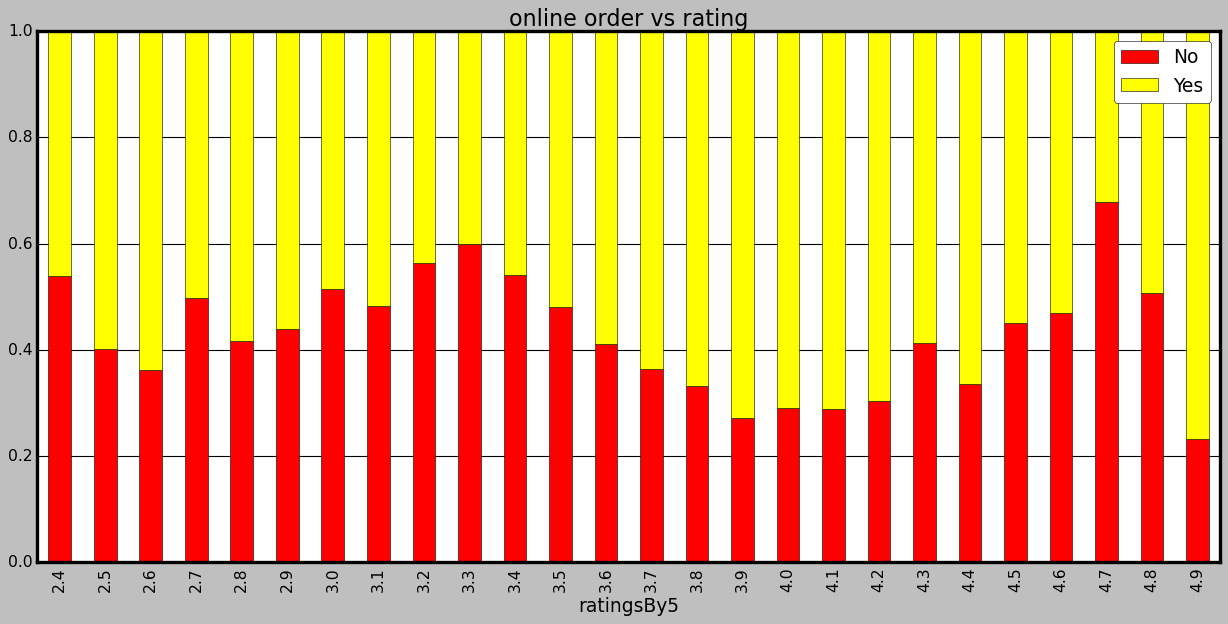

In [118]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('cornflowerblue')
plt.style.use('grayscale')

x = pd.crosstab(zomatoDataPandas_withoutOutliers.ratingsBy5,zomatoDataPandas_withoutOutliers.onlineOrder)
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True,color=['red','yellow'],figsize=(17,8));
plt.title('online order vs rating', fontweight = 30, fontsize = 20)
plt.legend(loc='upper right');

WE OBSERVE THE FOLLOWING:

----------
1. Online Orders rating are pretty high compared to not Online Orders.
2. Very high Ratings like 4.5 and above are mostly equal for both Online and Non Online orders.
3. We can also see poor ratings between 2.1 to 3 are also mostly given by people ordered online.

### 20) BookTable Vs RatingsBy5

In [119]:
zomatoDataPyspark_withoutOutliers.crosstab('bookTable','ratingsBy5').toPandas().head()

bookTable_ratingsBy5  1.8  2.0  2.1  2.2  2.3  2.4  2.5  2.6  2.7  ...  \
0                   No    5   11   24   13   51   70   99  256  303  ...   
1                  Yes    0    0    0   13    0    0    2    4    4  ...   

    4.0   4.1   4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  
0  2497  1956  1233  932  370  233  167   50   23   15  
1   685   988   950  759  777  423  133  117   43   40  

[2 rows x 32 columns]

<Figure size 1360x800 with 0 Axes>

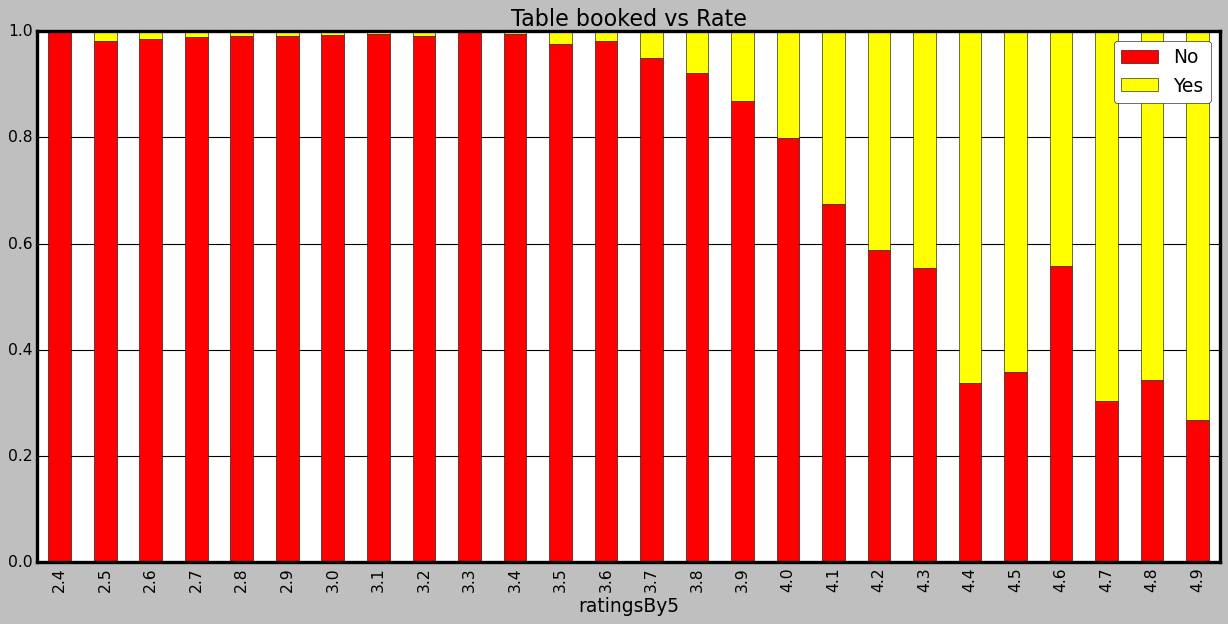

In [120]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('gold')
plt.style.use('grayscale')

x = pd.crosstab(zomatoDataPandas_withoutOutliers.ratingsBy5,zomatoDataPandas_withoutOutliers.bookTable)
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True,color=['red','yellow'],figsize=(17,8));
plt.title('Table booked vs Rate', fontweight = 30, fontsize = 20)
plt.legend(loc='upper right');

WE OBSERVE THE FOLLOWING:

----------
1. Pretty Low ratings are given by people that are not booking table.
2. Ratings upto 4.2 are high for people that have booked tables than who haven't
3. Very high ratings like 4.3 and above are mostly given by people that have booked the table.

### 21) MOST FAMOUS CUISINES IN BANGULURU

In [121]:
top_15_cuisines = zomatoDataPandas_withoutOutliers.cuisines.value_counts().head(15)

colors=['#57167E','#9B3192','#EA5F89','#F7B7A3','#FFF1C9','#E6F69D','#AADEA7','#64C2A6','#2D87BB','#3700FF']
fig=go.Figure(data=[go.Pie(labels=top_15_cuisines.index,values=top_15_cuisines.values,marker=dict(colors=colors))],layout=go.Layout(title='Top 10 Types of Cuisines'))
fig.show()


top_15_cuisines = top_15_cuisines.reset_index()
top_15_cuisines.index = np.arange(1, len(top_15_cuisines)+1)
top_15_cuisines.columns =['cuisines','count']
top_15_cuisines['count %'] = np.round(top_15_cuisines['count'] * 100 / sum(top_15_cuisines['count']),1).apply(lambda x:str(x) + "%")
top_15_cuisines
plt.show()


cuisines  count count %
1                          North Indian   2957   20.0%
2                 North Indian, Chinese   2381   16.1%
3                          South Indian   1827   12.3%
4                               Biryani    918    6.2%
5                      Bakery, Desserts    911    6.2%
6                             Fast Food    802    5.4%
7                              Desserts    766    5.2%
8                                  Cafe    756    5.1%
9   South Indian, North Indian, Chinese    726    4.9%
10                               Bakery    651    4.4%
11                              Chinese    554    3.7%
12                  Ice Cream, Desserts    417    2.8%
13                Chinese, North Indian    415    2.8%
14                  Mithai, Street Food    372    2.5%
15                  Desserts, Ice Cream    353    2.4%

WE OBSERVE THE FOLLOWING:

-----------------
1. North Indian, South Indian, Chinese are very popular in Banguluru.

2. We can observe that North Indian,chinese,South Indian and Biriyani are most common.

3. Is this imply the fact that Banglore is more influenced by North Indian culture more than South?

### 22) Which are the 20 most common cuisines in Bangalore wrt location?

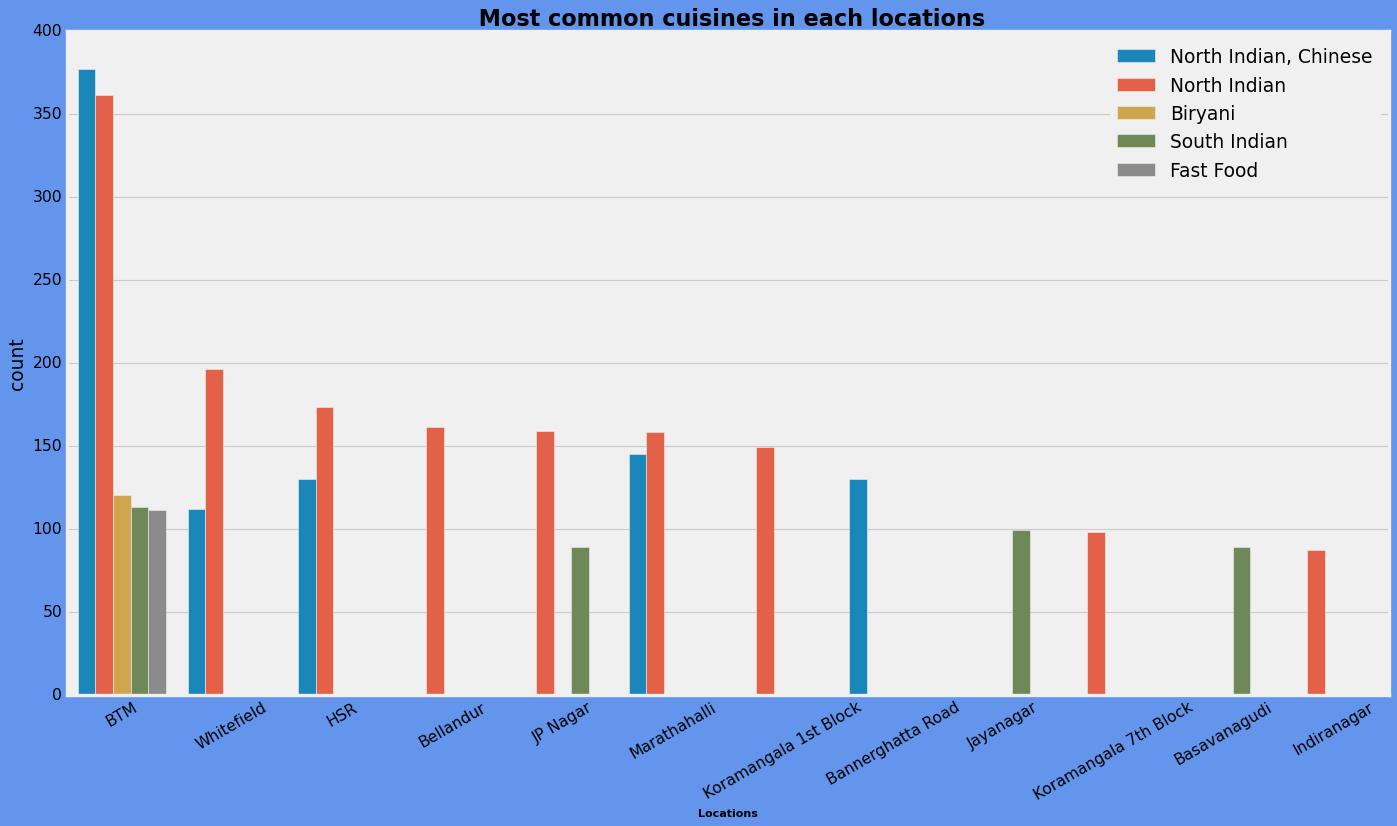

In [122]:
fig = plt.figure(figsize=(19,10))
fig.patch.set_facecolor('cornflowerblue')
plt.style.use('fivethirtyeight')

top20CuisinesLoc = zomatoDataPandas_withoutOutliers.groupby(['location','cuisines'])['name'].count().sort_values(ascending=False).head(20).reset_index()
top20CuisinesLoc.columns=['location','cuisines','count']
sns.barplot(data=top20CuisinesLoc,x='location',y='count',hue='cuisines')
plt.xticks(rotation=30)
plt.legend(loc='upper right')
plt.title(" Most common cuisines in each locations",fontweight='bold')
plt.xlabel('Locations',fontsize=10,fontweight='bold');

WE OBSERVE THE FOLLOWING:

1. We can see top locations are BTM,Whitefield and HSR which provide top cuisines like North Indian , Chinese and Biryani.

### 23) Which are the 5 most common cuisines in top 5 locations?

In [123]:
spark.sql("select location,cuisines,totalCuisines,rnk from (select location,cuisines,totalCuisines,rank() \
over(partition by location order by totalCuisines desc) AS rnk from (select distinct location,cuisines, \
count(cuisines) as totalCuisines from zomatoData group by location,cuisines)) where rnk <= 5 order by 1,3 desc").show(25)

+-----------------+--------------------+-------------+---+
|         location|            cuisines|totalCuisines|rnk|
+-----------------+--------------------+-------------+---+
|              BTM|North Indian, Chi...|          377|  1|
|              BTM|        North Indian|          340|  2|
|              BTM|             Biryani|          119|  3|
|              BTM|        South Indian|          113|  4|
|              BTM|           Fast Food|          111|  5|
|     Banashankari|        South Indian|           86|  1|
|     Banashankari|North Indian, Chi...|           61|  2|
|     Banashankari|        North Indian|           36|  3|
|     Banashankari|    Bakery, Desserts|           25|  4|
|     Banashankari|South Indian, Nor...|           19|  5|
|        Banaswadi|        South Indian|           37|  1|
|        Banaswadi|North Indian, Chi...|           24|  2|
|        Banaswadi|             Biryani|           23|  3|
|        Banaswadi|           Fast Food|           23|  

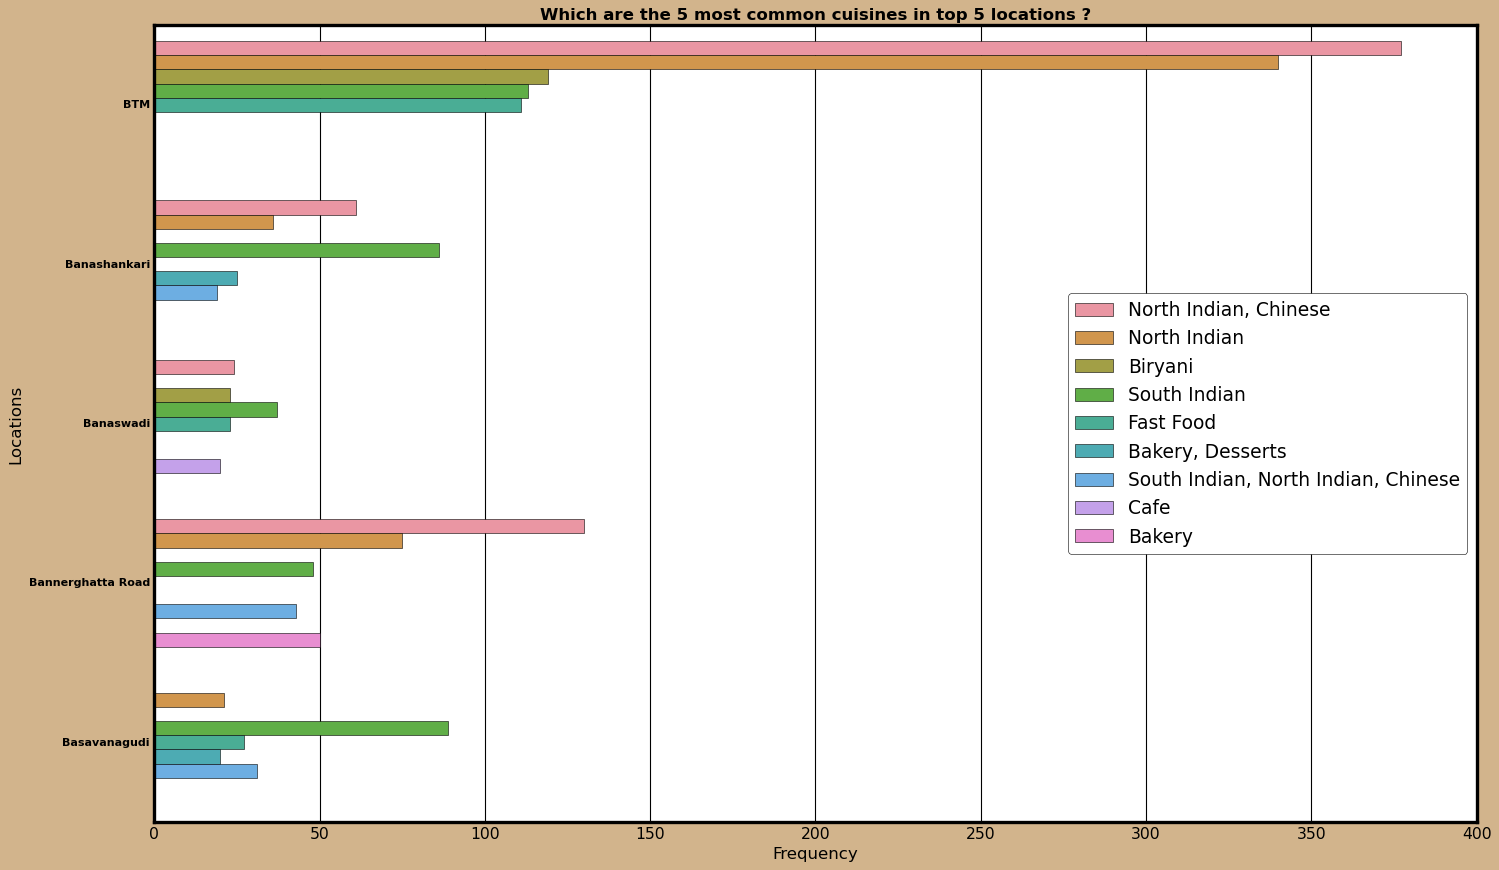

In [124]:
top5CusInTop5Loc = spark.sql("select location,cuisines,totalCuisines,rnk from (select location,cuisines,totalCuisines,rank() \
over(partition by location order by totalCuisines desc) AS rnk from (select distinct location,cuisines, \
count(cuisines) as totalCuisines from zomatoData group by location,cuisines)) where rnk <= 5 order by 1,3 desc").toPandas().head(25)


fig = plt.figure(figsize=(19,12))
fig.patch.set_facecolor('tan')
plt.style.use('grayscale')

sns.barplot(data = top5CusInTop5Loc,y='location',x='totalCuisines',hue='cuisines');
plt.title('Which are the 5 most common cuisines in top 5 locations ?',fontsize=15,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold')
plt.ylabel("Locations",fontsize=15)
plt.xlabel('Frequency',fontsize=15)
plt.legend(loc='center right');

### 24) Find location of all the Restaurants in Map

In [125]:
locations=pd.DataFrame({"Name":zomatoDataPandas_withoutOutliers['location'].unique()})
locations['Name']=locations['Name'].apply(lambda x: "Bangalore " + str(x))
lat_lon=[]
geolocator=Nominatim(user_agent="app")
for location in locations['Name']:
    location = geolocator.geocode(location, timeout= 20)
    if location is None:
        lat_lon.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        lat_lon.append(geo)


locations['geo_loc']=lat_lon

In [126]:
locations["Name"]=locations['Name'].apply(lambda x :  x.replace("Bangalore","")[1:])
locations.head()

Name                   geo_loc
0        Banashankari   (12.9152208, 77.573598)
1        Basavanagudi  (12.9417261, 77.5755021)
2         Mysore Road  (12.5523878, 76.9685867)
3           Jayanagar  (12.9292731, 77.5824229)
4  Kumaraswamy Layout  (12.9081487, 77.5553179)

In [127]:
rest_count= pd.DataFrame(zomatoDataPandas_withoutOutliers['location'].value_counts().reset_index())
rest_count.columns= ['Name', 'count']
rest_count=rest_count.merge(locations, on = "Name", how = "left" ).dropna()
rest_count.head()

Name  count                                  geo_loc
0                    BTM   5139  (12.911275849999999, 77.60456543431182)
1                    HSR   2523                 (12.9116225, 77.6388622)
2  Koramangala 5th Block   2503                 (13.2923988, 77.7519261)
3               JP Nagar   2235                 (12.9791198, 77.5912997)
4             Whitefield   2144                 (12.9696365, 77.7497448)

In [128]:
maps = folium.Map(location= [12.97 , 77.59], zoom_start= 12)
folium.Marker(
location= [12.97 , 77.59], popup= 'geographical center of Bangaluru', 
    icon= folium.Icon(color= 'green', icon= 'ok-sign')).add_to(maps)
lat , lon= zip(*np.array(rest_count['geo_loc']));
rest_count['lat']= lat
rest_count['lon']= lon

HeatMap(rest_count[['lat', 'lon', 'count']].values.tolist()).add_to(maps);
maps

We Observe That:

------------
Restaurants are concentrated towards the center of Bangaluru.
Central Bangaluru is the best place for starting new restautrants.

### 25) FINDING NORTH INDIAN RESTAURANTS IN BENGALURU

In [129]:
north_data=  pd.DataFrame(zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['cuisines']== 'North Indian'].groupby(['location'], as_index= False)['cuisines'].agg('count'))
north_data.columns= ['Name', 'count']
#north_data.head()
north_data = north_data.merge(locations, on = 'Name', how = 'left' ).dropna()
#north_data.head()
lat , lon= zip(*np.array(north_data['geo_loc']))
north_data['lat'] = lat
north_data['lon'] = lon
north_data.head()

Name  count                                  geo_loc  \
0                BTM    361  (12.911275849999999, 77.60456543431182)   
1       Banashankari     38                  (12.9152208, 77.573598)   
2          Banaswadi     12                 (13.0141618, 77.6518539)   
3  Bannerghatta Road     75                 (12.8264929, 77.5864733)   
4       Basavanagudi     21                 (12.9417261, 77.5755021)   

         lat        lon  
0  12.911276  77.604565  
1  12.915221  77.573598  
2  13.014162  77.651854  
3  12.826493  77.586473  
4  12.941726  77.575502

In [130]:
maps= folium.Map(location = [12.97 , 77.59], zoom_start= 12)
folium.Marker(
location= [12.97 , 77.59], popup= 'geographical center of Bangaluru', 
    icon= folium.Icon(color= 'green', icon= 'ok-sign')).add_to(maps)
HeatMap(north_data[['lat', 'lon', 'count']].values.tolist()).add_to(maps)
maps

<Figure size 640x480 with 0 Axes>

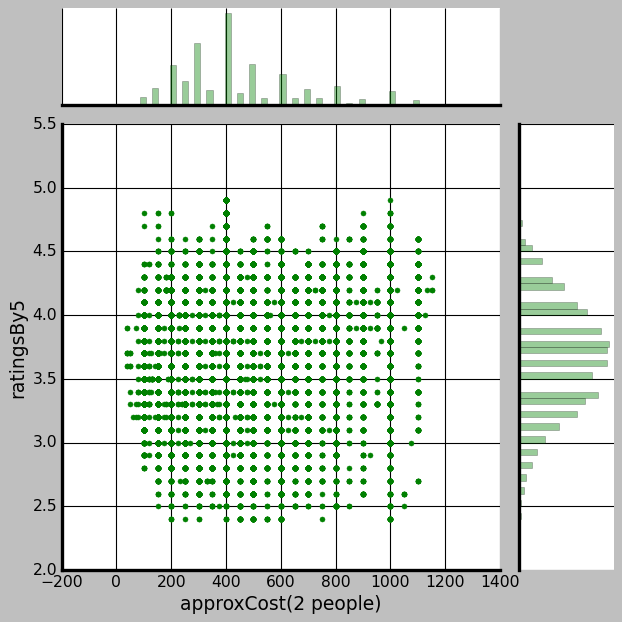

In [131]:
fig = plt.figure()
fig.patch.set_facecolor('lightcoral')
sns.jointplot(x = "approxCost(2 people)", y = "ratingsBy5", data = zomatoDataPandas_withoutOutliers, height=8, ratio=4, color="g");

### 26) Distribution of restaurant rating over online order facility

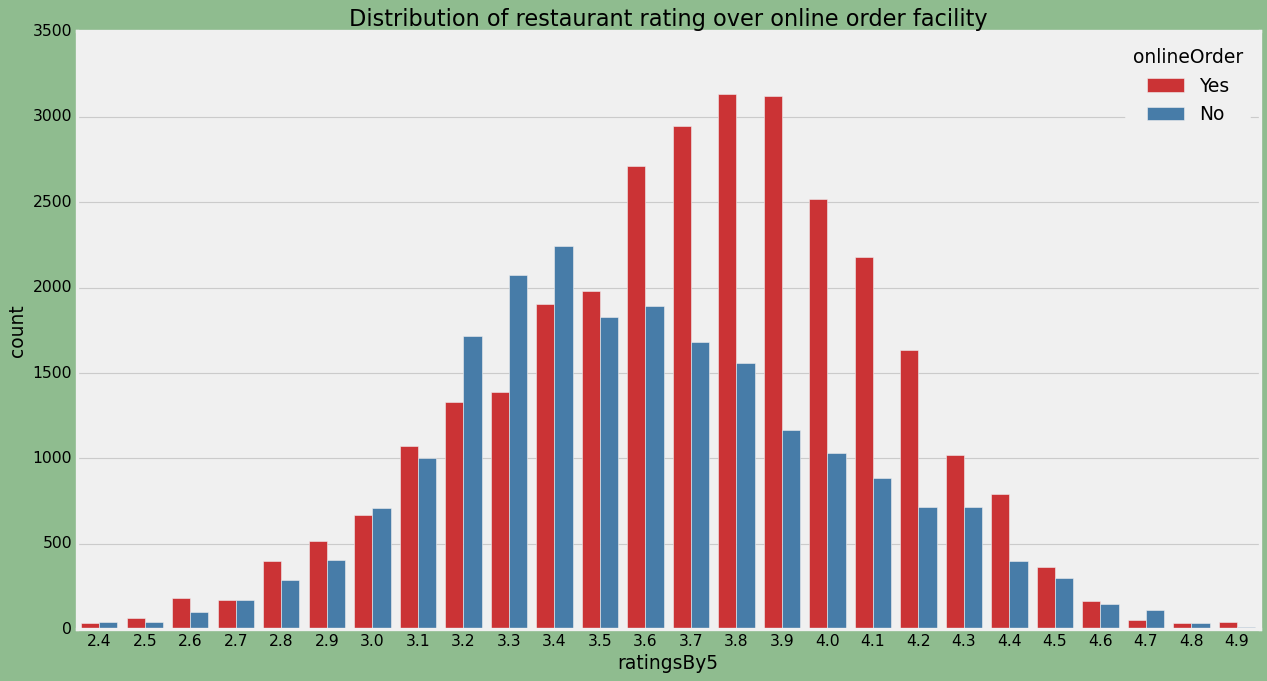

In [132]:
#checking whether online_order impacts rating of the restaurant
fig = plt.figure(figsize=(17,9))
fig.patch.set_facecolor('darkseagreen')
plt.style.use('fivethirtyeight')

sns.countplot(hue = zomatoDataPandas_withoutOutliers["onlineOrder"], palette = "Set1", x = zomatoDataPandas_withoutOutliers["ratingsBy5"])
plt.title("Distribution of restaurant rating over online order facility")
plt.show();

### 27) BookTable Vs ListedInType

In [133]:
zomatoDataPyspark_withoutOutliers.crosstab('bookTable','listedInType').show()

+----------------------+------+-----+--------+--------+--------+------------------+-------------+
|bookTable_listedInType|Buffet|Cafes|Delivery|Desserts|Dine-out|Drinks & nightlife|Pubs and bars|
+----------------------+------+-----+--------+--------+--------+------------------+-------------+
|                    No|   324| 1446|   23956|    3454|   15308|               437|          301|
|                   Yes|   557|  277|    1944|     139|    2465|               664|          395|
+----------------------+------+-----+--------+--------+--------+------------------+-------------+



<Figure size 1360x800 with 0 Axes>

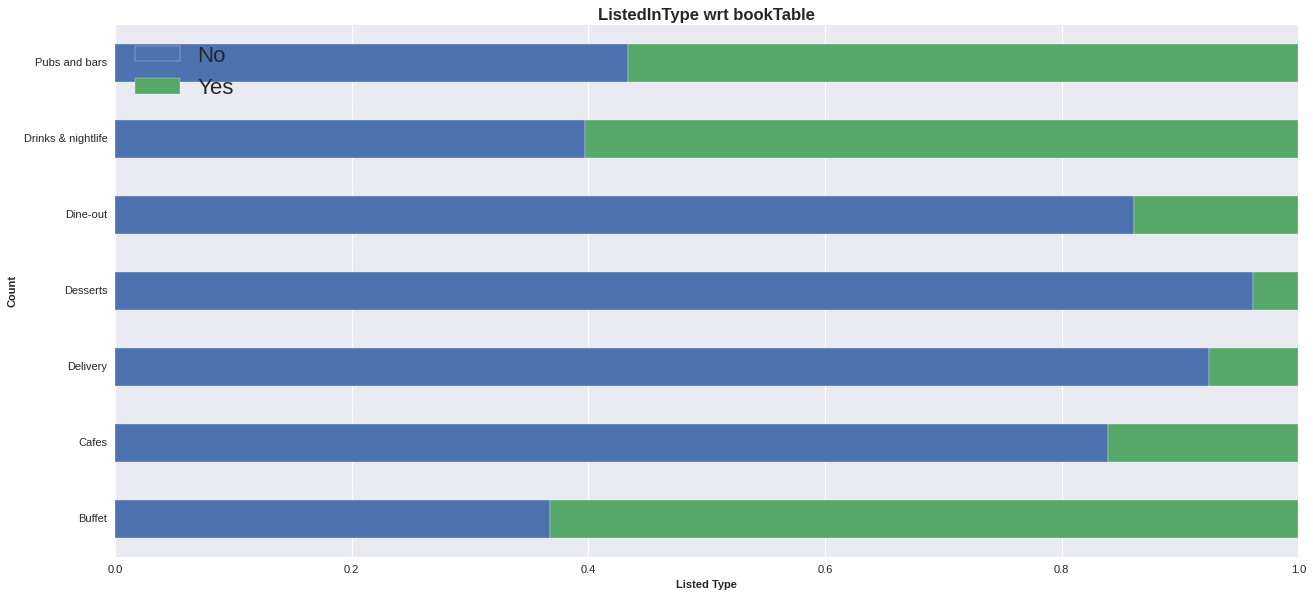

In [134]:
fig = plt.figure(figsize=(17,10))
plt.style.use('seaborn')

x = pd.crosstab(zomatoDataPandas_withoutOutliers.listedInType,zomatoDataPandas_withoutOutliers.bookTable)
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'barh', stacked = True,figsize=(17,8));
plt.title("ListedInType wrt bookTable",fontsize=15,fontweight='bold')
plt.xlabel("Listed Type",fontsize=10,fontweight='bold')
plt.ylabel("Count",fontsize=10,fontweight='bold')
plt.legend(loc='upper left',prop={'size':20});

WE OBSERVE THE FOLLOWING:

--------
1. We can observe Dine-out and Delivery are the once where most of the people have and haven't booked table.

### 28) ListedInType Vs Ratings

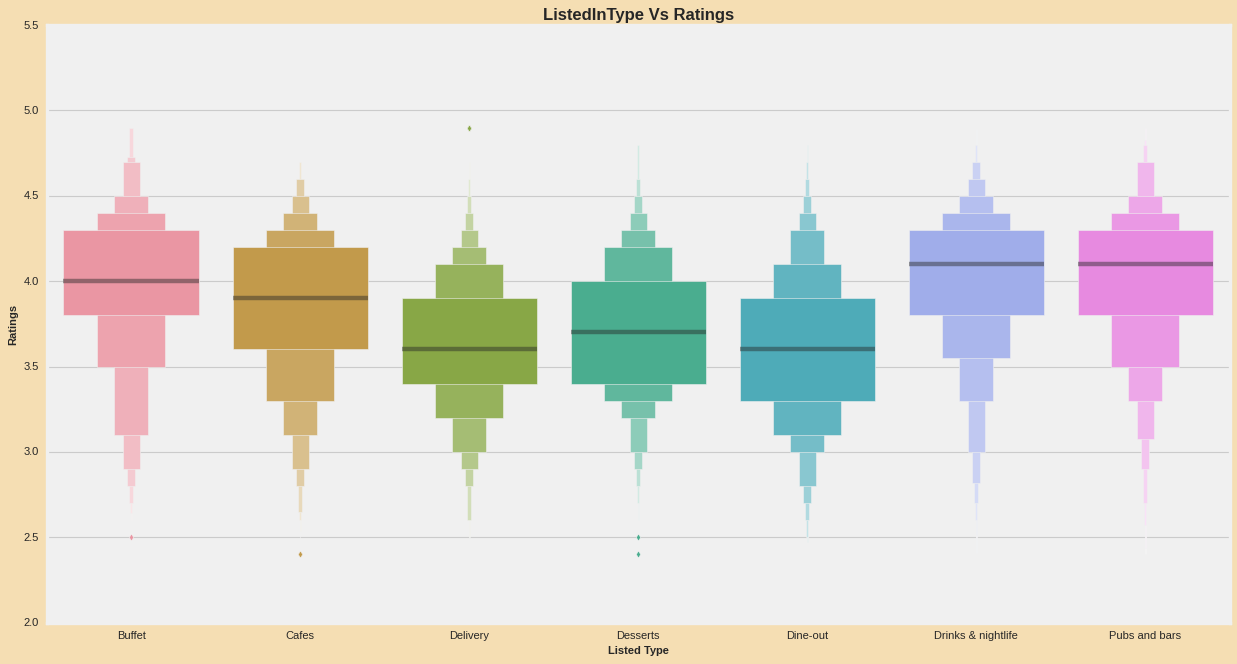

In [135]:
fig = plt.figure(figsize=(17,9))
fig.patch.set_facecolor('wheat')
plt.style.use('fivethirtyeight')

sns.boxenplot(x="listedInType", y="ratingsBy5", data = zomatoDataPandas_withoutOutliers)
plt.title("ListedInType Vs Ratings",fontsize=15,fontweight='bold')
plt.xlabel("Listed Type",fontsize=10,fontweight='bold')
plt.ylabel("Ratings",fontsize=10,fontweight='bold')
plt.show();

WE OBSERVE THE FOLLOWING:

---------
1. We can observe Dine-out and Delivery have less avg ratings than others.
2. Drinks and Pubs,Bars have the highest avg ratings among all ListedType.

### 29) Online Order Vs ListedInType

In [136]:
zomatoDataPyspark_withoutOutliers.crosstab('onlineOrder','listedInType').show()

+------------------------+------+-----+--------+--------+--------+------------------+-------------+
|onlineOrder_listedInType|Buffet|Cafes|Delivery|Desserts|Dine-out|Drinks & nightlife|Pubs and bars|
+------------------------+------+-----+--------+--------+--------+------------------+-------------+
|                      No|   528|  825|    7066|    1944|    9531|               864|          506|
|                     Yes|   353|  898|   18834|    1649|    8242|               237|          190|
+------------------------+------+-----+--------+--------+--------+------------------+-------------+



<Figure size 1360x800 with 0 Axes>

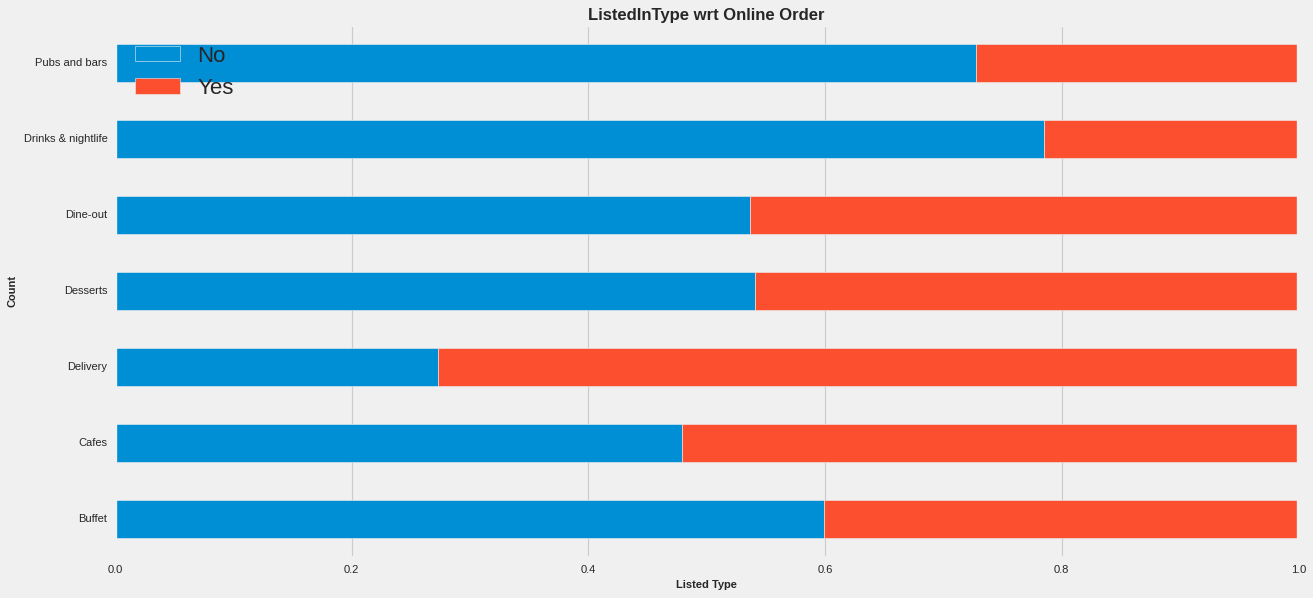

In [137]:
#ratings vs service type
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('yellowgreen')
plt.style.use('fivethirtyeight')

x = pd.crosstab(zomatoDataPandas_withoutOutliers.listedInType,zomatoDataPandas_withoutOutliers.onlineOrder)
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'barh', stacked = True,figsize=(17,8));
plt.title("ListedInType wrt Online Order",fontsize=15,fontweight='bold')
plt.xlabel("Listed Type",fontsize=10,fontweight='bold')
plt.ylabel("Count",fontsize=10,fontweight='bold')
plt.legend(loc='upper left',prop={'size':20});

WE OBSERVE THE FOLLOWING:

-------------
1. Delivery and Cafes have are again highest among both Online order and non online orders.
2. As expected most of the restaurants which provide online order option also delivers food
3. Many of the Buffet type restaurants doesn't provide an option of online order
4. Very few Pubs and bars and Drinks,LifeStyle has option of order online, that makes sense

### 30) Show the Max and Min Ratings wrt each ListedInCity

In [138]:
avgCityWiseRating = zomatoDataPandas_withoutOutliers.groupby('listedInCity').agg({'ratingsBy5':['max','min']}).reset_index()
avgCityWiseRating.columns =['listedInCity','MaxRating','MinRating']
avgCityWiseRating.head(15)

listedInCity  MaxRating  MinRating
0                 BTM        4.9        2.4
1        Banashankari        4.7        2.5
2   Bannerghatta Road        4.7        2.4
3        Basavanagudi        4.8        2.5
4           Bellandur        4.9        2.4
5        Brigade Road        4.9        2.5
6         Brookefield        4.9        2.4
7       Church Street        4.9        2.5
8     Electronic City        4.7        2.4
9         Frazer Town        4.9        2.4
10                HSR        4.7        2.4
11        Indiranagar        4.9        2.4
12           JP Nagar        4.9        2.4
13          Jayanagar        4.9        2.5
14       Kalyan Nagar        4.8        2.4

### 31) Top 20 ListedInCity in bangalore

In [139]:
zomatoDataPyspark_withoutOutliers.groupBy('listedInCity').count().orderBy('count',ascending=False).toPandas().head(20)

listedInCity  count
0                     BTM   3270
1   Koramangala 7th Block   2938
2   Koramangala 5th Block   2836
3   Koramangala 4th Block   2778
4   Koramangala 6th Block   2623
5               Jayanagar   2366
6                JP Nagar   2096
7             Indiranagar   1858
8           Church Street   1809
9                 MG Road   1807
10           Brigade Road   1769
11                    HSR   1741
12           Lavelle Road   1741
13           Marathahalli   1658
14         Residency Road   1620
15             Whitefield   1619
16      Bannerghatta Road   1617
17            Brookefield   1517
18       Old Airport Road   1424
19           Kammanahalli   1328

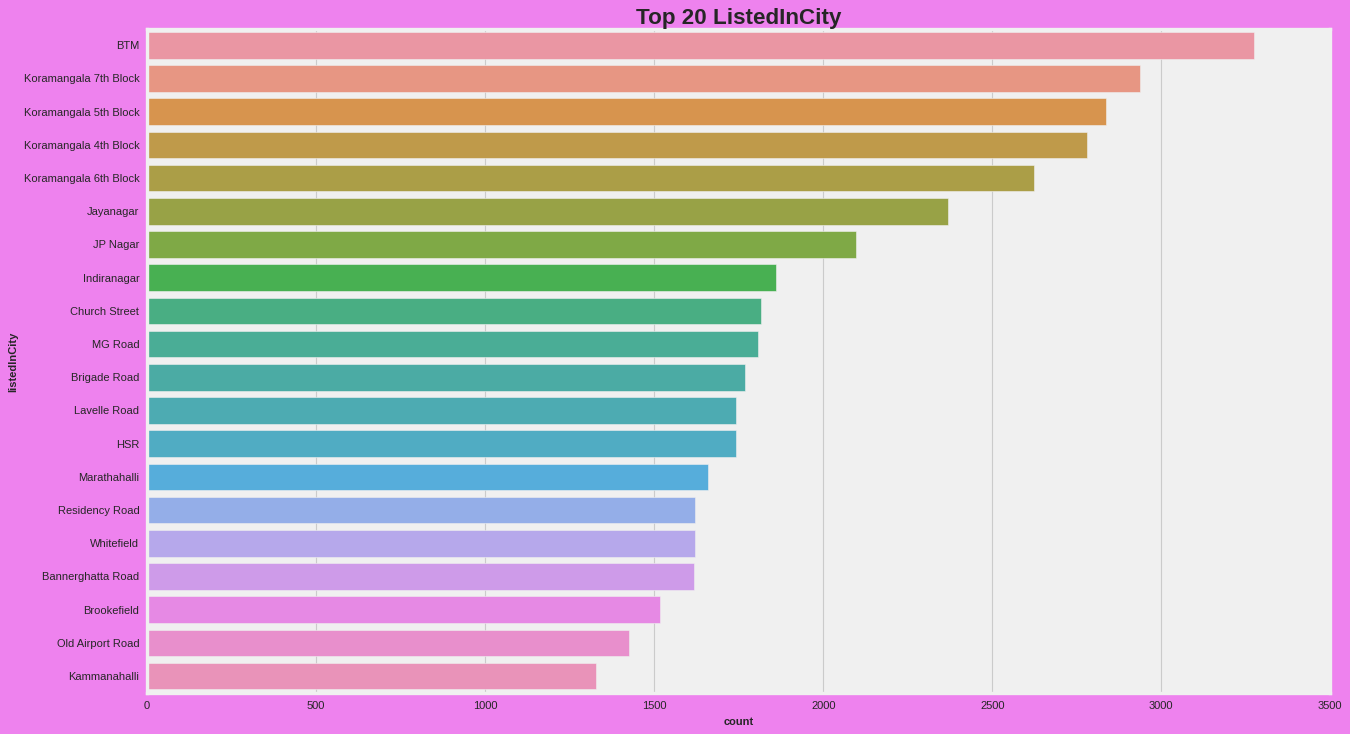

In [140]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('violet')
plt.style.use('fivethirtyeight')

sns.countplot(y='listedInCity', data=zomatoDataPandas_withoutOutliers,order=zomatoDataPandas_withoutOutliers.listedInCity.value_counts().head(20).index);
plt.title("Top 20 ListedInCity",fontweight='bold')
plt.xlabel('count',fontsize=10,fontweight='bold')
plt.ylabel('listedInCity',fontsize=10,fontweight='bold');
#palette="Blues_d"

WE OBSERVE THE FOLLOWING:

------
1. We can observe BTM is the city where most of the restaurants are there followed by Koramangala Jayanagar	and JP Nagar.

### 32) ListedInCity Vs Avg Rating wrt Online Order and Table Book

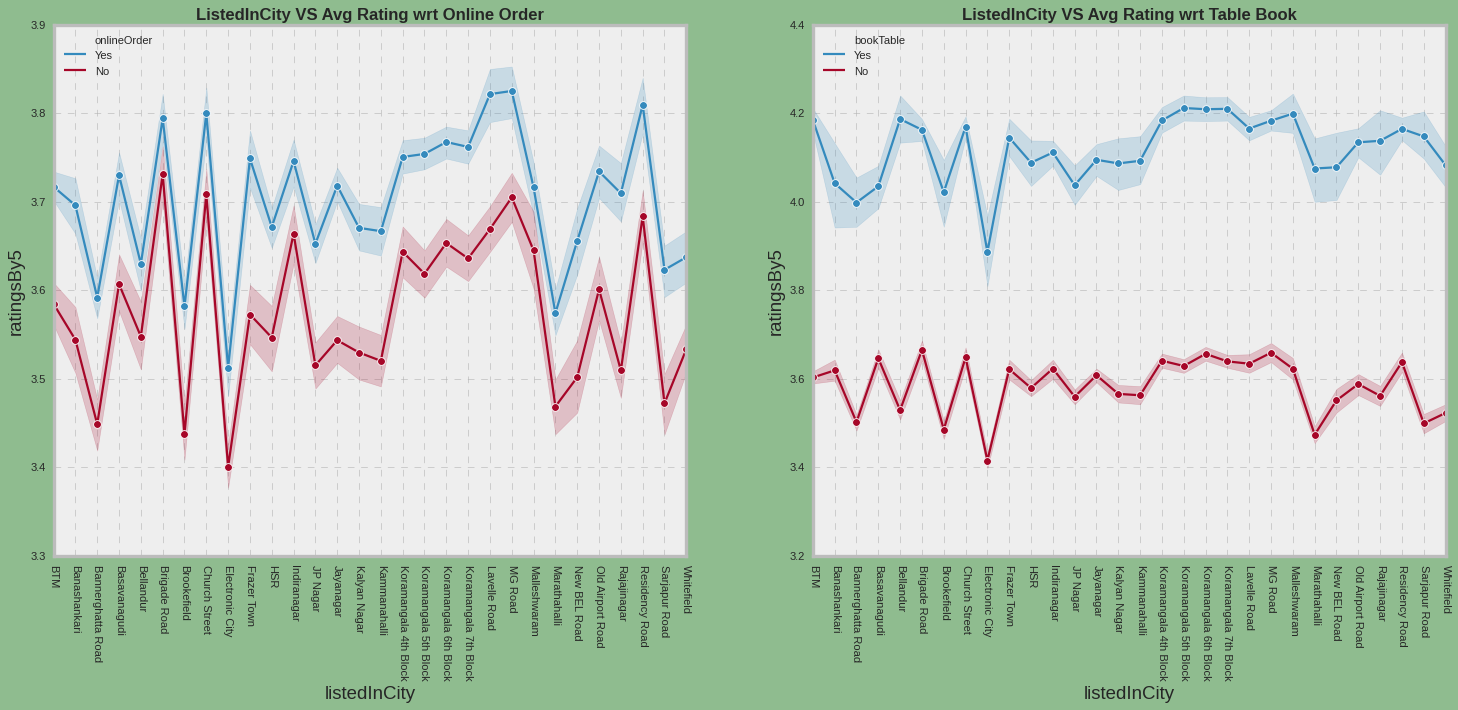

In [141]:
fig = plt.figure(figsize=(20,8))
fig.patch.set_facecolor('darkseagreen')
plt.style.use('bmh')

plt.subplot(121)
sns.lineplot(y=zomatoDataPandas_withoutOutliers.ratingsBy5 ,x=zomatoDataPandas_withoutOutliers.listedInCity,data=zomatoDataPandas_withoutOutliers,markers=True,marker='o',hue=zomatoDataPandas_withoutOutliers.onlineOrder);
plt.title("ListedInCity VS Avg Rating wrt Online Order",fontweight='bold',fontsize=15)
plt.legend(loc= 'upper left')
plt.xticks(rotation=270);

plt.subplot(122)
sns.lineplot(y=zomatoDataPandas_withoutOutliers.ratingsBy5 ,x=zomatoDataPandas_withoutOutliers.listedInCity,data=zomatoDataPandas_withoutOutliers,markers=True,marker='o',hue=zomatoDataPandas_withoutOutliers.bookTable);
plt.title("ListedInCity VS Avg Rating wrt Table Book",fontweight='bold',fontsize=15)
plt.xticks(rotation=270);
plt.legend(loc= 'upper left');

WE OBSERVE THE FOLLOWING:

----------
1. Online Orders ratings are mostly above average ,Though BTM is the city where most of the restaurants there but ratings for both online and non online orders are less compared to cities like MG Road, Labelle Road and many more.

2. MG Road, Labelle Road,Church Street,Brigade Road and Residency road are the cities which are rated the best among all cities for both Online Orders and non Online Orders.

3. Bannerghatta Road,Brookefield,Electronic City, Marathahalli,Sarajapur Road are the cities which are rated very bad among all cities for both Online Orders and non Online Orders.

4. For Table Booking we can Ratings for non table booking are below average that table bookings and there is simalar pattern observed which was observed in Online Orders. The best cities for online orders gets high ratings for table bookings and vice versa.

### 33)  ListedInCity Vs Avg Voting wrt Online Order and Table Book

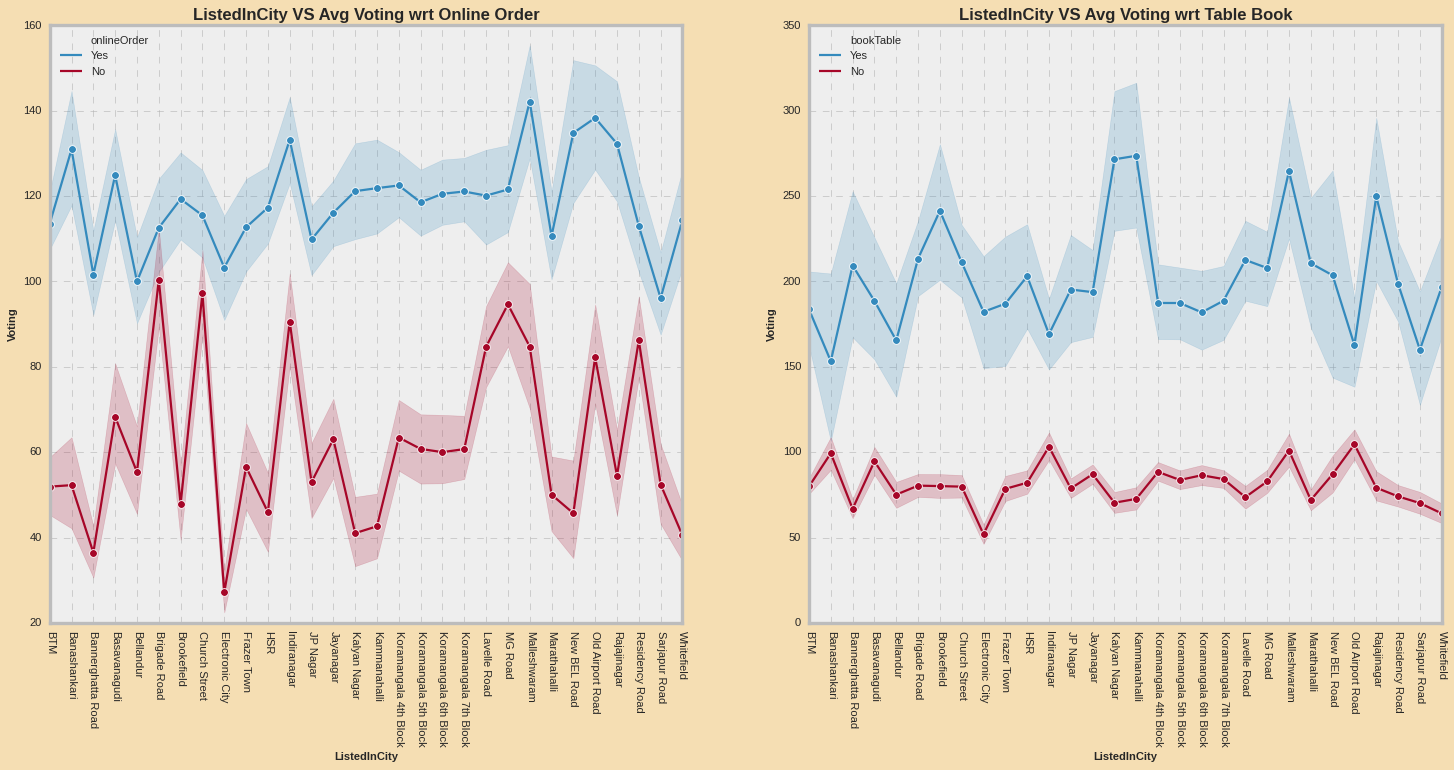

In [142]:
fig = plt.figure(figsize=(20,9))
fig.patch.set_facecolor('wheat')
plt.style.use('bmh')
plt.subplot(121)
sns.lineplot(y=zomatoDataPandas_withoutOutliers.votes ,x=zomatoDataPandas_withoutOutliers.listedInCity,data=zomatoDataPandas_withoutOutliers,markers=True,marker='o',hue=zomatoDataPandas_withoutOutliers.onlineOrder);
plt.title("ListedInCity VS Avg Voting wrt Online Order",fontweight='bold',fontsize=15)
plt.xlabel("ListedInCity",fontweight='bold',fontsize=10)
plt.ylabel("Voting",fontweight='bold',fontsize=10)
plt.legend(loc= 'upper left')
plt.xticks(rotation=270);

plt.subplot(122)
sns.lineplot(y=zomatoDataPandas_withoutOutliers.votes ,x=zomatoDataPandas_withoutOutliers.listedInCity,data=zomatoDataPandas_withoutOutliers,markers=True,marker='o',hue=zomatoDataPandas_withoutOutliers.bookTable);
plt.title("ListedInCity VS Avg Voting wrt Table Book",fontweight='bold',fontsize=15)
plt.xlabel("ListedInCity",fontweight='bold',fontsize=10)
plt.ylabel("Voting",fontweight='bold',fontsize=10)
plt.xticks(rotation=270);
plt.legend(loc= 'upper left');

WE OBSERVE THE FOLLOWING:

--------
1. We can observe that Online order and Table Bookings gets more Votings than Non Online Order and Non Table Bookings.

2. Banashankari,IndiraNagar,Malleshwaram,Old Airport Road are the cities which got highest votings among all cities for Online Orders.
3. Bridhe Road,Chrurch Street,Indiranagar,MG Road,Residency Road are the cities which got highest votings among all cities for Non Online Orders.

4. Kalyan Nagar,Kammanahali,Malleshwaram,Rajinangar are the cities which got highest votings among all cities for providing Table Bookings.
5. Electronic City,Whitefield,Sarjapur Road,Marathahalli are the cities which got lowest votings among all cities for not Table Bookings.

### 34) ListedInCity Vs Avg Cost writ Online Order and Table Book

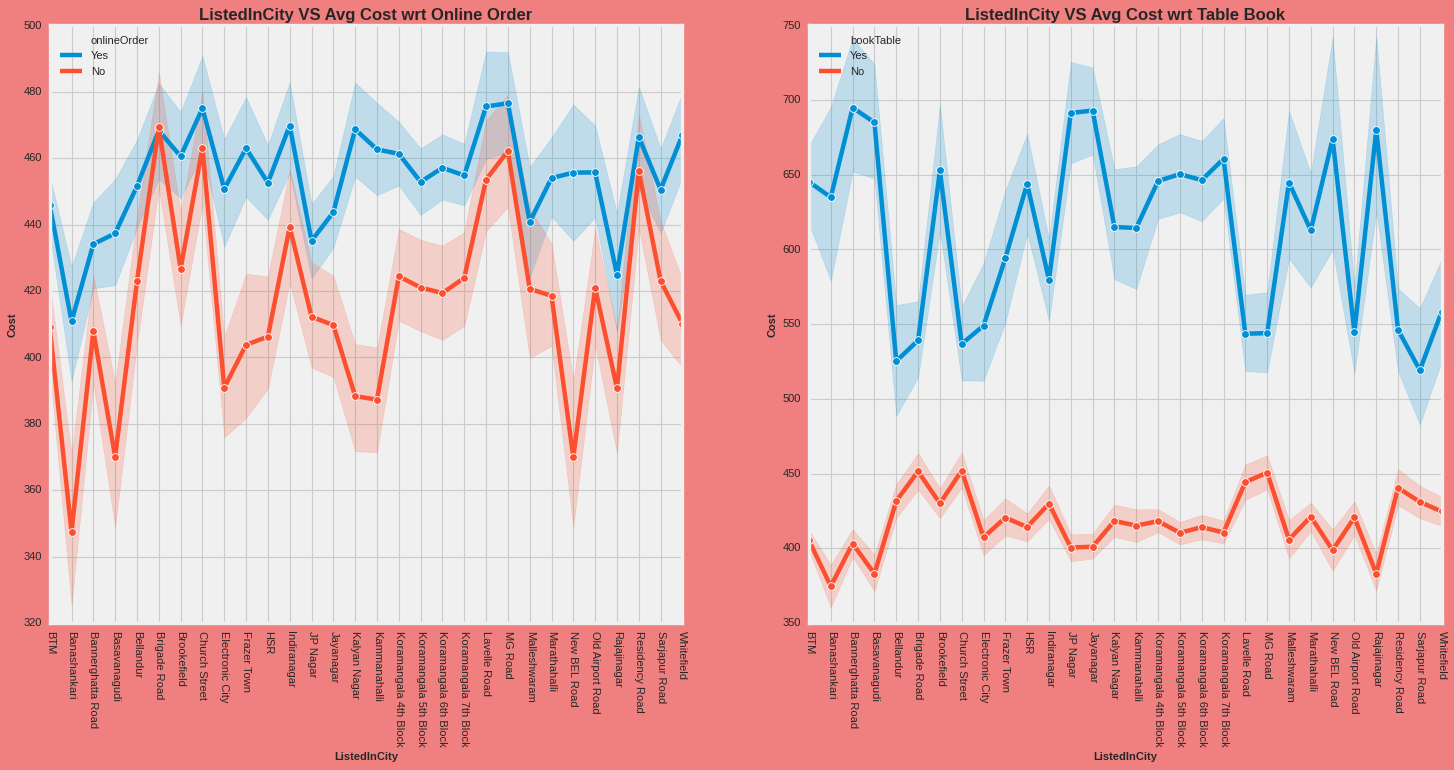

In [143]:
fig = plt.figure(figsize=(20,9))
fig.patch.set_facecolor('lightcoral')
plt.style.use('fivethirtyeight')


plt.subplot(121)
sns.lineplot(y=zomatoDataPandas_withoutOutliers['approxCost(2 people)'] ,x=zomatoDataPandas_withoutOutliers.listedInCity,data=zomatoDataPandas_withoutOutliers,markers=True,marker='o',hue=zomatoDataPandas_withoutOutliers.onlineOrder);
plt.title("ListedInCity VS Avg Cost wrt Online Order",fontweight='bold',fontsize=15)
plt.xlabel("ListedInCity",fontweight='bold',fontsize=10)
plt.ylabel("Cost",fontweight='bold',fontsize=10)
plt.legend(loc= 'upper left')
plt.xticks(rotation=270);

plt.subplot(122)
sns.lineplot(y=zomatoDataPandas_withoutOutliers['approxCost(2 people)'] ,x=zomatoDataPandas_withoutOutliers.listedInCity,data=zomatoDataPandas_withoutOutliers,markers=True,marker='o',hue=zomatoDataPandas_withoutOutliers.bookTable);
plt.title("ListedInCity VS Avg Cost wrt Table Book",fontweight='bold',fontsize=15)
plt.xlabel("ListedInCity",fontweight='bold',fontsize=10)
plt.ylabel("Cost",fontweight='bold',fontsize=10)
plt.xticks(rotation=270);
plt.legend(loc= 'upper left');

WE OBSERVE THE FOLLOWING:

----------
1. We can notice cost of food in a city doesn't vary much in online and offline orders,though being online order costlier.

2. Bridade Road,Church Street,MG Road,Indranager,Kalyan Nagar and Lavelle Road are the city are costlier for online orders.
3. Bridade Road,Church Street,MG Road,Residency Road and Lavelle Road are the city are costlier for offline orders.
4. We can see cities like Baneshankari,kalyan nagar,Kammanahali,Basavanagudi,and New BEL Road do vary by almost 100 rupees for its online and offline order.

5. Table booking cost for food in a city varies around 200-300 more for booking, with Bannerrghatta Road,Basavanagaudi,JP Nagar,Jayanagar,and Rajajinangar having highest cost for booking.

WE OBSERVE THE FOLLOWING: (Final result with above 3 plots)

----------

1. Based of above 3 plot insights we can findout which City is best if the customer wants to buy food online or go the restaurants.
2. We can even know which city is the best if we want to book the table in restaurant or not.

### 35) Total Cuisines in Bangalore

In [144]:
allCuisines = set()

for i in zomatoDataPandas_withoutOutliers.cuisines:
    for j in i.split(', '):
        allCuisines.add(j)    
        
print("There are total {0} Cuisines that are available in bangalore".format(len(allCuisines)))

There are total 107 Cuisines that are available in bangalore


In [145]:
top5RestCuis = zomatoDataPyspark_withoutOutliers.filter(zomatoDataPyspark_withoutOutliers['ratingsBy5']>=4.5)
top5RestCuis.registerTempTable('top5RestCuisTable')

### 36) Top 2 Restaurant with Ratings more than 4.5 for each listedInType

In [146]:
spark.sql('select listedInType,name,total,rnk from (select listedInType,name,total, dense_rank() \
over(partition by listedInType order by total desc ) rnk from (select distinct listedInType,name,count(name) \
as total from top5RestCuisTable group by 1,2 order by total desc)) where rnk <3 order by 1,3 desc').show(25)

+------------------+--------------------+-----+---+
|      listedInType|                name|total|rnk|
+------------------+--------------------+-----+---+
|            Buffet|     Barbeque Nation|   10|  1|
|            Buffet|AB's - Absolute B...|    8|  2|
|            Buffet|      Mainland China|    8|  2|
|             Cafes|            Truffles|   14|  1|
|             Cafes|            Hammered|    7|  2|
|          Delivery|             eat.fit|   16|  1|
|          Delivery|Belgian Waffle Fa...|   16|  1|
|          Delivery|        Pasta Street|   15|  2|
|          Desserts|Corner House Ice ...|   15|  1|
|          Desserts|Belgian Waffle Fa...|   13|  2|
|          Dine-out|            Truffles|   14|  1|
|          Dine-out|             Chianti|   13|  2|
|Drinks & nightlife|    Gilly's Restobar|    7|  1|
|Drinks & nightlife|            Hammered|    7|  1|
|Drinks & nightlife|    House Of Commons|    6|  2|
|Drinks & nightlife|          Biergarten|    6|  2|
|Drinks & ni

In [147]:
top2RestCus= spark.sql('select listedInType,name,total,rnk from (select listedInType,name,total, dense_rank() \
over(partition by listedInType order by total desc ) rnk from (select distinct listedInType,name,count(name) \
as total from top5RestCuisTable group by 1,2 order by total desc)) where rnk <3 order by 1,3 desc').toPandas()

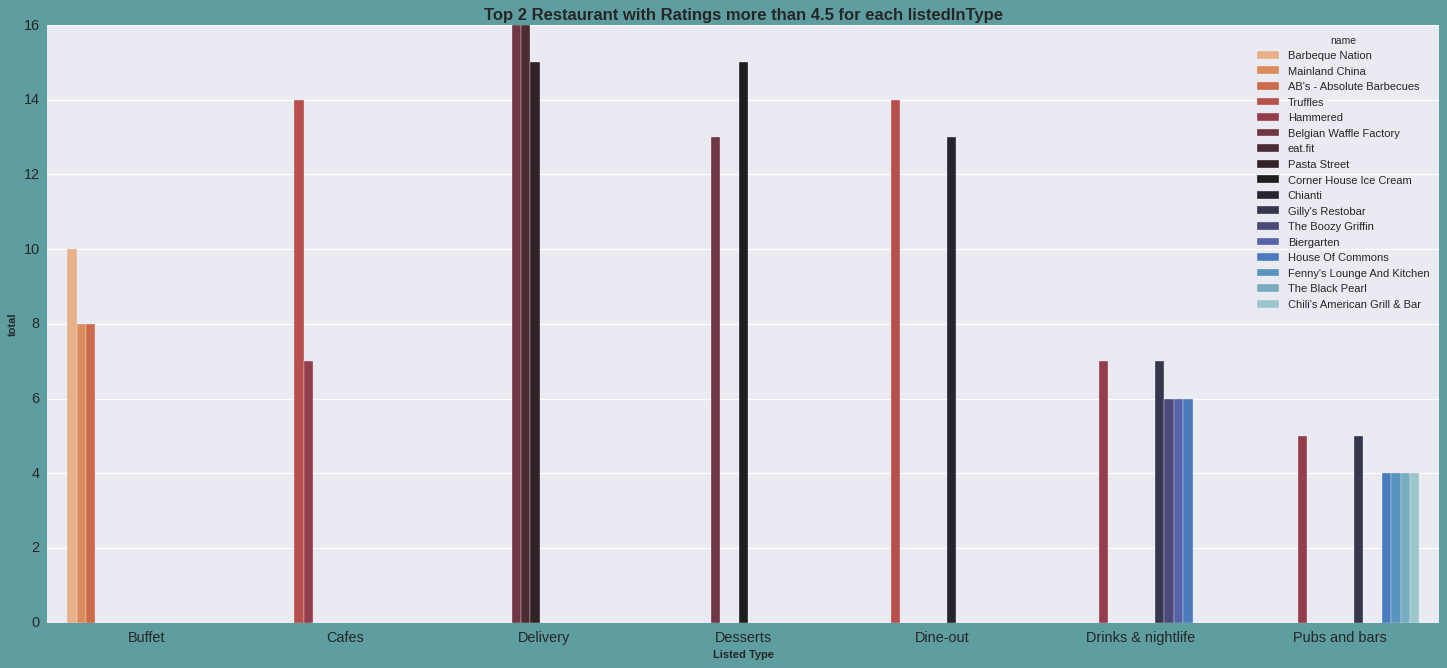

In [148]:
fig = plt.figure(figsize=(20,9))
fig.patch.set_facecolor('cadetblue')
plt.style.use('seaborn')

plt.title('Top 2 Restaurant with Ratings more than 4.5 for each listedInType',fontsize=15,fontweight='bold');
#sns.catplot(data=top5RestCus,x='name',y='total',col='listedInType',kind='bar',col_wrap=3);
sns.barplot(data=top2RestCus,x='listedInType',y='total',hue='name',palette='icefire_r');
plt.ylabel('total',fontsize=10,fontweight='bold')
plt.xlabel('Listed Type',fontsize=10,fontweight='bold')
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);

### 37)Biggest Restaurant Chain and Best Restaurant Chain

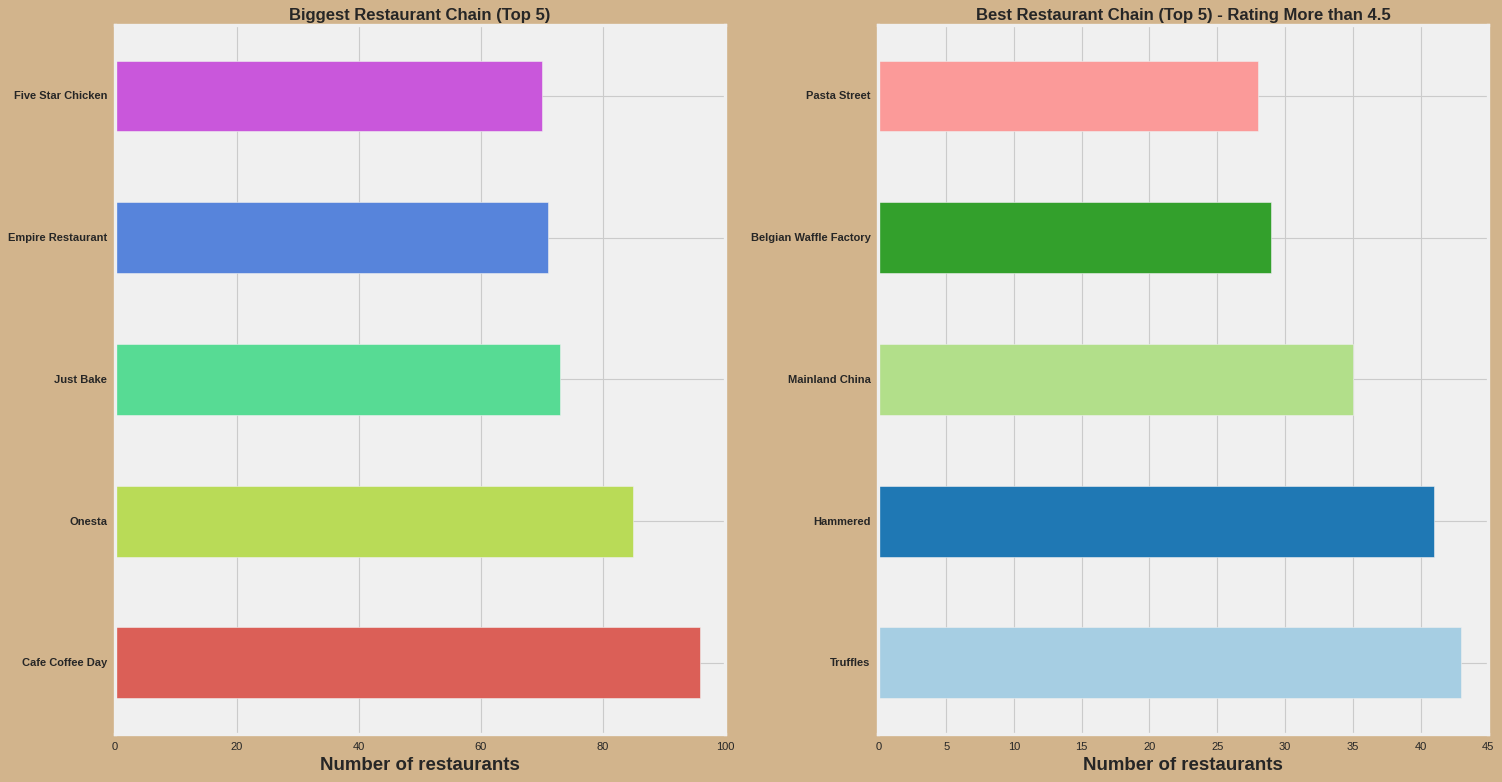

In [149]:
fig = plt.figure(figsize=(19,10))
fig.patch.set_facecolor('tan')
plt.style.use('fivethirtyeight')

plt.rcParams['figure.figsize'] = 19,10
plt.subplot(1,2,1)
ax = zomatoDataPandas_withoutOutliers.name.value_counts().head().plot(kind = "barh", color = sns.color_palette("hls", 5))
plt.xlabel("Number of restaurants",fontweight='bold')
plt.yticks(fontweight='bold')
plt.title("Biggest Restaurant Chain (Top 5)",fontweight='bold',fontsize=15);

plt.subplot(1,2,2)
zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['ratingsBy5']>=4.5]['name'].value_counts().nlargest(5).plot(kind = "barh", color = sns.color_palette("Paired"))
plt.xlabel("Number of restaurants",fontweight='bold')
plt.yticks(fontweight='bold')
plt.title("Best Restaurant Chain (Top 5) - Rating More than 4.5",fontweight='bold',fontsize=15);
plt.tight_layout();

WE OBSERVE THE FOLLOWING:

------
1. Cafe Coffee Day & Onesta has biggest restaurants chains across the city
2. Truffles and Hammered are the good restaurants - rating more than 4.5

### 38) WordCloud for Dishes liked by Bangalorean

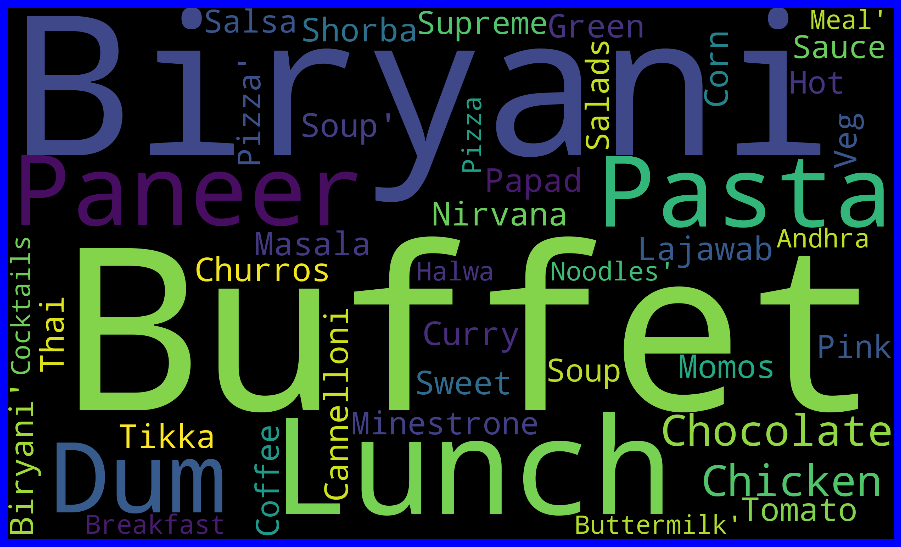

In [150]:
#Dishes liked by Banagloreans
c1 = ''.join(str(zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['dishLiked']!= 'Unknown']['dishLiked'].values))
from wordcloud import WordCloud
plt.figure(figsize=(15,8),facecolor = 'blue');
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=True,
                      width=2500, height=1500).generate(c1)
plt.imshow(wordcloud)
plt.axis("off");

WE OBSERVE THE FOLLOWING:

---------

1. We see Briyani,Buffet,Paneer,Chicken,Pasta,Chololate,Papad,Cocktail,Pasta,Lunch,Momoes,Pizza are the Dishes liked by bangaloreans in restaurants.

### 39) WordCloud for Dishes liked by bangaloreans in North India restaurants

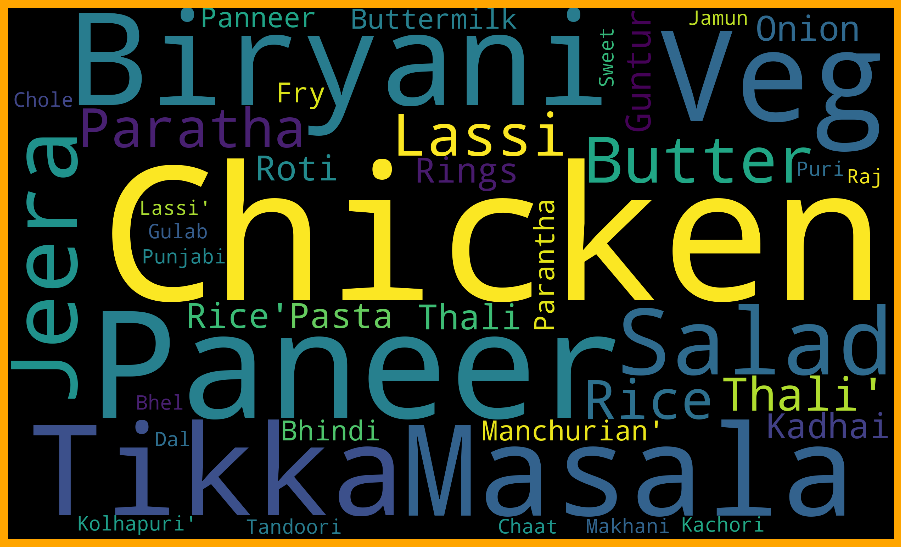

In [151]:
northIndia_restaurants = zomatoDataPandas_withoutOutliers[(zomatoDataPandas_withoutOutliers['cuisines']== 'North Indian') & (zomatoDataPandas_withoutOutliers['dishLiked'] !='Unknown') ]

c1 = ''.join(str(northIndia_restaurants['dishLiked'].values))
from wordcloud import WordCloud
plt.figure(figsize=(15,8),facecolor = 'orange')
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=True,
                      width=2500, height=1500).generate(c1)
plt.imshow(wordcloud)
plt.axis("off");

WE OBSERVE THE FOLLOWING:

---------
We see Briyani,Chicken,Paneer Tikka,Lassi,Salad,Veg Thali,Paratha,Rice are the Dishes liked by bangaloreans in North India restaurants

### 40) WordCloud for Dishes liked by bangaloreans in South Indian restaurants.

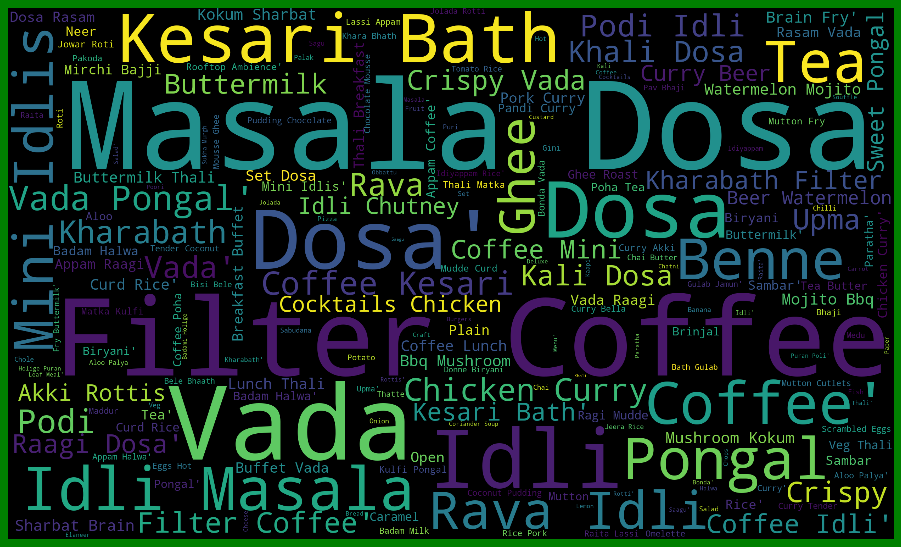

In [152]:
# Dishes liked by banglorans in South Indian restaurants
southIndian_restaurants = zomatoDataPandas_withoutOutliers[(zomatoDataPandas_withoutOutliers['cuisines']== 'South Indian') & (zomatoDataPandas_withoutOutliers['dishLiked'] !='Unknown') ]

c1 = ''.join(str(southIndian_restaurants['dishLiked'].values))
from wordcloud import WordCloud
plt.figure(figsize=(15,8),facecolor = 'green')
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=True,
                      width=2500, height=1500).generate(c1)
plt.imshow(wordcloud)
plt.axis("off");

WE OBSERVE THE FOLLOWING:

------------

1. We see Masala Dosa,Filter Coffee,Vada,Khali Dosa,Rava Idli,Butter Milk,Kesari bath,Benne are the Dishes liked by bangaloreans in South Indian restaurants.

### 41) WordCloud for Dishes liked by bangaloreans in Fast Food restaurants

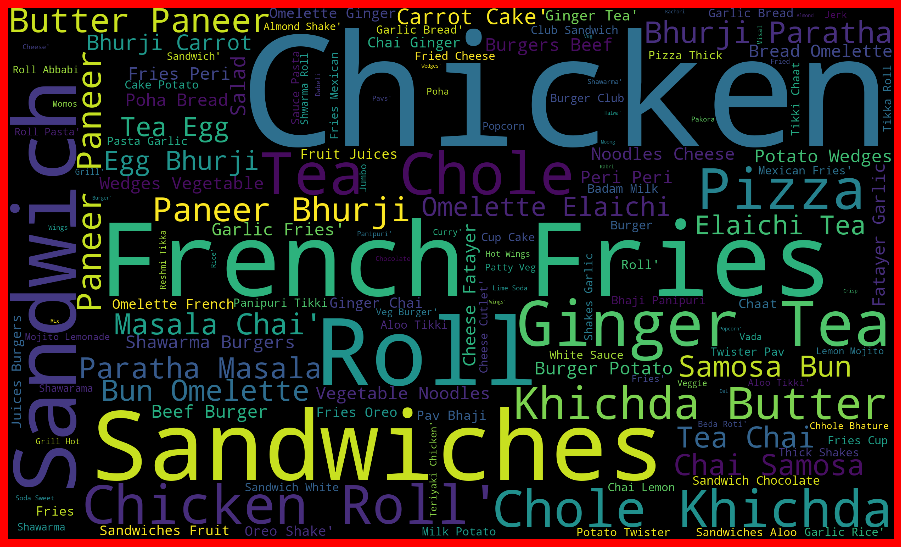

In [153]:
fastFood_restaurants = zomatoDataPandas_withoutOutliers[(zomatoDataPandas_withoutOutliers['cuisines']== 'Fast Food') & (zomatoDataPandas_withoutOutliers['dishLiked'] !='Unknown') ]

c1 = ''.join(str(fastFood_restaurants['dishLiked'].values))
from wordcloud import WordCloud
plt.figure(figsize=(15,8),facecolor = 'red')
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=True,
                      width=2500, height=1500).generate(c1)
plt.imshow(wordcloud)
plt.axis("off");

WE OBSERVE THE FOLLOWING:

-------------
1. We see Paneer Roll,Sandwiches,Burji paratha,Chicken Roll,Chole,Ginger Tea,French Fries,Chai Samosa,Khichda Butter,Omelette,Salad and Pizza are the Dishes liked by bangaloreans in Fast Food restaurants

### 42) WordCloud for Dishes liked by bangaloreans in Desserts, Ice cream Parlors

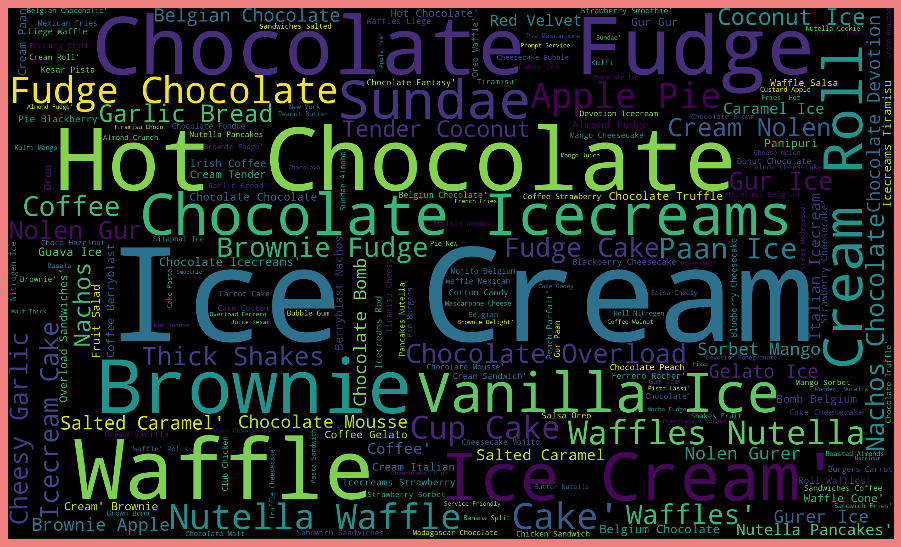

In [154]:
desert_restaurants = zomatoDataPandas_withoutOutliers[((zomatoDataPandas_withoutOutliers['cuisines']== 'Ice Cream, Desserts') | (zomatoDataPandas_withoutOutliers['cuisines']== 'Desserts, Ice Cream')  | (zomatoDataPandas_withoutOutliers['cuisines']== 'Desserts')) & (zomatoDataPandas_withoutOutliers['dishLiked'] !='Unknown') ]

c1 = ''.join(str(desert_restaurants['dishLiked'].values))
from wordcloud import WordCloud
plt.figure(figsize=(15,8),facecolor = 'lightcoral')
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=True,
                      width=2500, height=1500).generate(c1)
plt.imshow(wordcloud)
plt.axis("off");

WE OBSERVE THE FOLLOWING:

----------

1. We see Chocolate Ice Creams,Brownie,Vanilla,Waffle,Chocolate Fudge,Nutella,Cream Roll,Frudge Cake,Sundae and Nachos Chocolate are the Dishes liked by bangaloreans in Desserts, Ice cream Parlors

### 43) Most popular restaurant-types in each City

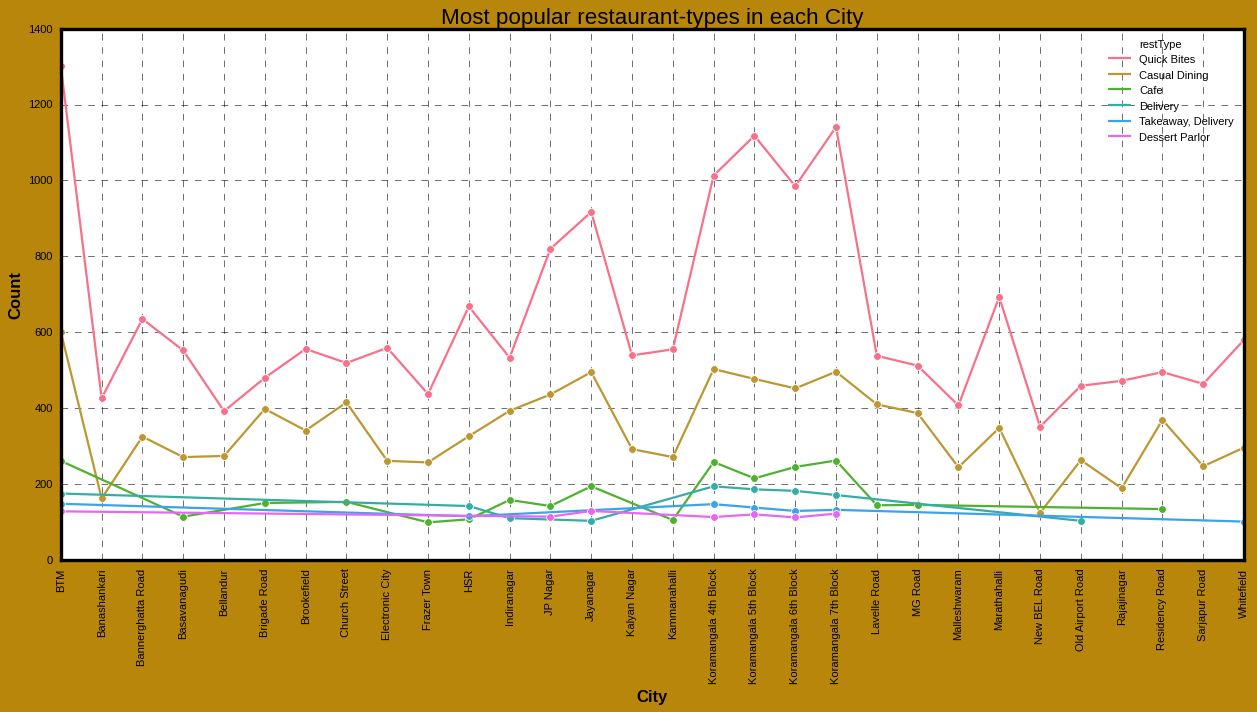

In [155]:
fig = plt.figure(figsize=(17,8))
fig.patch.set_facecolor('darkgoldenrod')
plt.style.use('bmh')
plt.style.use('grayscale')

popularRestEachCity = zomatoDataPandas_withoutOutliers.groupby(['listedInCity','restType']).agg('count').sort_values(['name'],ascending=False)['name'][:100].reset_index()
popularRestEachCity.columns=['listedInCity','restType','count']
sns.lineplot(data=popularRestEachCity, x='listedInCity',y='count', hue='restType',markers=True,marker='o', dashes=True)
plt.xticks(rotation=90)
plt.title("Most popular restaurant-types in each City");
plt.xlabel('City',fontsize=15,fontweight='bold');
plt.ylabel('Count',fontsize=15,fontweight='bold');

WE OBSERVE THE FOLLOWING:

----
As we can see, quick bites and Casual Dining are the most popular restaurant type for each suburb across the City, Let's also explore the most poplular restaurants in quick bites.

### 44) 5 Most popular Cities wrt Top 5 restaurant-types

In [156]:
top5resType = zomatoDataPandas.restType.value_counts().index[:6].tolist()

top5CityResType = zomatoDataPyspark_withoutOutliers.filter(zomatoDataPyspark_withoutOutliers['restType'].isin(top5resType))
top5CityResType.registerTempTable('Top5RestTypeData')

In [157]:
spark.sql("select restType,listedInCity,frequency,rnk from (select restType,listedInCity,frequency,dense_rank() \
OVER (PARTITION BY restType ORDER BY frequency desc) rnk from (select distinct restType,listedInCity, \
count(listedInCity) as frequency from Top5RestTypeData group by restType,listedInCity)) where rnk<=5 \
order by 1,3 desc").show(20)

+--------------+--------------------+---------+---+
|      restType|        listedInCity|frequency|rnk|
+--------------+--------------------+---------+---+
|          Cafe|Koramangala 7th B...|      262|  1|
|          Cafe|                 BTM|      261|  2|
|          Cafe|Koramangala 4th B...|      258|  3|
|          Cafe|Koramangala 6th B...|      245|  4|
|          Cafe|Koramangala 5th B...|      215|  5|
| Casual Dining|                 BTM|      601|  1|
| Casual Dining|Koramangala 4th B...|      503|  2|
| Casual Dining|Koramangala 7th B...|      496|  3|
| Casual Dining|           Jayanagar|      495|  4|
| Casual Dining|Koramangala 5th B...|      477|  5|
|      Delivery|Koramangala 4th B...|      194|  1|
|      Delivery|Koramangala 5th B...|      186|  2|
|      Delivery|Koramangala 6th B...|      182|  3|
|      Delivery|                 BTM|      174|  4|
|      Delivery|Koramangala 7th B...|      171|  5|
|Dessert Parlor|           Jayanagar|      129|  1|
|Dessert Par

In [158]:
top5CityResType = spark.sql("select restType,listedInCity,frequency,rnk from (select restType,listedInCity,frequency,dense_rank() \
OVER (PARTITION BY restType ORDER BY frequency desc) rnk from (select distinct restType,listedInCity, \
count(listedInCity) as frequency from Top5RestTypeData group by restType,listedInCity)) where rnk<=5 \
order by 1,3 desc").toPandas()

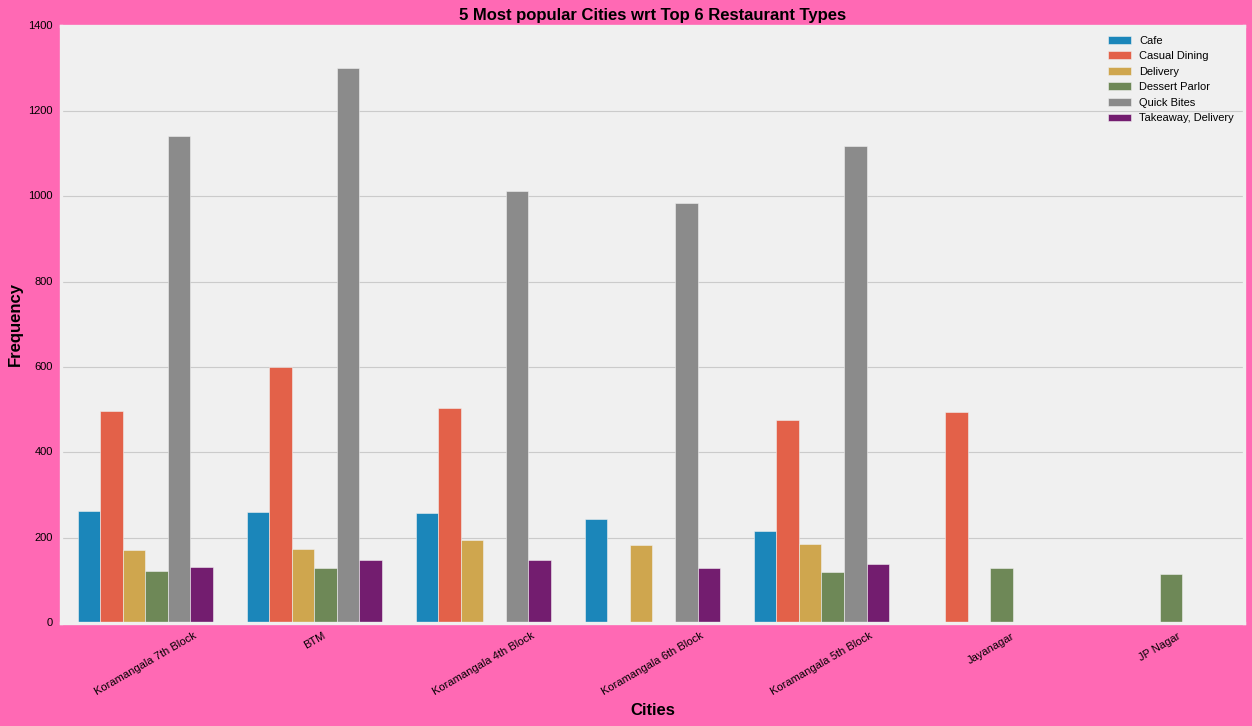

In [159]:
fig = plt.figure(figsize=(17,9))
fig.patch.set_facecolor('hotpink')
plt.style.use('fivethirtyeight')

sns.barplot(data=top5CityResType,hue='restType',y='frequency',x='listedInCity');
plt.xticks(rotation=30);
plt.legend(loc='upper right')
plt.title("5 Most popular Cities wrt Top 6 Restaurant Types",fontsize=15,fontweight='bold');
plt.xlabel('Cities',fontsize=15,fontweight='bold');
plt.ylabel('Frequency',fontsize=15,fontweight='bold');

WE OBSERVE THE FOLLOWING:

-----
1. We can observe BTM,Koramangala, jayanagar,JP Nagar are the most popular citys for the top 6 restaurant Type

### 45) Top 20 Resturants wrt Top 2 Restaurant Types

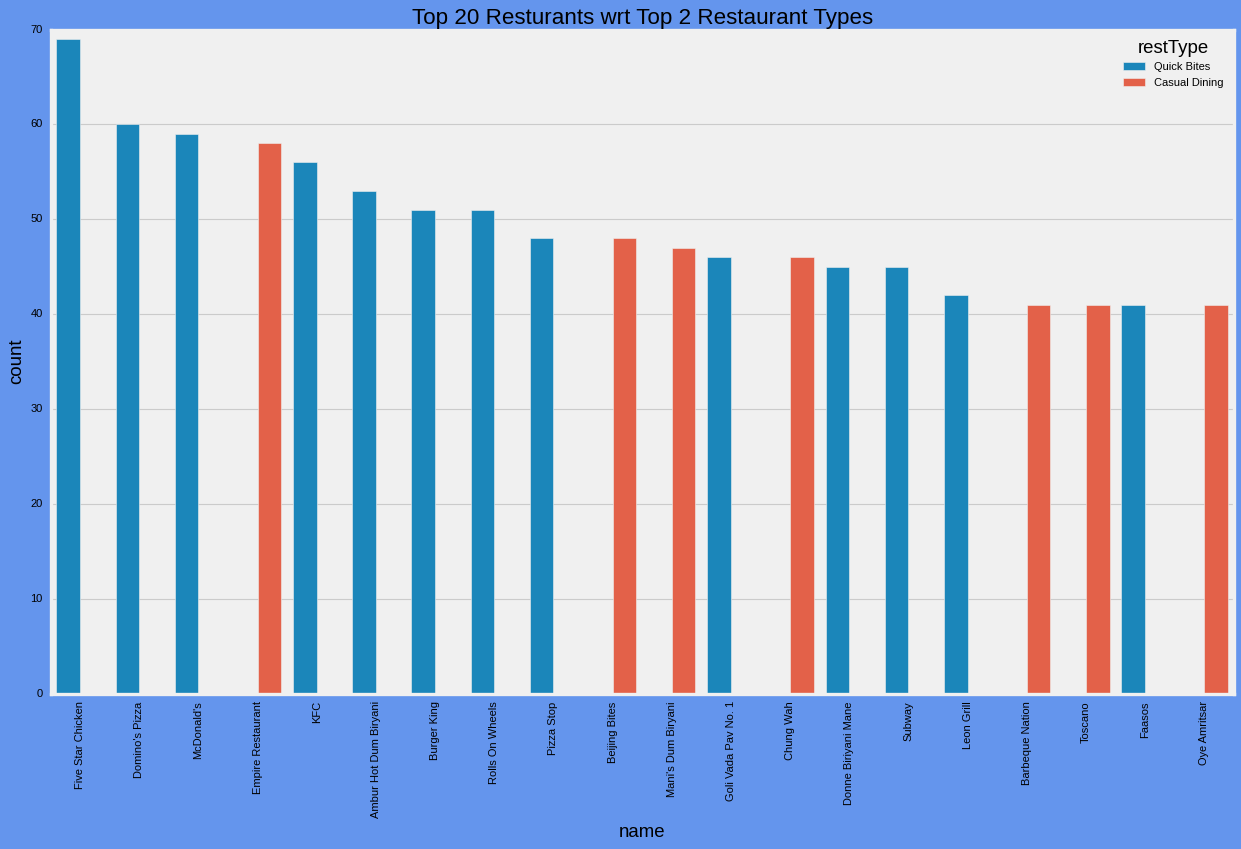

In [160]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('cornflowerblue')
plt.style.use('fivethirtyeight')

top2RestTypes = zomatoDataPandas_withoutOutliers[(zomatoDataPandas_withoutOutliers['restType'] == 'Quick Bites') | (zomatoDataPandas_withoutOutliers['restType'] == 'Casual Dining')]

top2RestTypes = top2RestTypes.groupby(['restType','name']).agg('count').sort_values(['address'],ascending=False)['address'][:20].reset_index()
top2RestTypes.columns=['restType','name','count']

sns.barplot(data=top2RestTypes,x='name',y='count',hue='restType');
plt.xticks(rotation=90);
plt.title("Top 20 Resturants wrt Top 2 Restaurant Types");

WE OBSERVE THE FOLLOWING:

--------
1. Five Star Chicken, Domino's Pizza,MaDonald's,Empire Restaurant and KFC are the top 5 restaurants which are best for Quick Bites and Casual Dining.

### Feature Creation

* Creating 4 bins for dividing Price.

In [161]:
# create cost_range column
bins = [0,200,500,800,1300]
labels = ['cheap','moderate','expensive','extra expensive']
zomatoDataPandas_withoutOutliers['costRange']= pd.cut(zomatoDataPandas_withoutOutliers['approxCost(2 people)'], bins=bins,labels=labels)

In [162]:
def costRange(cost):
  if cost <=200:
    return "cheap"
  elif cost >200 and cost <=500:
    return "moderate"
  elif cost >500 and cost <=800:
    return "expensive"
  else: 
    return "extra expensive"

In [163]:
from pyspark.sql.functions import udf

bucket_udf = udf(costRange, StringType())

zomatoDataPyspark = zomatoDataPyspark.withColumn('costRange',bucket_udf('approxCost(2 people)'))
zomatoDataPyspark_withoutOutliers = zomatoDataPyspark.withColumn('costRange',bucket_udf('approxCost(2 people)'))

In [164]:
#Creating a temporary table to write Sql Queries on it
zomatoDataPyspark_withoutOutliers.createOrReplaceTempView("zomatoData")

In [165]:
def doughnutchart(labels,values,title):
    colors=["#F7B7A3","#EA5F89"]
    data=go.Pie(labels=labels,values=values,hole=0.6,pull=0.04,marker=dict(colors=colors))
    layout=go.Layout(title=title)
    fig=go.Figure(data=data,layout=layout)
    iplot(fig)

### 46) Distribution of Cost Range of Dishes

In [166]:
spark.sql('select costRange,cnt,concat(round(cnt*100/(select count(costRange) from zomatoData),2),"%") \
as percent from (select costRange,count(costRange) as cnt from zomatoData group by costRange) order by cnt desc').show(10)

+---------------+-----+-------+
|      costRange|  cnt|percent|
+---------------+-----+-------+
|       moderate|25248| 48.87%|
|      expensive|10581| 20.48%|
|          cheap| 8000| 15.48%|
|extra expensive| 7838| 15.17%|
+---------------+-----+-------+



In [167]:
doughnutchart(zomatoDataPandas_withoutOutliers['costRange'].value_counts().index ,zomatoDataPandas_withoutOutliers['costRange'].value_counts().values,"Distribution of Cost of Dishes")

### 47) Top 20 Dish liked by bangaloreans

In [168]:
zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers['dishLiked']!= 'Unknown']['dishLiked'].value_counts().head(20)

Biryani                                                                               182
Chicken Biryani                                                                        73
Friendly Staff                                                                         69
Waffles                                                                                68
Paratha                                                                                57
Masala Dosa                                                                            56
Coffee                                                                                 42
Rooftop Ambience                                                                       42
Pizza                                                                                  38
Burgers                                                                                33
Cocktails                                                                              29
Prompt Ser

 #### * ***We can see there are issues with data in rows***

In [169]:
menuList = []
for i in zomatoDataPandas_withoutOutliers.dishLiked.tolist():
    if(len(i)>0):
        for e in i.split(','):
            menuList.append(e.strip())
            

#menuList = list(set(menuList))

In [170]:
allMenulist = spark.createDataFrame(menuList,StringType())
allMenulist = allMenulist.withColumnRenamed('value','Dish')
allMenulist = allMenulist.filter(allMenulist['Dish']!='Unknown')

allMenulist.registerTempTable('MenuData')

In [171]:
spark.sql("select Dish,total,concat(round(total / (select sum(total) from (select Dish,count(*) as total \
from MenuData group by Dish order by total desc limit 15)) * 100,1),'%') as distribution from \
(select Dish,count(*) as total from MenuData group by Dish) order by total desc limit 15 ").show()
#allMenulist.groupBy('Dish').count().orderBy('count',ascending=False).show(10)

+---------------+-----+------------+
|           Dish|total|distribution|
+---------------+-----+------------+
|          Pasta| 3406|       11.6%|
|        Burgers| 3022|       10.3%|
|      Cocktails| 2830|        9.6%|
|          Pizza| 2735|        9.3%|
|        Biryani| 2090|        7.1%|
|         Coffee| 1994|        6.8%|
|      Mocktails| 1887|        6.4%|
|     Sandwiches| 1676|        5.7%|
|        Paratha| 1565|        5.3%|
|        Noodles| 1414|        4.8%|
|         Salads| 1388|        4.7%|
|           Fish| 1365|        4.7%|
|         Nachos| 1364|        4.7%|
|Chicken Biryani| 1330|        4.5%|
|           Beer| 1267|        4.3%|
+---------------+-----+------------+



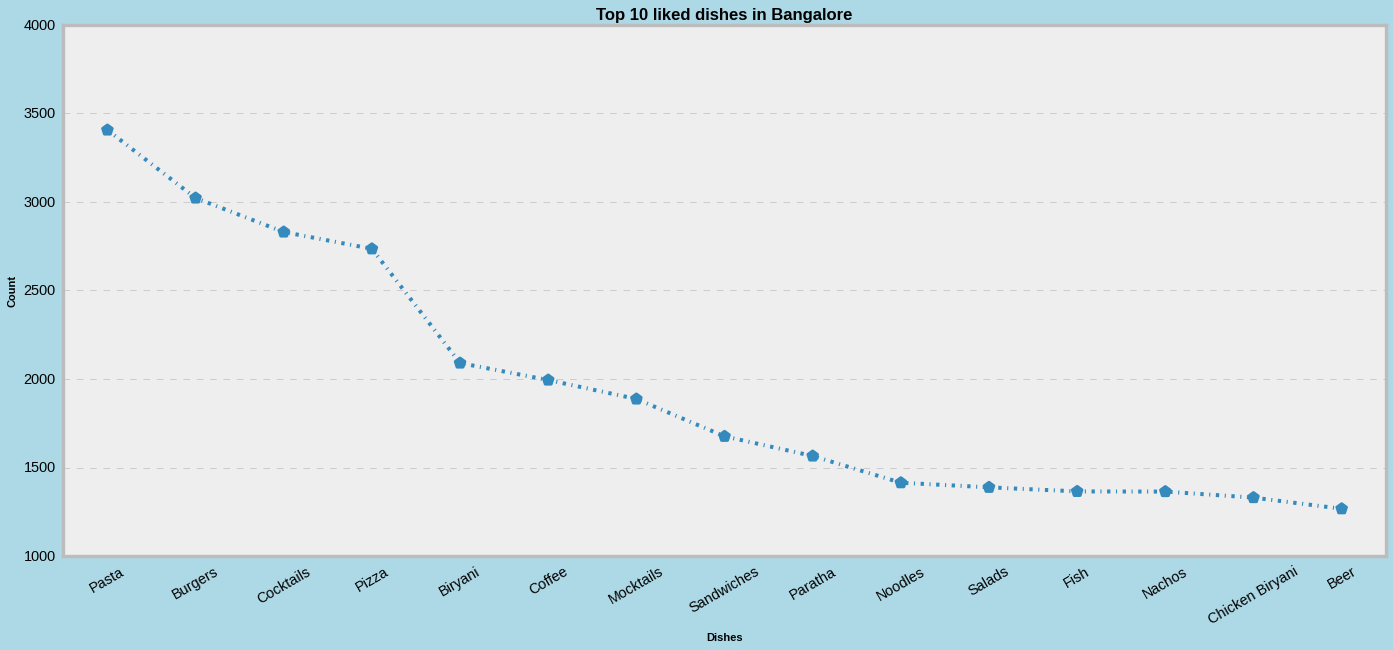

In [172]:
fig = plt.figure(figsize=(19,8))
fig.patch.set_facecolor('lightblue')
plt.style.use('bmh')

menuData = pd.DataFrame(menuList,columns=['Dish'])
menuData = menuData[menuData['Dish']!='Unknown']
menuData = menuData['Dish'].value_counts().reset_index().head(15)


sns.pointplot(data=menuData,x='index',y='Dish',linestyles='dashdot',alpha=0.8,markers='p')
plt.title('Top 10 liked dishes in Bangalore',fontweight='bold',fontsize=15)
plt.xlabel("Dishes",fontweight='bold',fontsize=10)
plt.ylabel("Count",fontweight='bold',fontsize=10);
plt.yticks(fontsize=13)
plt.xticks(fontsize=13,rotation=30);

WE OBSERVE THE FOLLOWING:

-----------
1. Five Star Chicken, Domino's Pizza,MaDonald's,Empire Restaurant and KFC are the top 5 restaurants which are best for Quick Bites and Casual Dining.

In [173]:
colors = ['grey' for i in range(zomatoDataPandas_withoutOutliers.location.nunique())]
colors[0] = 'orange'

### 48) Rate Distribution and Rate Label Distribution

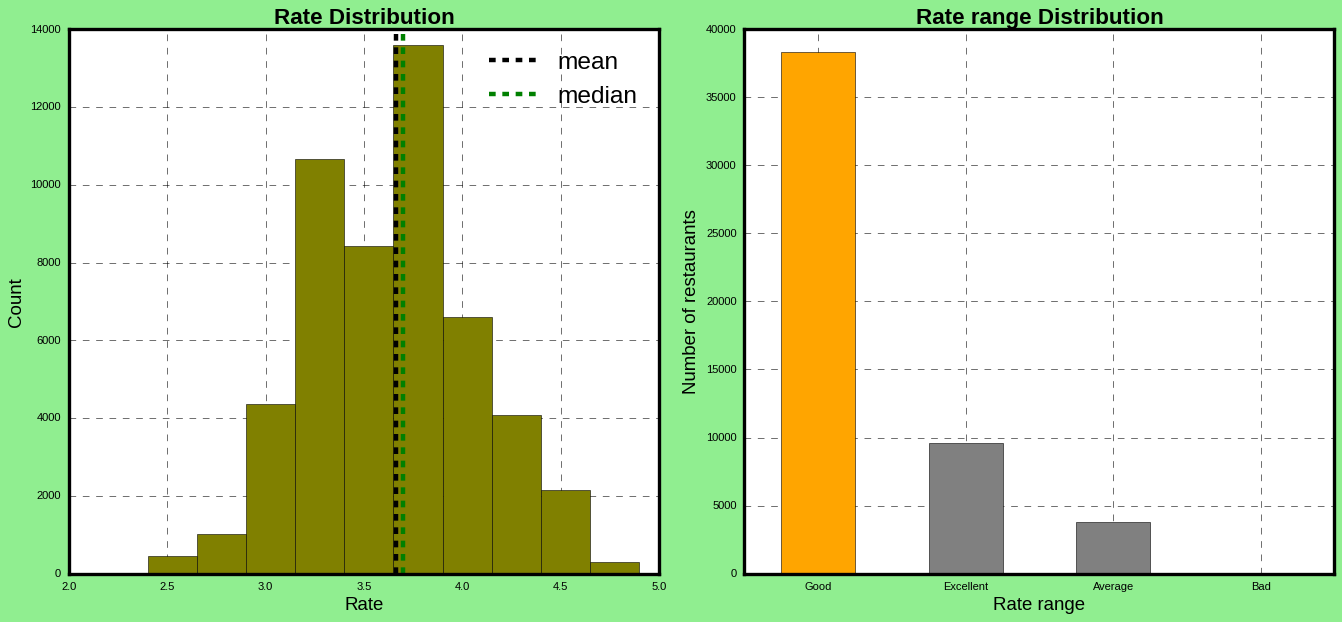

In [174]:
fig = plt.figure(figsize=(17,8))
fig.patch.set_facecolor('lightgreen')
plt.style.use('grayscale')

plt.rcParams['figure.figsize'] = 17,8
plt.subplot(1,2,1)
zomatoDataPandas_withoutOutliers.ratingsBy5.hist(color='olive')
plt.axvline(x= zomatoDataPandas_withoutOutliers.ratingsBy5.mean(),ls='--',color='black',linewidth=4,label="mean")
plt.axvline(x= zomatoDataPandas_withoutOutliers.ratingsBy5.median(),ls='--',color='green',linewidth=4,label="median")
plt.title('Rate Distribution',weight='bold')
plt.legend(["mean", "median"],prop={"size":22})
plt.xlabel('Rate')
plt.ylabel('Count')

plt.subplot(1,2,2)
zomatoDataPandas_withoutOutliers.RateLabel.value_counts().plot(kind='bar',color=colors,grid=True)
plt.title('Rate range Distribution',weight='bold')
plt.xlabel('Rate range')
plt.ylabel('Number of restaurants')
plt.xticks(rotation=0)
plt.tight_layout();

WE OBSERVE THE FOLLOWING:

-------
1. We can observe most of the ratings are between 3.3 and 3.9 which match with rate label 'good'

In [175]:
from pyspark.sql.functions import udf

bucket_udf = udf(label, StringType())

zomatoDataPyspark_withoutOutliers = zomatoDataPyspark_withoutOutliers.withColumn('RateLabel',bucket_udf('ratingsBy5'))

### 49) Location wise Rating of Dishes

In [176]:
zomatoDataPyspark_withoutOutliers.crosstab('location','Ratelabel').orderBy(['Excellent','Good'],ascending=[False,False]).show()

+--------------------+-------+---+---------+----+
|  location_Ratelabel|Average|Bad|Excellent|Good|
+--------------------+-------+---+---------+----+
|Koramangala 5th B...|     51|  0|     1200|1252|
|         Indiranagar|    154|  0|      664|1263|
|           Jayanagar|     87|  0|      423|1416|
|Koramangala 4th B...|     50|  0|      366| 601|
|        Lavelle Road|      1|  0|      366| 160|
|             MG Road|     71|  0|      356| 491|
|Koramangala 7th B...|     49|  0|      345| 787|
|            JP Nagar|    154|  0|      336|1744|
|                 BTM|    318|  0|      315|4481|
|                 HSR|    129|  0|      297|2096|
|Koramangala 6th B...|     74|  0|      295| 785|
|       Church Street|     24|  5|      292| 247|
|          Whitefield|    186|  0|      263|1693|
|              Ulsoor|     50|  0|      245| 724|
|      Residency Road|     39|  0|      240| 395|
|        Brigade Road|    101|  9|      228| 877|
|       Sarjapur Road|     66|  0|      203| 796|


<Figure size 1360x800 with 0 Axes>

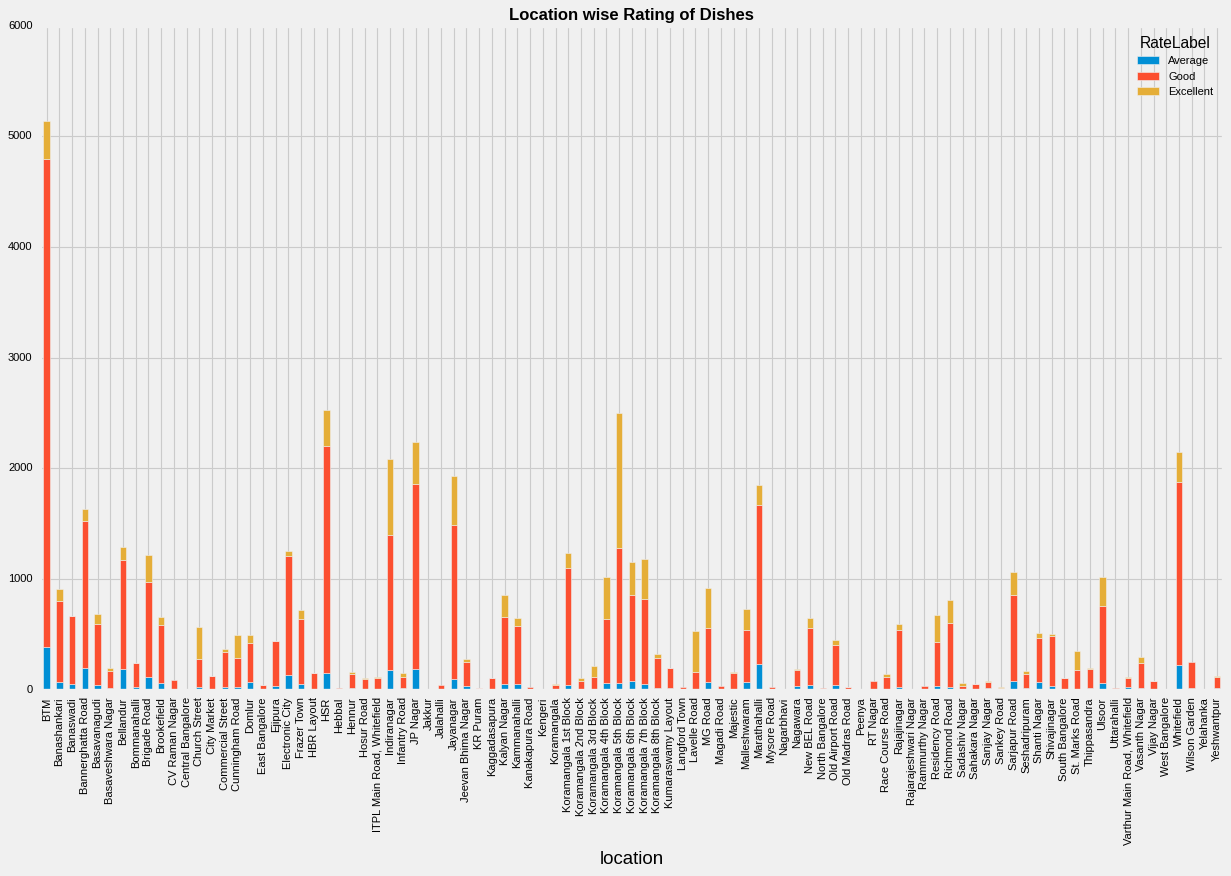

In [177]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('lightblue')
plt.style.use('fivethirtyeight')

pd.crosstab(zomatoDataPandas_withoutOutliers['location'],zomatoDataPandas_withoutOutliers['RateLabel']).plot(kind='bar',stacked=True,figsize= (17,10))
plt.title("Location wise Rating of Dishes",fontweight='bold',fontsize=15);

WE OBSERVE THE FOLLOWING:

------------
1. We can observe almost all the location have more than 70% ratings as good, with BTM the most popular as it has most ratings.
2. We can see Koramangala  5th Block has almost 50%-50% rate labels of Excellent and Good, that shows , this location has most most of the good restaurants and serve the best dishes.

In [178]:
top6RestType = zomatoDataPandas_withoutOutliers.restType.value_counts().index[:6].tolist()

### 50) Comparing Ratings Vs Top 12 RestType

<Figure size 1520x640 with 0 Axes>

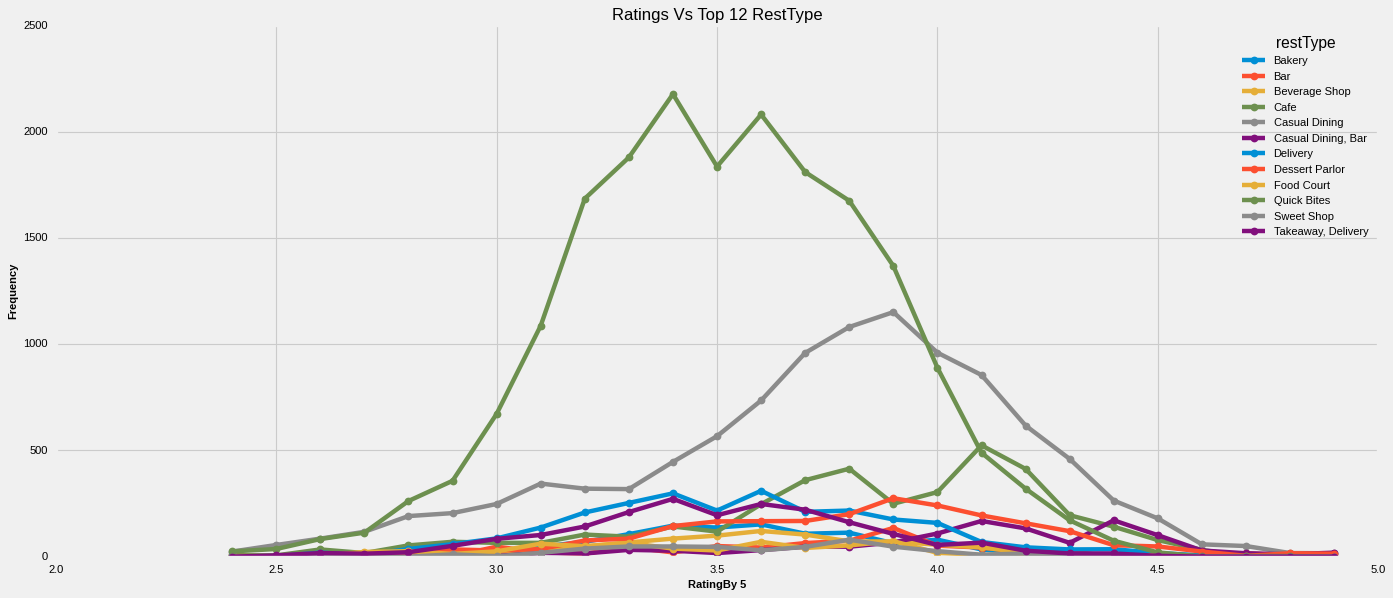

In [179]:
fig = plt.figure(figsize=(19,8))
fig.patch.set_facecolor('mediumpurple')
plt.style.use('fivethirtyeight')
top12RestType = zomatoDataPandas_withoutOutliers.restType.value_counts().index[:12].tolist()

top12RestTypeData = zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers.restType.isin(top12RestType)]

pd.crosstab(top12RestTypeData.ratingsBy5,top12RestTypeData.restType).plot(kind='line',marker='o',figsize=(19,8));
plt.title("Ratings Vs Top 12 RestType",fontsize='15',fontweight=15);
plt.xlabel("RatingBy 5",fontsize='10',fontweight='bold')
plt.ylabel("Frequency",fontsize='10',fontweight='bold');

WE OBSERVE THE FOLLOWING:

-----------------
1. We can notice Quick Bites got majority of ratings between 3.3 - 3.7 .

2. Casual Dinings got the 2nd hightest ratings but after 3.5 the ratings get better and gets better ratings than Quick Bites from 4.0 and above. Thus its average rating is more than Quick Bites.

3. The other Resttypes gets almost same ratinga but Cafe which gets 3rd highest ratings increase and gets better than Quick Bites after 4.2.

### 51) Comparing Ratings Vs Online Orders

<Figure size 1520x640 with 0 Axes>

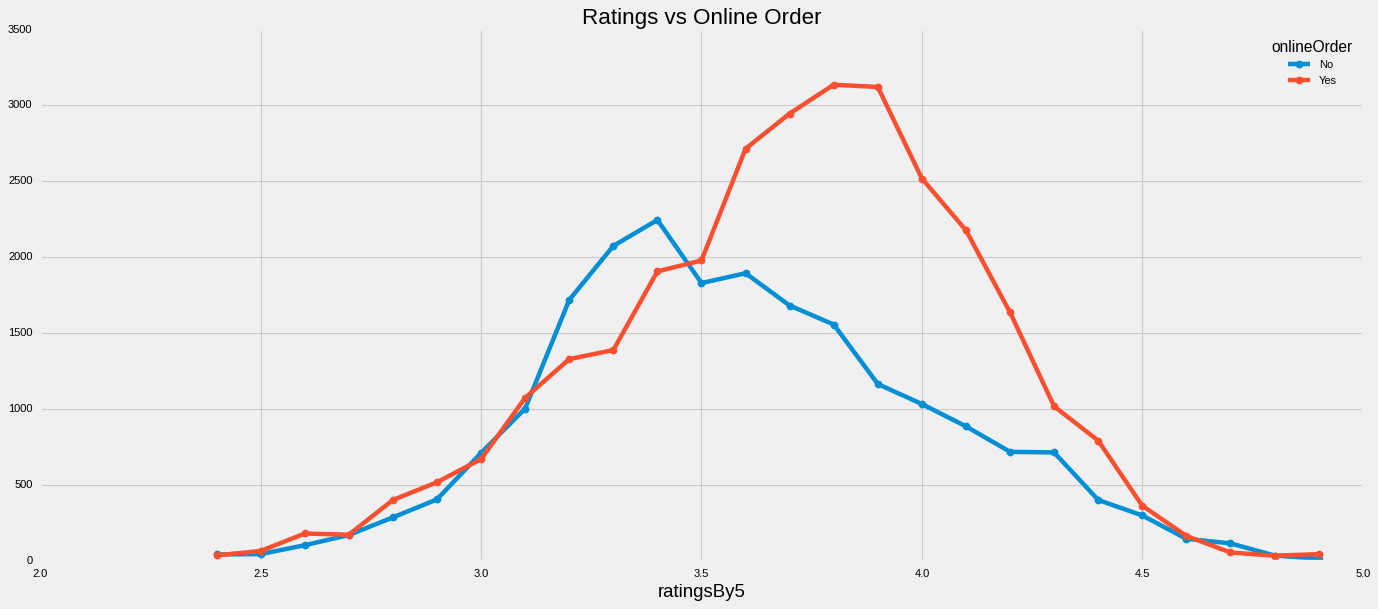

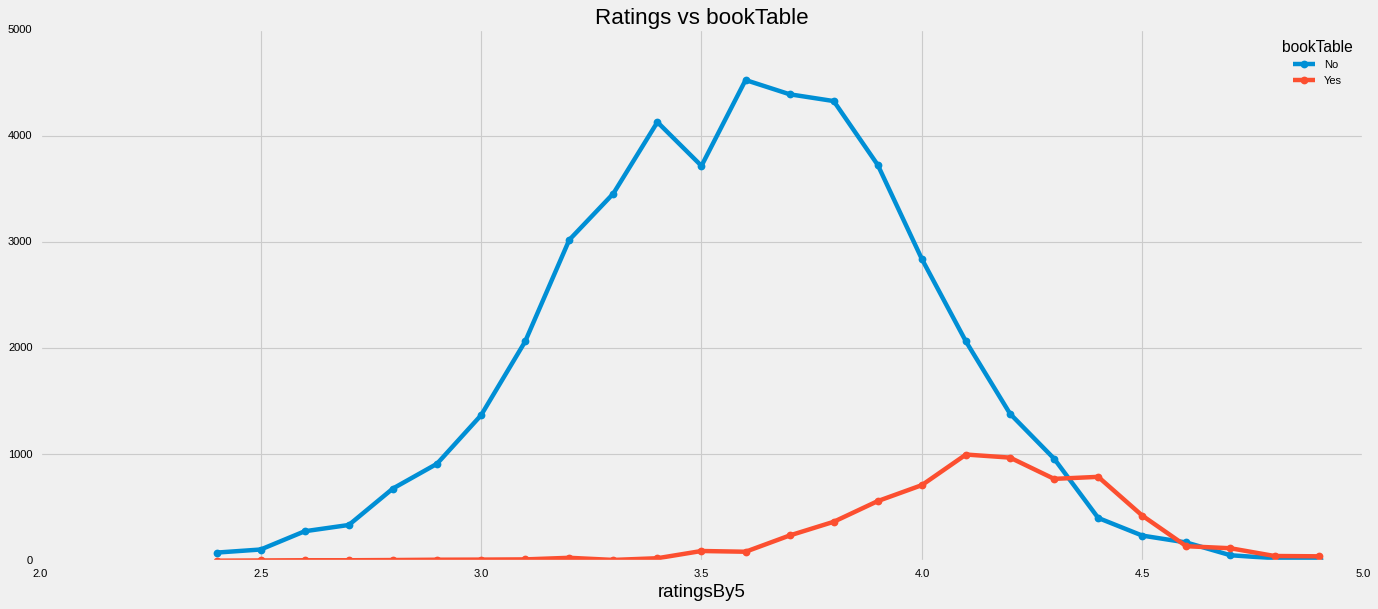

In [180]:
plt.figure(figsize=(19,8))
fig.patch.set_facecolor('yellow')
plt.style.use('fivethirtyeight')

pd.crosstab(zomatoDataPandas_withoutOutliers.ratingsBy5,zomatoDataPandas_withoutOutliers.onlineOrder).plot(kind='line',marker='o',figsize=(19,8))
plt.title("Ratings vs Online Order")
pd.crosstab(zomatoDataPandas_withoutOutliers.ratingsBy5,zomatoDataPandas_withoutOutliers.bookTable).plot(kind='line',marker='o',figsize=(19,8));
plt.title("Ratings vs bookTable");

WE OBSERVE THE FOLLOWING:

----------------
1. More clear here that if your restaturat has not the book table service you still have the opportinity to have a similar rate as other restaurant provide this service. Most of the restaurant has not this service

2. while at rate around 4.2 and above we notice higher number of restaurants at this rate and provide book_table service

3. Restaurants which provide online order facility seem to have better rating than the restaurants which don't

In [181]:
def barchart(index,values,name):
    data=go.Bar(x=index,y=values,orientation='v',text=values,textposition='auto',name=name,marker=dict(color='#2576ba'))
    layout=go.Layout(title=name,xaxis=dict(tickangle=-25),barmode='group')
    fig=go.Figure(data=data,layout=layout)
    iplot(fig)

### 51)Top 10 Voted neighbourhoods

In [182]:
topLocationByVotes = zomatoDataPandas_withoutOutliers.groupby('location')['votes'].sum().sort_values(ascending=False)[:10]

barchart(topLocationByVotes.index,topLocationByVotes.values,"Top 10 Voted neighbourhoods")
plt.show()

WE OBSERVE THE FOLLOWING:

----------
If initial investment is not much of a concern for you and you are looking to increase your chances to maximum, then why don't go with one of the best locations loved by zomato customers.

From the barchart, we can clearly see Koramangala dominates this scenario. Koramangala is the heart of Bangalore and attracts nearly all foodies. It might take heavy initial investment based upon it's popularity but it seems like a sure shot if you deliver well.

## What are the best restaurants in Bangalore ?
### To answer this question let's first define the best restaurant: This will be as:

1. #### has the highest possible rate , above average plus,
2. #### has the highest number of votes as it will more reliable plus
3. #### has the lowest possible cost

In [183]:
avgRating = zomatoDataPandas_withoutOutliers.ratingsBy5.mean()
avgVotes = zomatoDataPandas_withoutOutliers.votes.mean()

bestRestBanglore = zomatoDataPandas_withoutOutliers[(zomatoDataPandas_withoutOutliers.ratingsBy5 >=avgRating) & (zomatoDataPandas_withoutOutliers.votes >=avgVotes)]
bestRestBanglore = bestRestBanglore.sort_values(['ratingsBy5','votes','approxCost(2 people)'],ascending=[False,False,True]).reset_index().drop('index',axis=1)

bestRestBanglore[['name','ratingsBy5','votes','cuisines','approxCost(2 people)','location']][:60]

name  ratingsBy5  votes  \
0                                        Punjab Grill         4.9  518.0   
1                        Levitate Brewery and Kitchen         4.9  475.0   
2   SantÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃ...         4.9  246.0   
3                              Belgian Waffle Factory         4.9  201.0   
4                                        Punjab Grill         4.8  654.0   
5                                        Punjab Grill         4.8  650.0   
6                                          Biergarten         4.8  524.0   
7                                          Biergarten         4.8  516.0   
8                                          Biergarten         4.8  516.0   
9                                          Biergarten         4.8  498.0   
10                                         Biergarten         4.8  498.0   
11                                         Biergarten         4.8  482.0   
12                                         Biergarten         4.8  482.0   
13                                         Biergarten         4.8  467.0   
14                                         Biergarten         4.8  467.0   
15                                         Biergarten         4.8  460.0   
16                             Belgian Waffle Factory         4.8  392.0   
17                             Belgian Waffle Factory         4.8  391.0   
18                             Belgian Waffle Factory         4.8  265.0   
19                             Belgian Waffle Factory         4.8  265.0   
20                             Belgian Waffle Factory         4.8  265.0   
21                             Belgian Waffle Factory         4.8  265.0   
22                             Belgian Waffle Factory         4.8  193.0   
23                             Belgian Waffle Factory         4.8  189.0   
24                             Belgian Waffle Factory         4.8  189.0   
25                             Belgian Waffle Factory         4.8  189.0   
26                             Belgian Waffle Factory         4.8  189.0   
27                             Belgian Waffle Factory         4.8  189.0   
28                             Belgian Waffle Factory         4.8  187.0   
29                             Belgian Waffle Factory         4.8  187.0   
30                             Belgian Waffle Factory         4.8  186.0   
31                             Belgian Waffle Factory         4.8  186.0   
32                                       Taaza Thindi         4.7  651.0   
33                                   The Big Barbeque         4.7  544.0   
34                                   The Big Barbeque         4.7  524.0   
35                                             Maziga         4.7  292.0   
36                                             Maziga         4.7  292.0   
37                                            You Mee         4.7  277.0   
38                                            You Mee         4.7  277.0   
39                                       Kurtoskalacs         4.7  262.0   
40                                            You Mee         4.7  231.0   
41                                  Opus Food Stories         4.7  163.0   
42                                  Opus Food Stories         4.7  163.0   
43                                  Opus Food Stories         4.7  163.0   
44                                        Vanilla Sky         4.6  766.0   
45                                         Baar Union         4.6  653.0   
46                                         Baar Union         4.6  650.0   
47                                         Baar Union         4.6  634.0   
48                                         Baar Union         4.6  634.0   
49                                         Baar Union         4.6  634.0   
50                                           Galito's         4.6  595.0   
51                                           Galito's         4.6  595.0   
52                   

1. For Continental, North Indian, Chinese, European restaurants located in Koramangala 5th Block,Electronic City,Whitefield are the best like Biergarten,The Big Barbeque,You Mee restaurant.

2. For North Indian Food restaurants located in Whitefield are the best like Punjab Grill restaurant.

3. For South Indian Food restaurants located in Banashankari,Jayanagar are the best like Taaza Thindi,Puliyogare Point,Brahmin Tiffins & Coffee,Taaza Thindi,Sri Laxmi Venkateshwara Coffee Bar restaurant.

4. For Dessert restaurants located in Koramangala 5th Block,Vasanth Nagar,Kalyan Nagar are the best like Belgian Waffle Factory and Kurtoskalacs restaurant.

### 53) Where one can find the best restaurants in Bangalore?

In [184]:
bestLocation = bestRestBanglore['location'].value_counts()[:10]
name = "Where one can find the best restaurants in Bangalore?"
barchart(bestLocation.index,bestLocation.values,name)
plt.show()

### 54) Distribution of Top 10 Cuisines

In [185]:
cuisinesList = []
for i in zomatoDataPandas_withoutOutliers.cuisines.tolist():
    if(len(i)>0):
        for e in i.split(','):
            cuisinesList.append(e.strip())
            

allCuisines = pd.DataFrame(cuisinesList,columns=['CuisinesList'])

In [186]:
cuisineData = spark.createDataFrame(cuisinesList,StringType())
cuisineData = cuisineData.withColumnRenamed('value','cuisines')
cuisineData.registerTempTable('cuisineData')

In [187]:
spark.sql("select cuisines,total,concat(round(total*100/(select sum(ct) from (select cuisines,count(*) as ct \
from cuisineData group by cuisines order by ct desc limit 10)),1),'%') as distribution from \
(select cuisines,count(*) as total from cuisineData group by cuisines) order by total desc limit 10").show()

+------------+-----+------------+
|    cuisines|total|distribution|
+------------+-----+------------+
|North Indian|21116|       24.9%|
|     Chinese|15535|       18.3%|
|South Indian| 8640|       10.2%|
|   Fast Food| 8091|        9.6%|
|     Biryani| 6487|        7.7%|
| Continental| 5762|        6.8%|
|    Desserts| 5630|        6.6%|
|        Cafe| 5302|        6.3%|
|   Beverages| 4743|        5.6%|
|     Italian| 3387|        4.0%|
+------------+-----+------------+



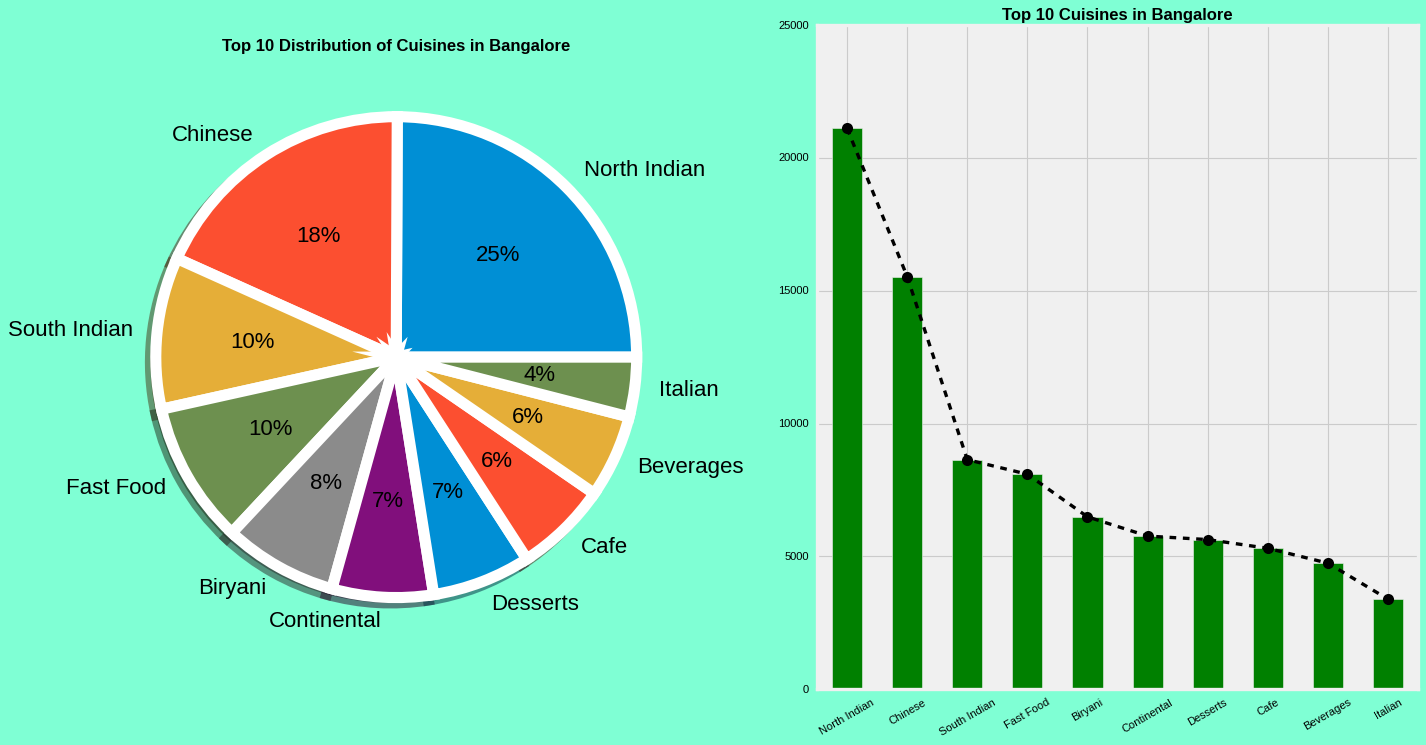

In [188]:
fig = plt.figure(figsize=(19,10))
fig.patch.set_facecolor('aquamarine')
plt.style.use('fivethirtyeight')

plt.subplot(121)
allCuisines['CuisinesList'].value_counts().head(10).plot.pie(autopct='%1.f%%',
                                                             wedgeprops={'linewidth':10,'edgecolor':'white'},
                                                             shadow=True,
                                                             fontsize=20)
plt.title("Top 10 Distribution of Cuisines in Bangalore",fontsize=15,fontweight='bold')
plt.ylabel('')

plt.subplot(122)
allCuisines['CuisinesList'].value_counts().head(10).plot(color='black',marker='o',markersize='10',linestyle='dashed',linewidth=3)
allCuisines['CuisinesList'].value_counts().head(10).plot(kind='bar',color='green');
plt.title("Top 10 Cuisines in Bangalore",fontsize=15,fontweight='bold');
plt.xticks(rotation=30);

WE OBSERVE THE FOLLOWING:

-----------------------
1. We can see North-India is most loved Cuisine in Bangalore followed by Chineas,South Indian,Fast Food and Biryani.

### 55) Top 10 Cuisines across best Resaurant in Bangalore

In [189]:
cuisinesListbestRest = []
for i in bestRestBanglore.cuisines.tolist():
    if(len(i)>0):
        for e in i.split(','):
            cuisinesListbestRest.append(e.strip())
            

bestCuisinesbestRest = pd.DataFrame(cuisinesListbestRest,columns=['CuisinesList'])

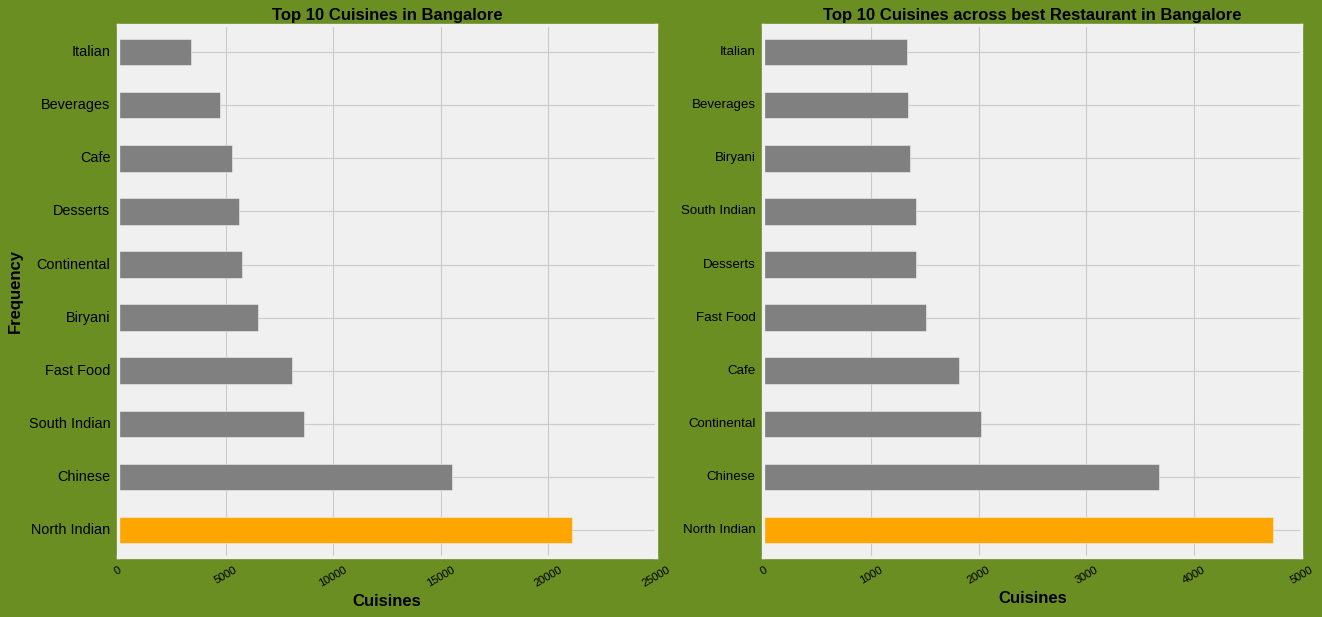

In [190]:
#What cuisine?
fig = plt.figure(figsize=(17,8))
fig.patch.set_facecolor('olivedrab')
plt.style.use('fivethirtyeight')

plt.subplot(121)
allCuisines['CuisinesList'].value_counts().head(10).plot(kind='barh',color =colors);
plt.title("Top 10 Cuisines in Bangalore",fontsize=15,fontweight='bold');
plt.ylabel("Frequency",fontsize=15,fontweight='bold');
plt.xlabel("Cuisines",fontsize=15,fontweight='bold');
plt.xticks(rotation=30);
plt.yticks(fontsize=13);

plt.subplot(122)
bestCuisinesbestRest.CuisinesList.value_counts()[:10].sort_values(ascending=False).plot(kind='barh',color =colors,figsize=(17,8));
plt.title("Top 10 Cuisines across best Restaurant in Bangalore",fontsize=15,fontweight='bold')
plt.xlabel("Cuisines",fontsize=15,fontweight='bold');
plt.xticks(rotation=30);
plt.yticks(fontsize=12);

WE OBSERVE THE FOLLOWING:

--------
1. After comparing top Cuisines in bangalore and top Cuisines in best Restaurants we can observe North Indian is still the most popular Cuisines followed by Chinease , Continental ,Cafe and Fast Food.

### 56) How much is the Average Price of 2 people for ordering the dish from the most reliable data

In [191]:
bestRestBanglore['approxCost(2 people)'].mean()

530.9989580619953

WE OBSERVE THE FOLLOWING:

-----
1. The average price for most appreciated restaurants is around 600 for two persons

### 57)What is the relation between meal_type and location?

<Figure size 1520x960 with 0 Axes>

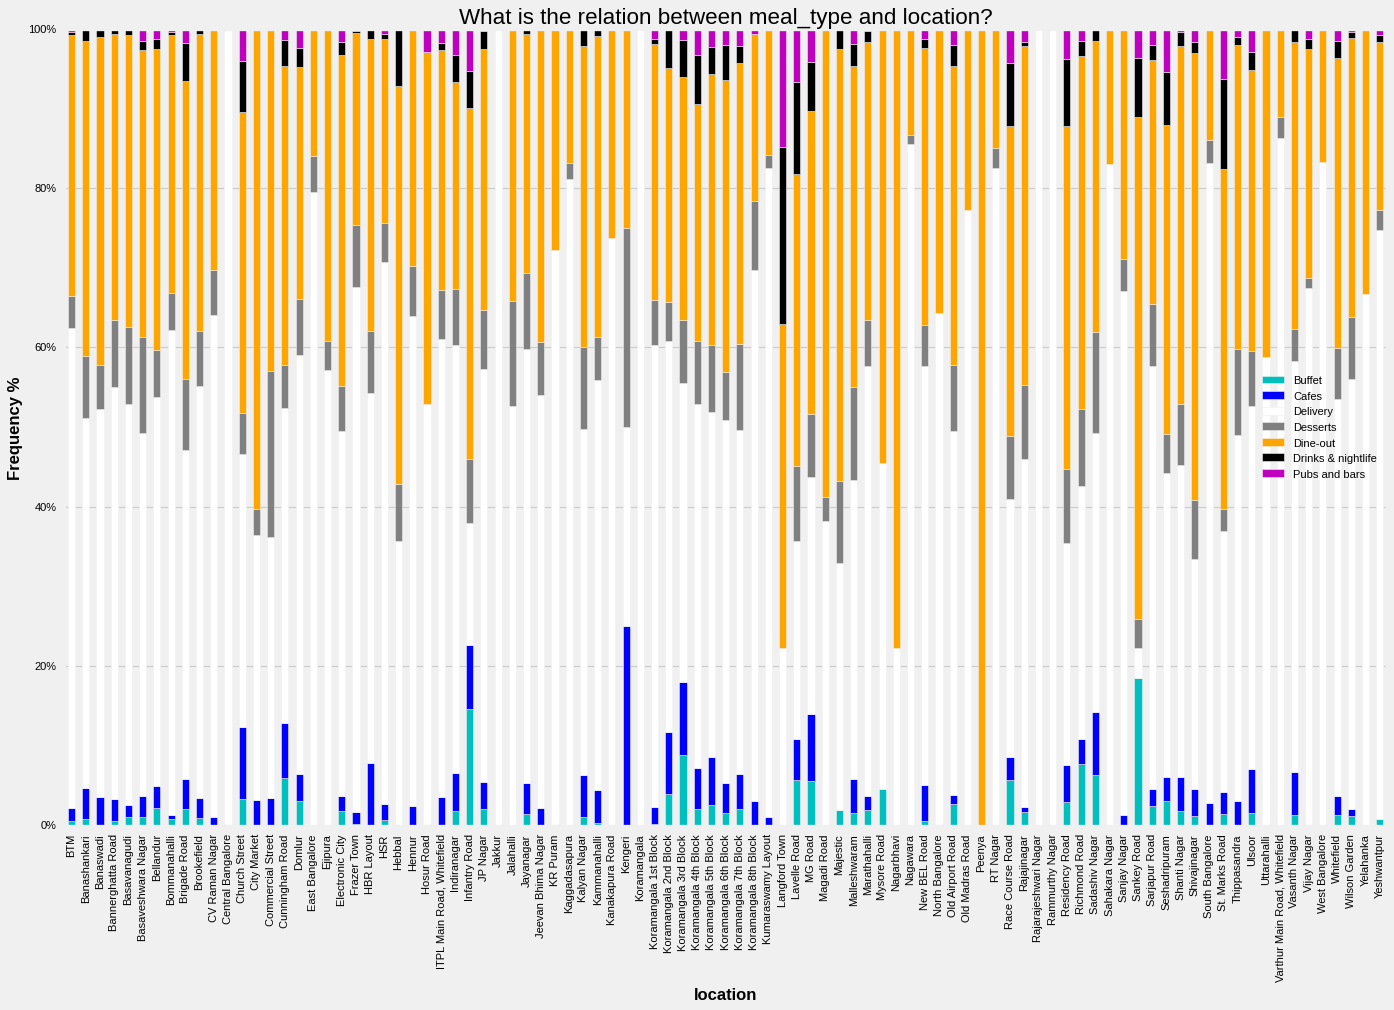

In [192]:
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(19,12))
fig.patch.set_facecolor('tomato')
plt.style.use('fivethirtyeight')

zomatoDataPandas_withoutOutliers.groupby(['location','listedInType']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).\
unstack().plot(kind='bar',stacked=True,color=['c','b','w','grey','orange','black','m'],figsize=(19,12));
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter());
plt.legend(loc='best');

plt.title("What is the relation between meal_type and location?");
plt.xlabel("location",fontsize=15,fontweight='bold');
plt.ylabel("Frequency %",fontsize=15,fontweight='bold');

WE OBSERVE THE FOLLOWING:

--------------
Again here if you go through each color you will get the hint that Each location has dominat types of mealEach meal has tendency to be more in certain locations like:
1. Kengri has high percentage of its restaurant as Cafe type
2. Rajarajeshwari Nagar has nothing but Delivery ! same in Central Bangalore
3. Pennya : 100% as Dineout
3. Langford Town : you will find the highest mix of drinks& nightlife and pubs beside dineout
5. Commercial street: around 20% of its restaiurants in the dessert type

### 58) What is the relation between meal type and the rating?

<Figure size 1360x640 with 0 Axes>

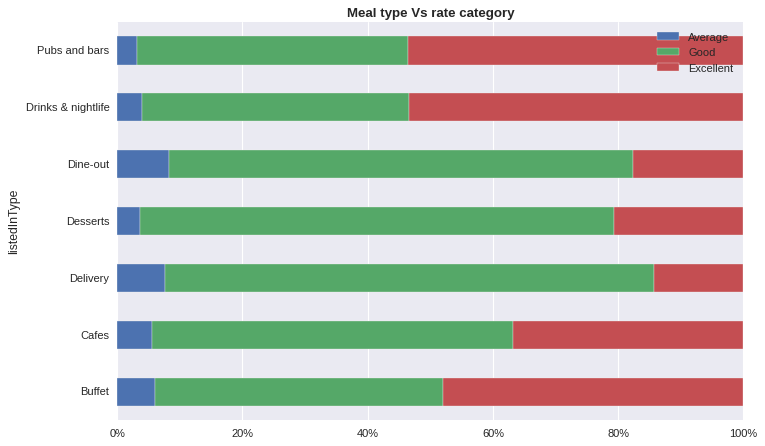

In [193]:
fig = plt.figure(figsize=(17,8))
fig.patch.set_facecolor('purple')
plt.style.use('seaborn')
mealToRate = pd.crosstab(zomatoDataPandas_withoutOutliers.listedInType, zomatoDataPandas_withoutOutliers.RateLabel)
# the cheap area will be colored as white for ease of visibility
plt.rcParams['figure.figsize'] = 9,6
mealToRate.div(mealToRate.sum(1).astype(float), axis = 0).apply(lambda x: x*100).plot(kind = 'barh', stacked = True)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter());
plt.legend(loc='best')
plt.title('Meal type Vs rate category',weight='bold');

WE OBSERVE THE FOLLOWING:

-----
1. The pubs and Bars & the Drinks and nightlife gets more of Excellent Rating may be as they are not much located and their quality is also very good.
2. Buffets get almost 50-50% of Good and Excellent Ratings that shows buffet dishes quality are very good.

### 59)Expensive,Famous and High Class Resturants in Bangalore

In [194]:
expensiveRest = zomatoDataPandas[['name','approxCost(2 people)','listedInType','location','cuisines','bookTable','onlineOrder']].groupby(['approxCost(2 people)'],sort = True)
expensiveRest = expensiveRest.filter(lambda x:x.mean()>1000)

highRatedRest = zomatoDataPandas[['name','ratingsBy5']].groupby(['ratingsBy5'],sort=True)
highRatedRest = highRatedRest.filter(lambda x:x.mean()>=4.5)

TopExpensivePopularRest = pd.merge(expensiveRest,highRatedRest,how='inner',on=['name']).sort_values(['approxCost(2 people)','ratingsBy5'],ascending=[False,False]).drop_duplicates().reset_index()\
.drop('index',axis=1)

TopExpensivePopularRest.head(15)

name  approxCost(2 people)  \
0       Alba - JW Marriott Bengaluru                4000.0   
1      Karavalli - The Gateway Hotel                3500.0   
2              Rim Naam - The Oberoi                3000.0   
3              Rim Naam - The Oberoi                3000.0   
4                           Yauatcha                2800.0   
5             Melange - Radisson Blu                2700.0   
6             Melange - Radisson Blu                2700.0   
7               Windmills Craftworks                2500.0   
8               Windmills Craftworks                2500.0   
9               Windmills Craftworks                2500.0   
10                    Hard Rock Cafe                2500.0   
11                    Hard Rock Cafe                2500.0   
12                    Hard Rock Cafe                2500.0   
13  Sly Granny - The Community House                2500.0   
14  Sly Granny - The Community House                2500.0   

          listedInType        location  \
0             Dine-out    Lavelle Road   
1             Dine-out  Residency Road   
2               Buffet         MG Road   
3             Dine-out         MG Road   
4             Dine-out         MG Road   
5               Buffet    Marathahalli   
6             Dine-out    Marathahalli   
7             Dine-out      Whitefield   
8   Drinks & nightlife      Whitefield   
9        Pubs and bars      Whitefield   
10            Dine-out  St. Marks Road   
11  Drinks & nightlife  St. Marks Road   
12       Pubs and bars  St. Marks Road   
13            Dine-out     Indiranagar   
14       Pubs and bars     Indiranagar   

                                            cuisines bookTable onlineOrder  \
0                                            Italian       Yes          No   
1               Mangalorean, Konkan, Seafood, Kerala       Yes          No   
2                                               Thai        No          No   
3                                               Thai        No          No   
4                     Chinese, Asian, Cantonese, Tea       Yes          No   
5   North Indian, Continental, Chinese, South Indian       Yes          No   
6   North Indian, Continental, Chinese, South Indian       Yes          No   
7                      American, North Indian, Salad        No          No   
8                      American, North Indian, Salad        No          No   
9                      American, North Indian, Salad        No          No   
10                                     American, BBQ       Yes          No   
11                                     American, BBQ       Yes          No   
12                                     American, BBQ       Yes          No   
13                 Modern Indian, European, American       Yes          No   
14                 Modern Indian, European, American       Yes          No   

    ratingsBy5  
0          4.5  
1          4.5  
2          4.6  
3          4.6  
4          4.6  
5          4.5  
6          4.5  
7          4.6  
8          4.6  
9          4.6  
10         4.5  
11         4.5  
12         4.5  
13         4.5  
14         4.5

WE OBSERVE THE FOLLOWING:

-------

1. JW Marriott, The Gateway Hote,The Oberoi,Yauatcha and Melange - Radisson Blu are the most Costly and Famous High Class Restaurants in Bangalore.
2. All these high class restaurants don't provide Online Orders and most of them provide table booking option.
3. Italian,Mangalorean,Thai,Chinese,North Indian, Continental and American, BBQ are most famours Cuisines , that means mostly people order non-indian dishes there.
4. Dine-out,Drinks and Nighlife,Pubs and bars are the most costly listedinType
5. Lavelle Road,Residency Road,MG Road,Marathahalli,Whitefield,St.Marks Road and Indiranagar are the locations where these restaurants are located.

### 60)Top rated , Top voted Resturants in Bangalore

In [195]:
max_rate = zomatoDataPandas_withoutOutliers.ratingsBy5.max()
max_vote = zomatoDataPandas_withoutOutliers.votes.max()

mostFamous_Rated_RestBanglore = zomatoDataPandas_withoutOutliers[(zomatoDataPandas_withoutOutliers.ratingsBy5 == max_rate) | (zomatoDataPandas_withoutOutliers.votes == max_vote)][['name','votes','ratingsBy5','approxCost(2 people)','listedInType','location']]
mostFamous_Rated_RestBanglore = mostFamous_Rated_RestBanglore.sort_values(by=['ratingsBy5','votes','approxCost(2 people)'],ascending=[False,False,False])
mostFamous_Rated_RestBanglore[:15]

name  votes  ratingsBy5  \
7118                                        Punjab Grill  518.0         4.9   
21280                       Levitate Brewery and Kitchen  475.0         4.9   
45812  SantÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃ...  246.0         4.9   
10284                             Belgian Waffle Factory  201.0         4.9   
3921                         Byg Brewski Brewing Company   41.0         4.9   
4801                         Byg Brewski Brewing Company   41.0         4.9   
4944                         Byg Brewski Brewing Company   41.0         4.9   
5153                              Belgian Waffle Factory   41.0         4.9   
5809                              Belgian Waffle Factory   41.0         4.9   
6746                                            Flechazo   41.0         4.9   
7888                                            Flechazo   41.0         4.9   
8260                           AB's - Absolute Barbecues   41.0         4.9   
8275                      Asia Kitchen By Mainland China   41.0         4.9   
9099                      Asia Kitchen By Mainland China   41.0         4.9   
10389                          AB's - Absolute Barbecues   41.0         4.9   

       approxCost(2 people)        listedInType               location  
7118                  400.0            Delivery             Whitefield  
21280                 400.0            Dine-out               JP Nagar  
45812                1000.0            Dine-out            Indiranagar  
10284                 400.0            Desserts  Koramangala 5th Block  
3921                  400.0            Delivery          Sarjapur Road  
4801                  400.0            Dine-out          Sarjapur Road  
4944                  400.0  Drinks & nightlife          Sarjapur Road  
5153                  400.0            Delivery           Brigade Road  
5809                  400.0            Desserts           Brigade Road  
6746                  400.0              Buffet             Whitefield  
7888                  400.0            Dine-out             Whitefield  
8260                  400.0              Buffet                    BTM  
8275                  400.0              Buffet  Koramangala 5th Block  
9099                  400.0            Delivery  Koramangala 5th Block  
10389                 400.0            Dine-out                    BTM

WE OBSERVE THE FOLLOWING:

-------
1.  We see Punjab Grill,Levitate Brewery and Kitchen,Belgian Waffle Factor,Byg Brewski Brewing Company are the restaurants which top rated and voted wit reasonable cost for dishes.

#### Data Cleaning on ReviewText column for better understanding.

In [196]:
# reviewText 
zomatoDataPandas_withoutOutliers['reviewText'] = zomatoDataPandas_withoutOutliers.reviewsList.apply(lambda x:x[26:]).replace("RATED\n  ",''). \
replace('?','').replace('�','').replace('\n','').replace('.',' ').apply(lambda x:x.strip().lower())

### 61) WordCloud for Top Reviews by Customers

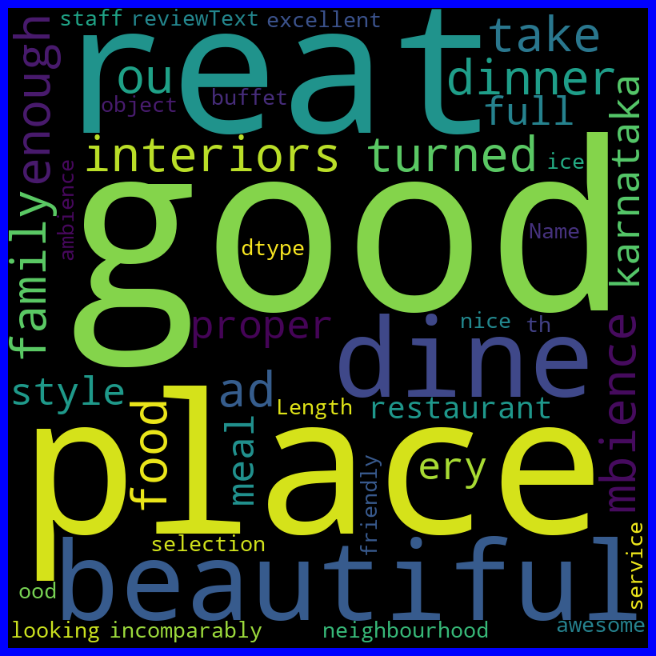

In [197]:
from wordcloud import WordCloud, STOPWORDS 
 
comment_words = ' '
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(zomatoDataPandas_withoutOutliers['reviewText']))
  
# plot the WordCloud image                        
plt.figure(figsize = (8,8), facecolor = 'blue') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) ;

WE OBSERVE THE FOLLOWING:

-------------
1. We can observe that good,place,beautiful,family,dinner,awesome,service,food,interiors,incomparably ect so this shows majaority of people have given good reviews about that as size shows the count.

### 62) Word Cloud for What did people like in the higher rated restaurents

In [198]:
topRatedRest = zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers.ratingsBy5 >= 4.5]

topDishes = []
for i in topRatedRest[topRatedRest.dishLiked != 'Unknown']['dishLiked']:
    for j in i.split(', '):
        topDishes.append(j)

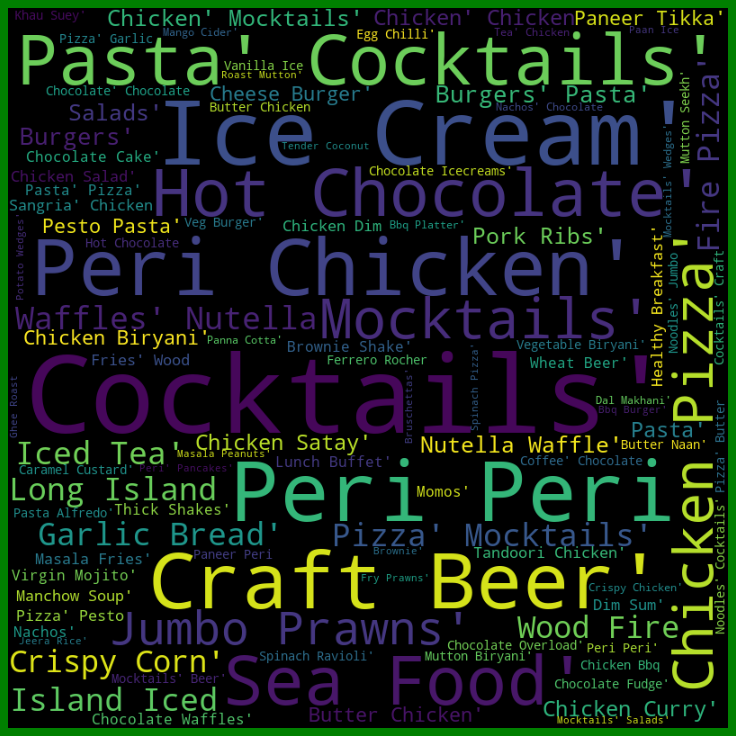

In [199]:
from wordcloud import WordCloud, STOPWORDS 
 
comment_words = ' '
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(topDishes))
  
# plot the WordCloud image                        
plt.figure(figsize = (9,9), facecolor = 'green') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) ;

WE OBSERVE THE FOLLOWING:

-----------

1. We can see Chicken peri peri,Hot Chocolate,Ice Cream,Chicken Pizza,Pasta,Cocktail,Craft Beer,Sear Food and Garlic Bread are the top Dishes that people like in the Higher Rated Restaurents as size tells the count.

### 63) Data for most liked dishes for each restaurent was provided in top 10 locations

In [200]:
top10Location = zomatoDataPandas_withoutOutliers.location.value_counts().index[:10].tolist()

top15RestTypeData = zomatoDataPandas_withoutOutliers[zomatoDataPandas_withoutOutliers.location.isin(top10Location)]
top15RestTypeData = top15RestTypeData[top15RestTypeData.dishLiked != 'Unknown']
top15RestTypeData = top15RestTypeData.drop_duplicates()
top15RestTypeData.groupby(['location','name','dishLiked'])['RateLabel'].max().head(15).reset_index()
#pd.crosstab(top15RestTypeData.ratingsBy5,top15RestTypeData.restType).plot(kind='line',marker='o');

location                                  name  \
0       BTM  100ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ°C   
1       BTM                36th Cross Coffee Mane   
2       BTM       3B's - Buddies, Bar & Barbecues   
3       BTM             A2B - Adyar Ananda Bhavan   
4       BTM             AB's - Absolute Barbecues   
5       BTM                       Abhiruchi Hotel   
6       BTM                                Al-Bek   
7       BTM                            Alankrutha   
8       BTM                    Ambur Star Briyani   
9       BTM                    Ambur Star Briyani   
10      BTM                       Amma's Pastries   
11      BTM                              Amontron   
12      BTM                              Amontron   
13      BTM                         Anda Ka Funda   
14      BTM                         Ande Ka Funda   

                                            dishLiked  RateLabel  
0                                     Chicken Biryani       Good  
1                                             Biryani       Good  
2   Paan Ice Cream, Cocktails, Fish Grill, Crispy ...  Excellent  
3   Tea, Coffee, Rasmalai, Raj Kachori, Masala Dos...       Good  
4   Tangdi Chicken, Bbq Buffet, Chocolate Icecream...  Excellent  
5   Dum Biryani, Prawn Curry, Paneer Biryani, Chic...       Good  
6                                Naan, Mutton Biryani       Good  
7    Chicken Biryani, Hyderabadi Biryani, Dum Biryani       Good  
8   Ambur Biryani, Mutton Biryani, Prawn, Raita, B...       Good  
9      Mutton Biryani, Ambur Biryani, Chicken Biryani       Good  
10  Fruit Truffle, Tiramisu Cake, Cheesecake, Choc...  Excellent  
11  Katla Kalia, Basanti Pulao, Biryani, Aloo Post...       Good  
12  Katla Kalia, Basanti Pulao, Biryani, Fish Curr...       Good  
13                               Paratha, Rolls, Roti       Good  
14                        Aloo Paratha, Ande Ka Funda    Average

### 64) Top 3 dishes liked in Most Rated Restaurant in top 10 locations

In [201]:
top10LocationData = zomatoDataPyspark_withoutOutliers.filter(zomatoDataPyspark_withoutOutliers['location'].isin(top10Location))
top10LocationData = top10LocationData.filter(top10LocationData['ratingsBy5']>=4.6)
top10LocationData.registerTempTable('top10LocationData')

In [202]:
spark.sql("select name,dishLiked,cnt,rnk from (select dishLiked,name,cnt,rank() OVER (PARTITION BY name \
order by cnt desc)rnk from (select dishLiked,name,count(name) as cnt from top10LocationData group by \
dishLiked,name)) where rnk <=3 order by 1,3 desc").show()

+--------------------+--------------------+---+---+
|                name|           dishLiked|cnt|rnk|
+--------------------+--------------------+---+---+
|AB's - Absolute B...|Tangdi Chicken, B...|  7|  1|
|AB's - Absolute B...|Mutton Roganjosh,...|  2|  2|
|AB's - Absolute B...|Raj Kachori, Paan...|  2|  2|
|Asia Kitchen By M...|Noodles, Chicken ...| 15|  1|
|Asia Kitchen By M...|Chicken Dim Sum, ...|  4|  2|
|     Barbeque Nation|Lunch Buffet, Goa...|  8|  1|
|     Barbeque Nation|Mutton Curry, Ten...|  4|  2|
|Belgian Waffle Fa...|Nachos, Chocolate...| 10|  1|
|Belgian Waffle Fa...|Oreo Waffle, Nach...|  1|  2|
|          Biergarten|Penne Arrabiata P...|  5|  1|
|          Biergarten|Cocktails, Pizza,...|  3|  2|
|          Biergarten|Wheat Beer, Risot...|  3|  2|
|Brew and Barbeque...|Bbq Platter, Craf...|  1|  1|
|         Burma Burma|Samosa Soup, Khau...|  2|  1|
|         Burma Burma|Samosa Soup, Khau...|  2|  1|
|             Chianti|Pasta, Tiramisu, ...|  5|  1|
|           

### 65)Top 5 expensive rest type vs least 5 rest type

In [203]:
Top10ExpenRest = zomatoDataPandas_withoutOutliers.groupby('restType')['approxCost(2 people)'].mean().sort_values(ascending=False).head(10)
Top10CheapRest = zomatoDataPandas_withoutOutliers.groupby('restType')['approxCost(2 people)'].mean().sort_values(ascending=True).head(10)

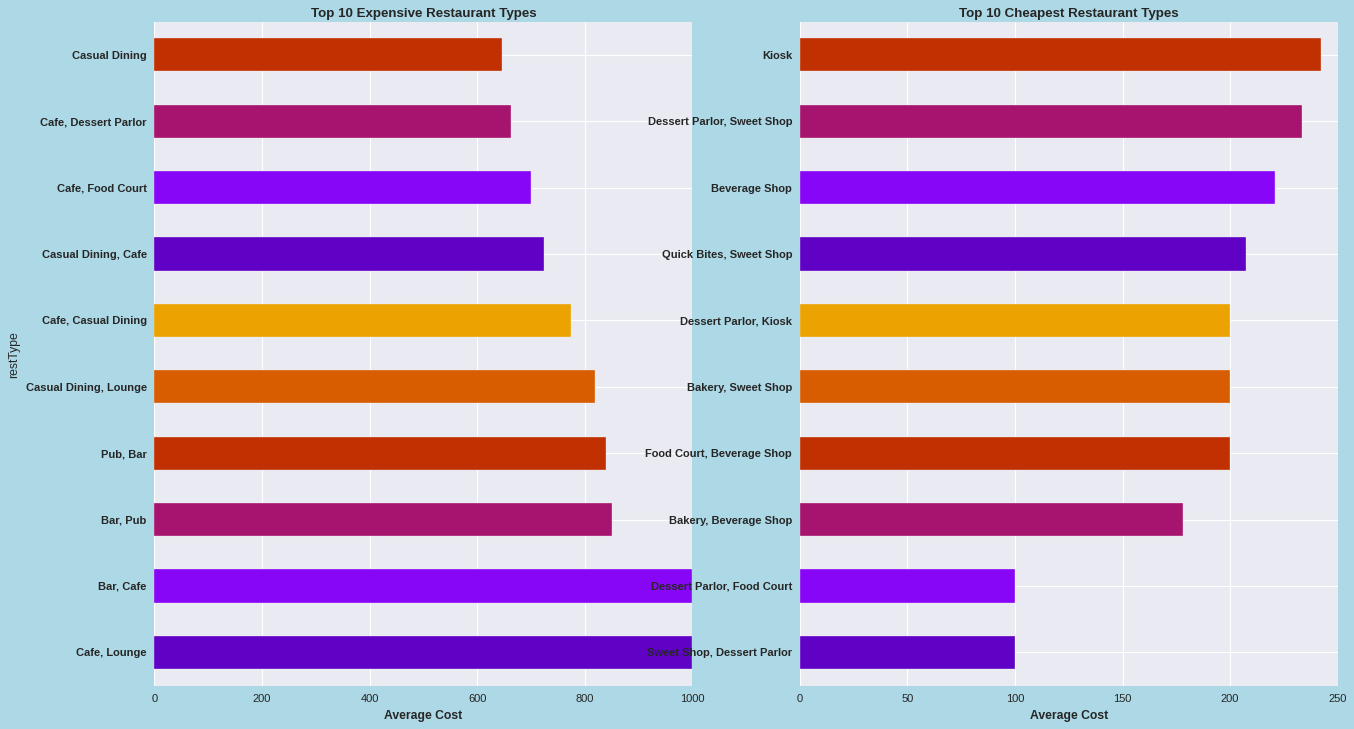

In [204]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('lightblue')
plt.style.use('seaborn-muted')

plt.subplot(121)
Top10ExpenRest.plot(kind='barh',color = sns.color_palette("gnuplot"),figsize=(17,10))
plt.title("Top 10 Expensive Restaurant Types",fontweight='bold')
plt.xlabel("Average Cost",fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(122)
Top10CheapRest.sort_values(ascending=True).plot(kind='barh',color = sns.color_palette("gnuplot"),figsize=(17,10))
plt.title("Top 10 Cheapest Restaurant Types",fontweight='bold')
plt.xlabel("Average Cost",fontweight='bold');
plt.yticks(fontweight='bold')
plt.ylabel(' ');

### WE OBSERVE THE FOLLOWING:

------------------
1. We can see Cafe,Lounge,Bar,Pub and Casual Dinings are the most costly Restaurant Types.

2. We can see Dessart parlor,Sweet Shop,Beverage Shop,Bakery and Food Court are the most cheapest Restaurant Types 

### 66) Top 5 Rated Restaurant vs Least 5 rated Restaurant

In [205]:
Top10HighRatedRest = zomatoDataPandas_withoutOutliers.groupby('restType')['ratingsBy5'].mean().sort_values(ascending=False).head(10)
Top10LowRatedRest = zomatoDataPandas_withoutOutliers.groupby('restType')['ratingsBy5'].mean().sort_values(ascending=True).head(10)

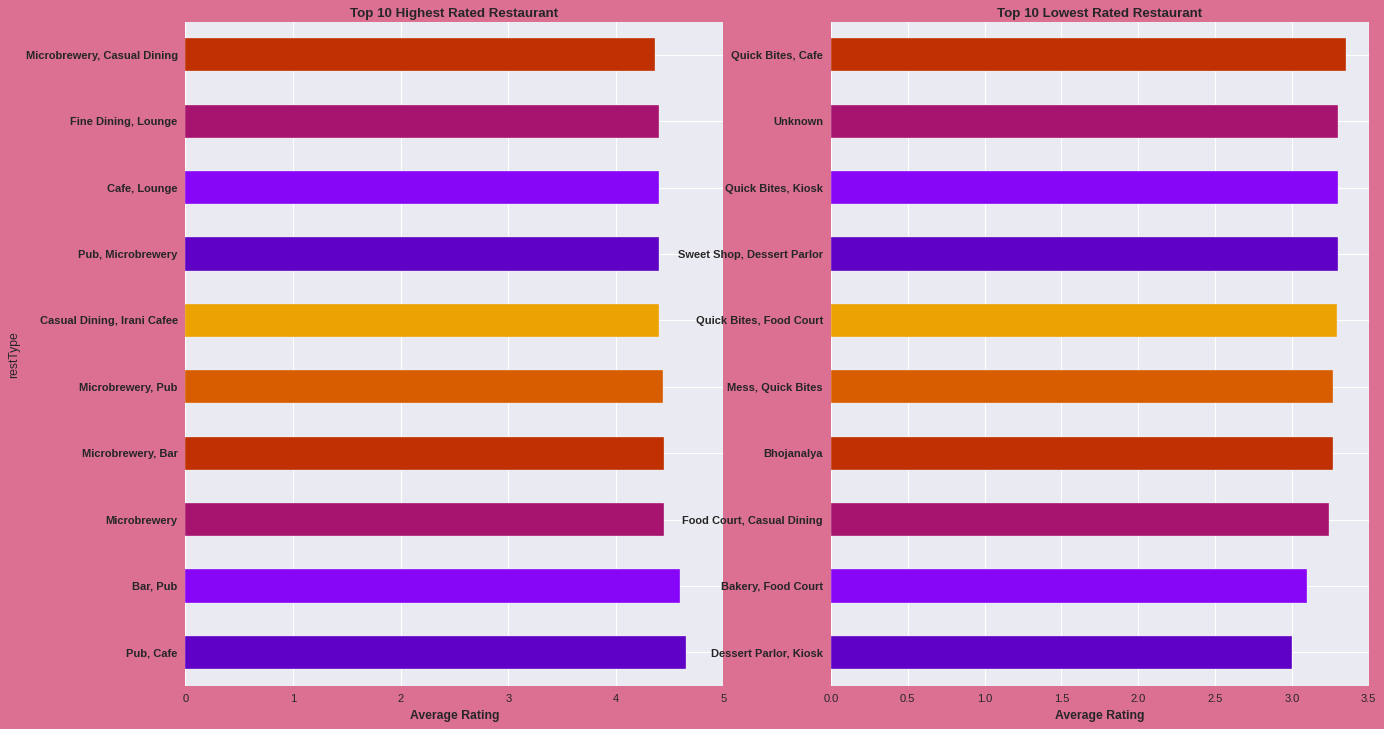

In [206]:
fig = plt.figure(figsize=(17,10))
fig.patch.set_facecolor('palevioletred')
plt.style.use('seaborn')

plt.subplot(121)
Top10HighRatedRest.plot(kind='barh',color = sns.color_palette("gnuplot"))
plt.title("Top 10 Highest Rated Restaurant",fontweight='bold')
plt.xlabel("Average Rating",fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(122)
Top10LowRatedRest.sort_values(ascending=True).plot(kind='barh',color = sns.color_palette("gnuplot"))
plt.title("Top 10 Lowest Rated Restaurant",fontweight='bold')
plt.xlabel("Average Rating",fontweight='bold');
plt.yticks(fontweight='bold')
plt.ylabel(' ');

WE OBSERVE THE FOLLOWING:

-----------
1. We see Pub,Cafe,Bar,Microbrewery and Irani Cafe are the restaurants which are the highest rated. Even though Pub,Bar and Cafe are costly they recieve the highest ratings.

2. Dessart parlor,Kiosk,Bakery,Food Court,Casual Dining and Bhojanala are the restaurants which are the lowest rated. Though Dessart parlor,Kiosk,Bakery,Food Court are cheapest they recieve the lowest ratings.

### 67)WordCloud for allCuisines

In [207]:
allCuisines = []

for i in zomatoDataPandas_withoutOutliers.cuisines:
    for j in i.split(', '):
        allCuisines.append(j.strip())

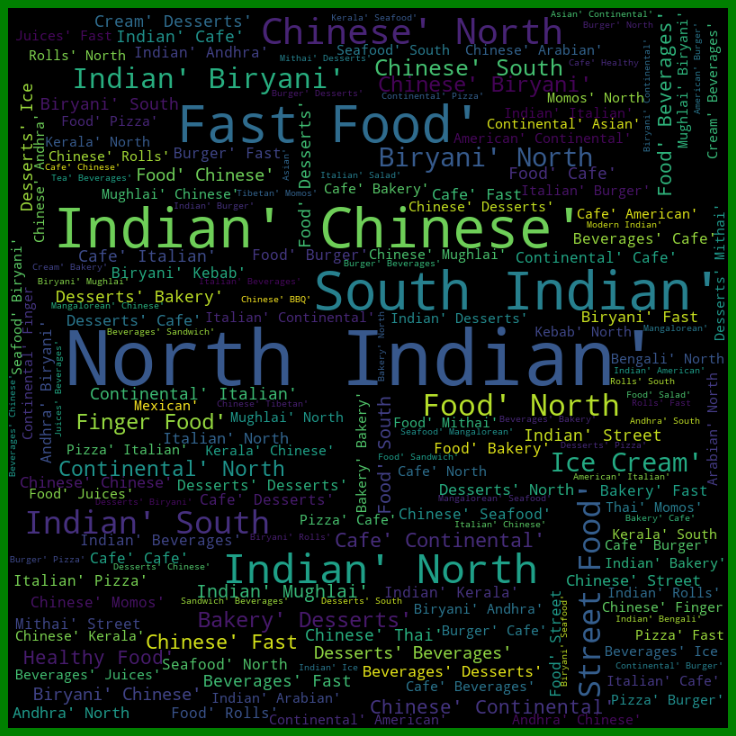

In [208]:
from wordcloud import WordCloud, STOPWORDS
 
comment_words = ' '
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(allCuisines))
  
# plot the WordCloud image                        
plt.figure(figsize = (9,9), facecolor = 'green') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) ;

WE OBSERVE THE FOLLOWING:

----------

1. We can see North Indian, Chinease,Fast Food,South Indian,Street Food are the top Cuisines as size shows the count

### 68) Finding the best restaurants:- The criteria for best restaurants would be 
1. cheapest
2. highly rated
3. reliable(large number of votes) options.

In [209]:
newdf = zomatoDataPandas[['name','approxCost(2 people)','location','restType','cuisines']].groupby(['approxCost(2 people)'], sort = True) 
newdf = newdf.filter(lambda x:x.mean()<1500).sort_values(by=['approxCost(2 people)'])

In [210]:
newdf_expensive= zomatoDataPandas[['name','approxCost(2 people)','location','restType','cuisines']].groupby(['approxCost(2 people)'], sort = True) 
newdf_expensive=newdf_expensive.filter(lambda x: x.mean() >= 3000).sort_values(by=['approxCost(2 people)'])

In [211]:
#lets find the highest rated restaurants i.e rating above 4.5
newdf_rate = zomatoDataPandas[['name','ratingsBy5']].groupby(['ratingsBy5'], sort = True) 
newdf_rate = newdf_rate.filter(lambda x: x.mean() >= 4.5) 
newdf_rate = newdf_rate.sort_values(by=['ratingsBy5'])

In [212]:
#These are the most reliable, highest rated and economical restaurants:-
#We obtain this dataframe by simply taking the intersection of all the dataframes obtained above.

s1 = pd.merge(newdf, newdf_rate, how='inner', on=['name']) 
s2= pd.merge(newdf_expensive, newdf_rate, how='inner', on=['name'])

print("Cheap restaurants with low cost,high rating \n") 
s1.drop_duplicates().head(20)
print("************************************************")
print("Expensive restaurants with high cost,high rating \n")
s2.drop_duplicates().head(50)

Cheap restaurants with low cost,high rating 



name  approxCost(2 people)  \
0            Taaza Thindi                 100.0   
1    Brahmin's Coffee Bar                 100.0   
2    Brahmin's Coffee Bar                 250.0   
3              Polar Bear                 150.0   
27             Polar Bear                 300.0   
31             Polar Bear                 300.0   
59             Polar Bear                 300.0   
67             Polar Bear                 400.0   
75             Polar Bear                 400.0   
79             Polar Bear                 400.0   
87             Polar Bear                 400.0   
91             Polar Bear                 400.0   
103            Polar Bear                 400.0   
107            Polar Bear                 400.0   
111            Polar Bear                 400.0   
123            Polar Bear                 400.0   
147            Polar Bear                 400.0   
151            Polar Bear                 400.0   
155            Polar Bear                 400.0   
171            Polar Bear                 400.0   

                          location            restType  \
0                     Banashankari         Quick Bites   
1                     Basavanagudi         Quick Bites   
2                     Malleshwaram         Quick Bites   
3                   CV Raman Nagar      Dessert Parlor   
27   Varthur Main Road, Whitefield  Takeaway, Delivery   
31                             BTM  Takeaway, Delivery   
59                 Electronic City  Takeaway, Delivery   
67           Koramangala 6th Block      Dessert Parlor   
75                    Basavanagudi      Dessert Parlor   
79                    Kalyan Nagar      Dessert Parlor   
87                     Rajajinagar      Dessert Parlor   
91                    Malleshwaram      Dessert Parlor   
103                            HSR      Dessert Parlor   
107          Koramangala 6th Block      Dessert Parlor   
111                   Marathahalli      Dessert Parlor   
123                            HSR      Dessert Parlor   
147                Electronic City      Dessert Parlor   
151                      Jayanagar      Dessert Parlor   
155              Bannerghatta Road      Dessert Parlor   
171                      Bellandur      Dessert Parlor   

                                     cuisines  ratingsBy5  
0                                South Indian         4.7  
1                                South Indian         4.8  
2                                South Indian         4.8  
3                                   Ice Cream         4.5  
27                        Desserts, Ice Cream         4.5  
31                        Desserts, Ice Cream         4.5  
59                        Desserts, Ice Cream         4.5  
67   Desserts, Ice Cream, Beverages, Sandwich         4.5  
75   Desserts, Ice Cream, Beverages, Sandwich         4.5  
79   Ice Cream, Desserts, Beverages, Sandwich         4.5  
87   Desserts, Ice Cream, Beverages, Sandwich         4.5  
91   Desserts, Ice Cream, Beverages, Sandwich         4.5  
103  Desserts, Ice Cream, Beverages, Sandwich         4.5  
107  Ice Cream, Desserts, Beverages, Sandwich         4.5  
111  Desserts, Ice Cream, Beverages, Sandwich         4.5  
123  Ice Cream, Desserts, Beverages, Sandwich         4.5  
147  Ice Cream, Desserts, Beverages, Sandwich         4.5  
151  Ice Cream, Desserts, Beverages, Sandwich         4.5  
155  Ice Cream, Desserts, Beverages, Sandwich         4.5  
171  Ice Cream, Desserts, Beverages, Sandwich         4.5

************************************************
Expensive restaurants with high cost,high rating 



name  approxCost(2 people)        location  \
0            Rim Naam - The Oberoi                3000.0         MG Road   
144  Karavalli - The Gateway Hotel                3500.0  Residency Road   
169   Alba - JW Marriott Bengaluru                4000.0    Lavelle Road   

        restType                              cuisines  ratingsBy5  
0    Fine Dining                                  Thai         4.6  
144  Fine Dining  Mangalorean, Konkan, Seafood, Kerala         4.5  
169  Fine Dining                               Italian         4.5

WE OBSERVE THE FOLLOWING:

------------
Best restaurant options under 500 Rupees (average cost):-
1.  Brahmin's Coffee Bar with average cost=100 and rating=4.8 and votes=2679, CTR with average cost=150 and rating=4.7 and votes=4408, Veena Stores with average cost=150 and rating=4.5 and votes=2407
2.  O.G. Variar & Sons with average cost=200 and rating=4.8 and votes=1156, Mavalli Tiffin Room (MTR) with average cost=250 and rating=4.5 and votes=2896, Belgian Waffle Factory with average cost=400 and rating=4.9 and votes=1746

3. Also, observe that these cheaper options (cost<500) are all either Quick Bites, Cafe or Dessert Parlour.

4. Casual Dining restaurants start above 600 , 6 out of 10 of the cheapest restaurants serve South Indian Cuisine

5. As for the location, these cheap restaurant option are scattered and not localised to any specific location of the city.

6. We can also explore the expensive options :-
Here, we are only picking up the restaurants that cost more than 3000(half of most expensive restaurant) and are highest rated , have large votes.


7. The Oberoi Hotel, Karavalli and JW Marriott make this high profile list

8. Interestingly, all these restaurants have the same location- Brigade Road and same restaurant type- Fine dining

### 69)Suggest me some restaurants nearby from where I can order food online.

In [213]:
location = 'Banashankari'
#input("Enter the Location: ")
cuisine = 'Bakery'
#input("Enter the Cuisine Type: ")

isOnline = 'Yes'
pd.DataFrame(zomatoDataPandas_withoutOutliers[['name', 'ratingsBy5', 'approxCost(2 people)']]
             [(zomatoDataPandas_withoutOutliers['location'].str.contains(location)) 
              & (zomatoDataPandas_withoutOutliers['cuisines'].str.contains(cuisine)) 
              & (zomatoDataPandas_withoutOutliers['onlineOrder'] == isOnline)]).sort_values(['ratingsBy5'], ascending = False).drop_duplicates().reset_index().drop('index',axis=1)

name  ratingsBy5  approxCost(2 people)
0  Sweet Truth         3.9                 500.0
1  Cocoa Bakes         3.6                 350.0
2   Grand Food         3.4                 250.0

In [214]:

def doughnutchart(labels,values,title):
    colors=["#F7B7A3","#EA5F89"]
    data=go.Pie(labels=labels,values=values,hole=0.6,pull=0.04,marker=dict(colors=colors))
    layout=go.Layout(title=title)
    fig=go.Figure(data=data,layout=layout)
    iplot(fig)

### 70) Top 5 restaurant name with their location,cost Range wrt each top 5 restType

In [215]:
top5RestData = zomatoDataPandas_withoutOutliers.restType.value_counts()[:5].index.tolist()
top5RestTypeData = zomatoDataPyspark_withoutOutliers.filter(zomatoDataPyspark_withoutOutliers['restType'].isin(top5RestData))

top5RestTypeData.registerTempTable('top5RestTypeData')

In [216]:
spark.sql("select restType,name,location,costRange,cnt,rnk from (select name,location,costRange,cnt,restType,\
RANK() OVER (PARTITION BY restType ORDER BY cnt desc) rnk \
from (select distinct name,location,costRange,restType,count(name) as cnt from top5RestTypeData \
group by name,location,costRange,restType)) where rnk<=5 order by 1,5 desc,4").toPandas().head(20)

restType                                        name  \
0             Cafe                                    Chillout   
1             Cafe                            Bistro Claytopia   
2             Cafe                         Smally's Resto Cafe   
3             Cafe                                   Maxpresso   
4             Cafe                                Roundup Cafe   
5             Cafe           The Lobby Brew - Conrad Bengaluru   
6             Cafe                         Fresh Pressery Cafe   
7    Casual Dining                                    Bonsouth   
8    Casual Dining  Tangerine - Davanam Sarovar Portico Suites   
9    Casual Dining                                   Nossa Goa   
10   Casual Dining                Pinxx - Royal Orchid Central   
11   Casual Dining                            The Tao Terraces   
12   Casual Dining                         Banjara Melting Pot   
13        Delivery                                Jiyo Natural   
14        Delivery                                 Call A Cake   
15        Delivery                                     eat.fit   
16        Delivery                          Bhandary's Kitchen   
17        Delivery                         Raptures Chocolates   
18  Dessert Parlor                     The Chef's Cake & Bakes   
19  Dessert Parlor                                Rawal Jalebi   

                 location        costRange  cnt  rnk  
0                     BTM            cheap   21    1  
1   Koramangala 1st Block        expensive   21    1  
2   Koramangala 5th Block        expensive   21    1  
3   Koramangala 7th Block        expensive   21    1  
4   Koramangala 5th Block        expensive   21    1  
5                  Ulsoor  extra expensive   21    1  
6   Koramangala 5th Block  extra expensive   21    1  
7   Koramangala 5th Block  extra expensive   21    1  
8   Koramangala 2nd Block  extra expensive   21    1  
9           Richmond Road  extra expensive   19    3  
10                MG Road  extra expensive   19    3  
11                MG Road  extra expensive   19    3  
12        Cunningham Road  extra expensive   19    3  
13        South Bangalore         moderate   14    1  
14                    BTM         moderate   13    2  
15                    BTM         moderate   11    3  
16  Koramangala 7th Block         moderate   11    3  
17  Koramangala 4th Block         moderate   11    3  
18          Richmond Road        expensive   15    1  
19      Commercial Street            cheap   13    2

In [217]:
top5RestData = spark.sql("select restType,name,location,costRange,cnt,rnk from (select name,location,costRange,cnt,restType,\
RANK() OVER (PARTITION BY restType ORDER BY cnt desc) rnk \
from (select distinct name,location,costRange,restType,count(name) as cnt from top5RestTypeData \
group by name,location,costRange,restType)) where rnk<=5 order by 1,5 desc").toPandas()

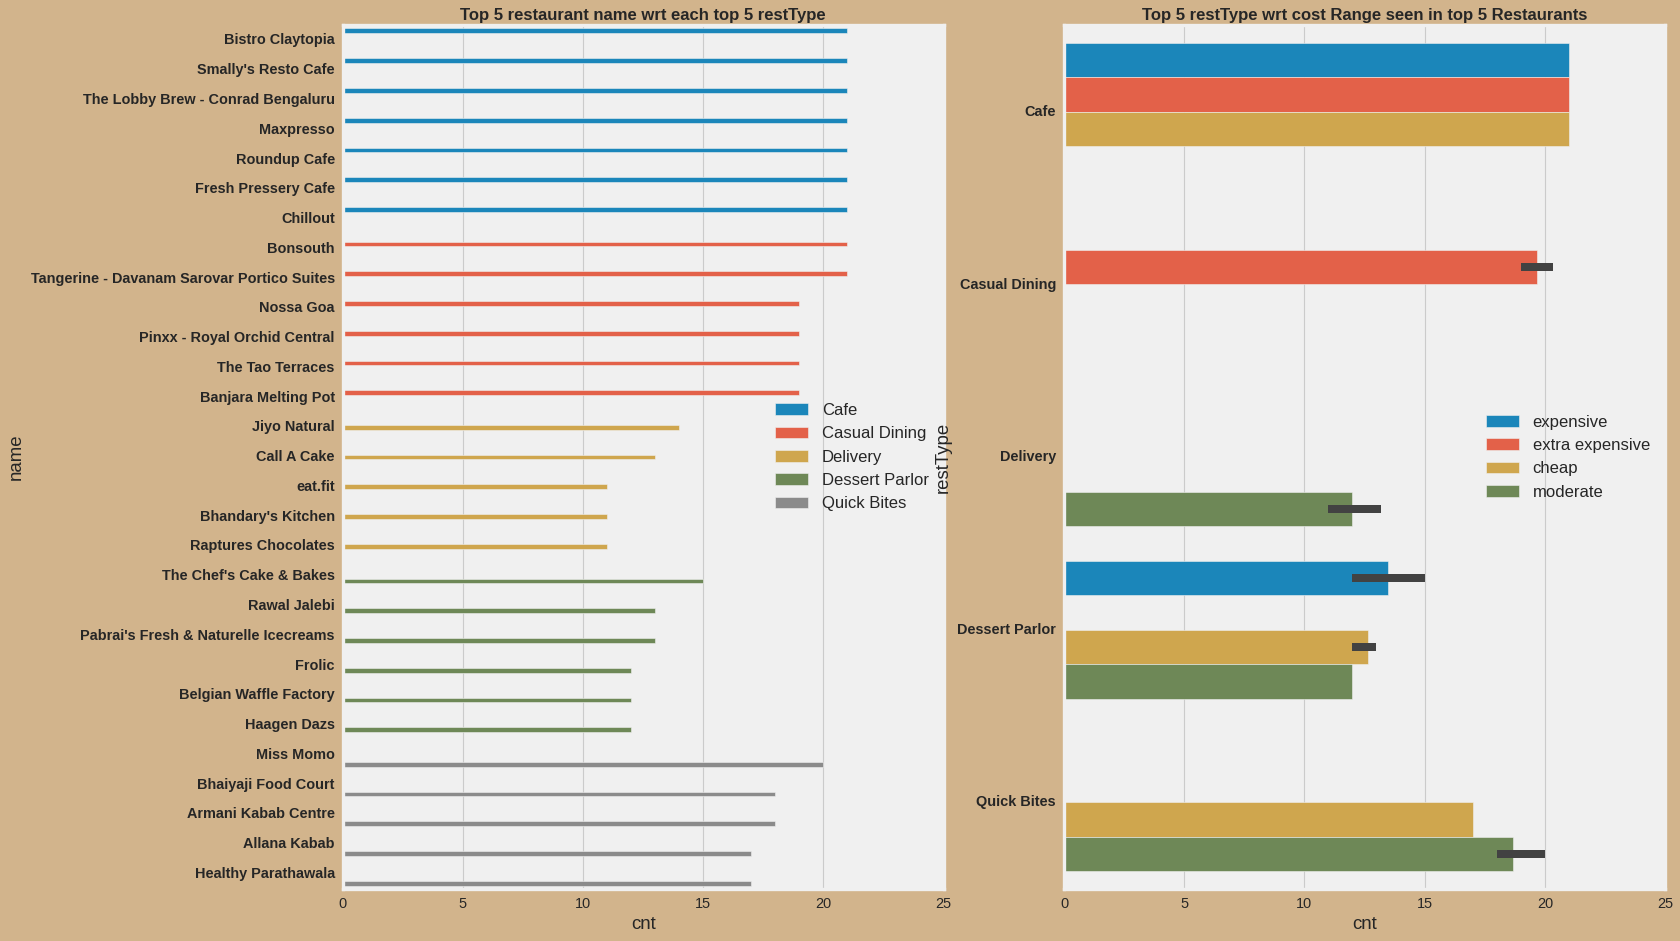

In [218]:
fig = plt.figure(figsize=(19,13))
fig.patch.set_facecolor('tan')
plt.style.use('fivethirtyeight')

plt.subplot(121)
sns.barplot(data=top5RestData,hue='restType',x='cnt',y='name');
plt.yticks(fontsize=13,fontweight='bold');
plt.xticks(fontsize=13);
plt.title("Top 5 restaurant name wrt each top 5 restType",fontsize=15,fontweight='bold')
plt.legend(loc='center right',prop={"size":15})
plt.subplot(122)
sns.barplot(data=top5RestData,hue='costRange',x='cnt',y='restType');
plt.title("Top 5 restType wrt cost Range seen in top 5 Restaurants",fontsize=15,fontweight='bold');
plt.yticks(fontsize=13,fontweight='bold');
plt.xticks(fontsize=13);
plt.legend(loc='center right',prop={"size":15});
#x1.legend().set_visible(False)

### 71)Which are the 3 most common cuisines,costRange in top 5 restType?

In [219]:
top5RestData = zomatoDataPandas_withoutOutliers.restType.value_counts()[:5].index.tolist()
top5RestTypeData = zomatoDataPyspark_withoutOutliers.filter(zomatoDataPyspark_withoutOutliers['restType'].isin(top5RestData))
top5RestTypeData.registerTempTable('RestTypeData')

In [220]:
spark.sql("select restType,cuisines,costRange,cnt,rnk from (select cuisines,costRange,restType,cnt,RANK()\
OVER(PARTITION BY restType order by cnt desc)rnk from (select distinct cuisines,costRange,restType,\
count(cuisines) as cnt from RestTypeData group by cuisines,costRange,restType)) \
where rnk<=3 order by 1,4 desc").toPandas().head(15)

restType               cuisines  costRange   cnt  rnk
0             Cafe                   Cafe   moderate   386    1
1             Cafe                   Cafe  expensive   259    2
2             Cafe      Cafe, Continental  expensive   110    3
3    Casual Dining           North Indian  expensive   390    1
4    Casual Dining  North Indian, Chinese  expensive   372    2
5    Casual Dining  North Indian, Chinese   moderate   231    3
6         Delivery           North Indian   moderate   267    1
7         Delivery  North Indian, Chinese   moderate   125    2
8         Delivery       Bakery, Desserts   moderate    96    3
9   Dessert Parlor               Desserts   moderate   400    1
10  Dessert Parlor    Ice Cream, Desserts   moderate   265    2
11  Dessert Parlor    Desserts, Ice Cream   moderate   196    3
12     Quick Bites  North Indian, Chinese   moderate  1075    1
13     Quick Bites           North Indian   moderate  1057    2
14     Quick Bites           South Indian      cheap  1018    3

In [221]:
top3Cuisines = spark.sql("select restType,cuisines,costRange,cnt,rnk from (select cuisines,costRange,restType,cnt,RANK()\
OVER(PARTITION BY restType order by cnt desc)rnk from (select distinct cuisines,costRange,restType,\
count(cuisines) as cnt from RestTypeData group by cuisines,costRange,restType)) \
where rnk<=4 order by 1,4 desc").toPandas()

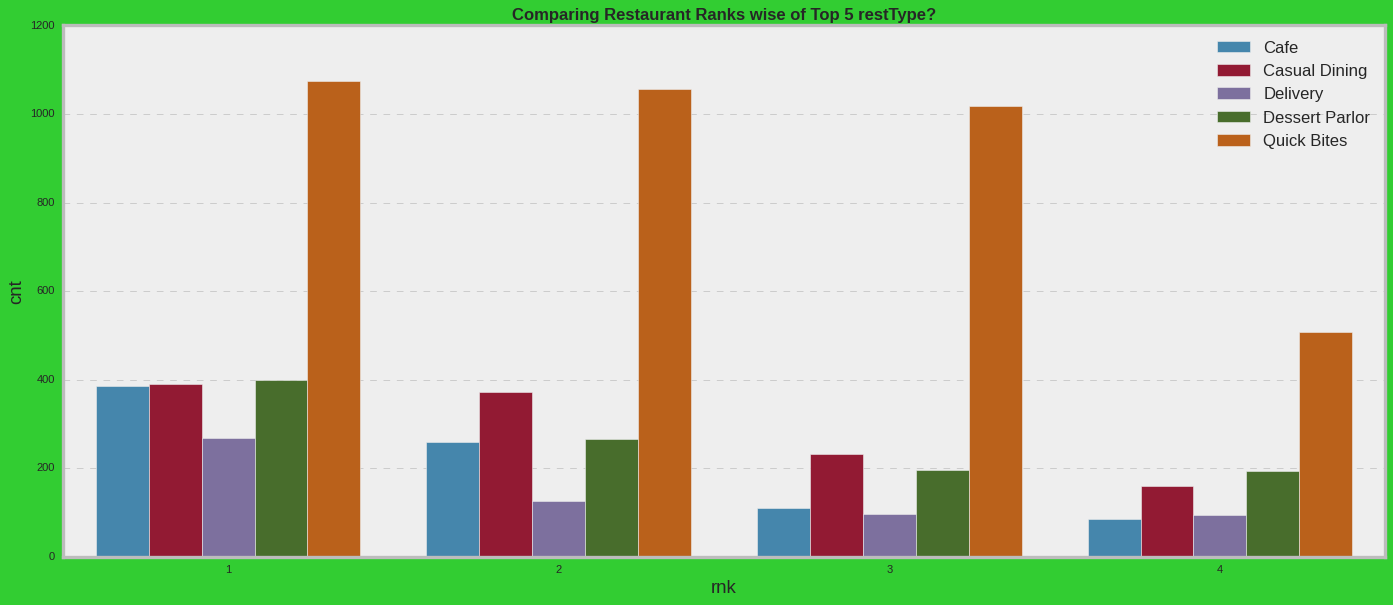

In [222]:
fig = plt.figure(figsize=(19,8))
fig.patch.set_facecolor('limegreen')
plt.style.use('bmh')

sns.barplot(data=top3Cuisines,x='rnk',y='cnt',hue='restType');
plt.title("Comparing Restaurant Ranks wise of Top 5 restType?",fontsize=15,fontweight='bold')
plt.legend(prop={"size":15});


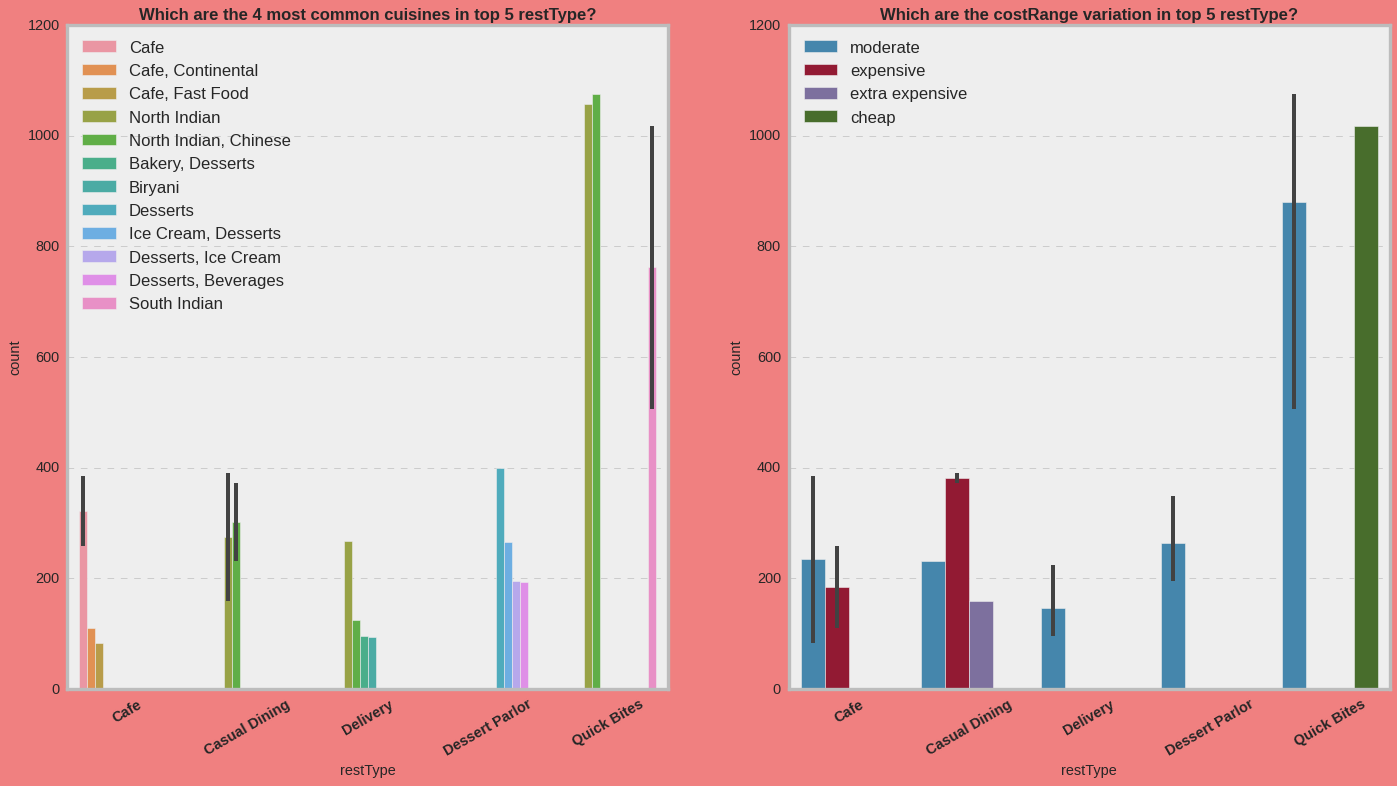

In [223]:
fig = plt.figure(figsize=(19,10))
fig.patch.set_facecolor('lightcoral')
plt.style.use('bmh')

plt.subplot(121)
sns.barplot(data=top3Cuisines,x='restType',y='cnt',hue='cuisines');
plt.xticks(fontsize=13,fontweight='bold',rotation=30);
plt.yticks(fontsize=13);
plt.xlabel("restType",fontsize=13);
plt.ylabel("count",fontsize=13);
plt.title("Which are the 4 most common cuisines in top 5 restType?",fontsize=15,fontweight='bold')
plt.legend(prop={"size":15},loc='upper left')

plt.subplot(122)
sns.barplot(data=top3Cuisines,x='restType',y='cnt',hue='costRange');
plt.xticks(fontsize=13,fontweight='bold',rotation=30);
plt.yticks(fontsize=13);
plt.xlabel("restType",fontsize=13);
plt.ylabel("count",fontsize=13);
plt.title("Which are the costRange variation in top 5 restType?",fontsize=15,fontweight='bold')
plt.legend(prop={"size":15},loc='upper left');

### 71) Top 3 Cuisines,dishLiked,location,dishLiked wrt top 10 cost paid ?

In [224]:
top10Costpaid = zomatoDataPandas_withoutOutliers.groupby('approxCost(2 people)')['name'].count().sort_values(ascending=False).reset_index().head(10)['approxCost(2 people)'].tolist()
top10CostData = zomatoDataPyspark_withoutOutliers.filter(zomatoDataPyspark_withoutOutliers['approxCost(2 people)'].isin(top10Costpaid))
top10CostData = top10CostData.withColumnRenamed('approxCost(2 people)','avgCost2People')
top10CostData.registerTempTable('top10CostData')

In [225]:
spark.sql("select avgCost2People,Cuisines,location,dishLiked,cnt,rnk from (select Cuisines,\
dishLiked,location,cnt,avgCost2People,RANK() OVER(PARTITION BY avgCost2People \
order by cnt desc)rnk from (select Cuisines,dishLiked,location,CAST(avgCost2People AS string),\
count(Cuisines) as cnt from top10CostData where dishLiked != 'Unknown' group by Cuisines,dishLiked,\
location,avgCost2People)) where rnk<=3 order by 1,cnt desc,6").toPandas().head(15)

avgCost2People                                        Cuisines  \
0             150                                    North Indian   
1             150                                    North Indian   
2             150                                          Bakery   
3             150                               Juices, Fast Food   
4             150                                        Desserts   
5             150                                    North Indian   
6             200  South Indian, North Indian, Chinese, Beverages   
7             200                             Mithai, Street Food   
8             200                                         Biryani   
9             250                               Fast Food, Bakery   
10            250               Mithai, North Indian, Street Food   
11            250                                        Desserts   
12            250                                         Arabian   
13            250                                       Fast Food   
14            250                    North Indian, Chinese, Rolls   

                 location                                          dishLiked  \
0                  Ulsoor                     Lassi, Amritsari Kulcha, Chole   
1   Koramangala 5th Block  Veg Thali, Paratha, Kadhi, Shrikhand, Buttermi...   
2   Koramangala 7th Block           Chocolate Chip Cookie, Brownie Chocolate   
3          St. Marks Road  Sandwiches, Fruit Bowl, Panipuri, Corn Sandwic...   
4   Koramangala 7th Block                           Donut, Chocolate Fantasy   
5   Koramangala 1st Block                                              Thali   
6   Koramangala 5th Block                                        Masala Dosa   
7                 MG Road  Rasgulla, Luchi, Samosa, Radhaballavi, Rasmala...   
8   Koramangala 7th Block   Biryani, Paratha, Chicken Masala, Kerala Parotta   
9            Brigade Road  Burgers, Sandwiches, Momos, Chicken Seekh Roll...   
10  Koramangala 6th Block  Thali, Dhokla, Chaat, Samosa, Panipuri, Jalebi...   
11          Church Street                                      Hot Chocolate   
12                    BTM  Rumali Roti, Rumali Shawarma, Burgers, Shawarm...   
13  Koramangala 5th Block  Tea, Chole, Khichda, Butter Paneer, Paneer Bhu...   
14                    BTM                               Paratha, Rolls, Roti   

    cnt  rnk  
0    13    1  
1    10    2  
2    10    2  
3    10    2  
4    10    2  
5    10    2  
6    11    1  
7    11    1  
8    11    1  
9    16    1  
10   13    2  
11   11    3  
12   11    3  
13   11    3  
14   11    3

### 72) Top 3 RestType,cuisines wrt each listedInType.

In [226]:
spark.sql("select listedInType,RestType,Cuisines,cnt,rnk from (select RestType,Cuisines,listedInType,cnt,RANK() OVER(PARTITION BY listedInType order by cnt desc)rnk from (select RestType,Cuisines,listedInType,count(*) as cnt from zomatoData group by RestType,Cuisines,\
listedInType order by cnt desc)) where rnk<=3 order by 1 desc,4 desc").toPandas().head(20)

listedInType            RestType               Cuisines  cnt  rnk
0        Pubs and bars                 Bar            Finger Food   27    1
1        Pubs and bars                 Bar  North Indian, Chinese   18    2
2        Pubs and bars  Casual Dining, Bar           North Indian   10    3
3   Drinks & nightlife              Lounge            Finger Food   45    1
4   Drinks & nightlife                 Bar            Finger Food   37    2
5   Drinks & nightlife                 Bar  North Indian, Chinese   26    3
6             Dine-out         Quick Bites           South Indian  944    1
7             Dine-out         Quick Bites           North Indian  657    2
8             Dine-out         Quick Bites  North Indian, Chinese  539    3
9             Desserts      Dessert Parlor               Desserts  280    1
10            Desserts              Bakery       Bakery, Desserts  265    2
11            Desserts              Bakery                 Bakery  224    3
12            Delivery         Quick Bites           North Indian  823    1
13            Delivery         Quick Bites  North Indian, Chinese  717    2
14            Delivery         Quick Bites           South Indian  586    3
15               Cafes                Cafe                   Cafe  277    1
16               Cafes                Cafe        Cafe, Fast Food   78    2
17               Cafes                Cafe      Cafe, Continental   56    3
18              Buffet       Casual Dining           North Indian   29    1
19              Buffet       Casual Dining  North Indian, Chinese   28    2

In [227]:
top3RestTypeData = spark.sql("select listedInType,RestType,Cuisines,cnt,rnk from (select RestType,Cuisines,\
listedInType,cnt,RANK() OVER(PARTITION BY listedInType order by cnt desc)rnk from (select RestType,Cuisines,\
listedInType,count(*) as cnt from zomatoData group by RestType,Cuisines,listedInType order by cnt desc)) \
where rnk<=5 order by 1 desc,4 desc").toPandas()

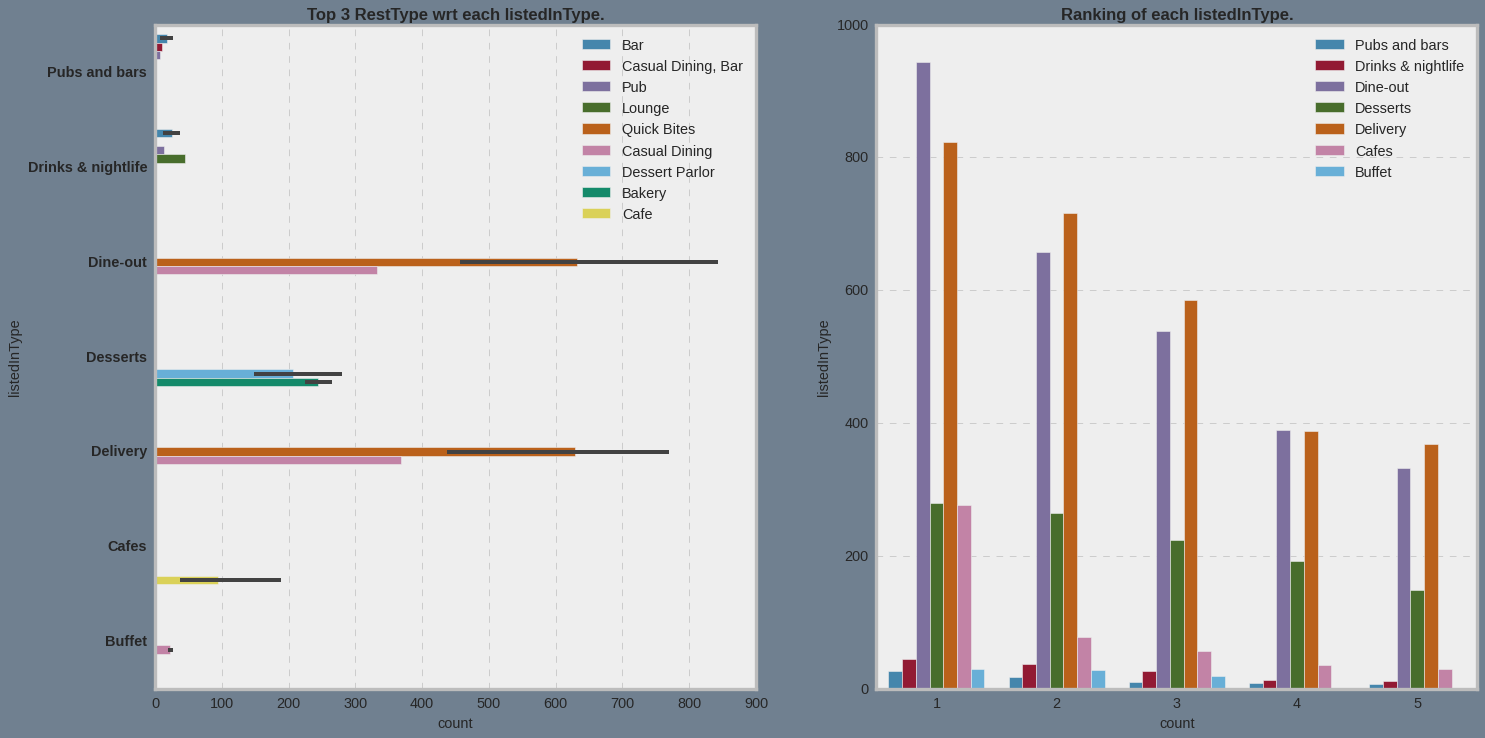

In [228]:
fig = plt.figure(figsize=(19,10))
fig.patch.set_facecolor('slategrey')
plt.style.use('bmh')

plt.subplot(121)
sns.barplot(data=top3RestTypeData,y='listedInType',x='cnt',hue='RestType');

plt.yticks(fontsize=13,fontweight='bold');
plt.xticks(fontsize=13);
plt.ylabel("listedInType",fontsize=13);
plt.xlabel("count",fontsize=13);
plt.title("Top 3 RestType wrt each listedInType.",fontsize=15,fontweight='bold')
plt.legend(prop={"size":13})

plt.subplot(122)
sns.barplot(data=top3RestTypeData,hue='listedInType',y='cnt',x='rnk');
plt.yticks(fontsize=13);
plt.xticks(fontsize=13);
plt.ylabel("listedInType",fontsize=13);
plt.xlabel("count",fontsize=13);
plt.title("Ranking of each listedInType.",fontsize=15,fontweight='bold')
plt.legend(loc='upper right',prop={"size":13});

Final Conclusion

----------

1. We figured BTM, Koramangala, HSR are good places to start restaurant. WhiteField has most number of unique restaurants and can be cheaper to get started. Koramangala, Indiranagar, BTM are most popular locations among foodies.

2. Large number of votes can ensure better rating and 1K for 2 people is good to go price.

3. Bangalorian love NorthIndia and Fast Food.

4. Providing online ordering can boast your chances.